# AP-1 Figures

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
import time
import ete3
### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


## Functions

In [2]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [3]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Copy Score Files

In [4]:
%%bash 
cp ./peak_sequences/C57BL6J.fa ./

In [5]:
%%bash
# random background files
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/background_group_summary.tsv ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_count_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_score_background_frame_C57BL6J.pickle ./  
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_start_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_end_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_sequence_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_strand_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J_background.fa ./

## Read in Score Files

In [4]:
summary_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,8,9,11,13,14,15,19,21,22,23,24,25,26,27,29,31,33,34,35,36,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
summary_background_frame = pd.read_csv('./background_group_summary.tsv' , sep='\t')
summary_background_frame = summary_background_frame.fillna('0')
for col in summary_background_frame.columns[5:]:
    floatValues = []
    for val in summary_background_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_background_frame[col] = floatValues
summary_background_frame.index = summary_background_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_background_frame = summary_background_frame[~summary_background_frame['chr'].str.contains('random')]
summary_background_frame = summary_background_frame[~summary_background_frame['chr'].str.contains('Un')]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,8,9,11,12,13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
motif_score_frame = pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
# motif_count_frame = pd.read_pickle('motif_count_frame_C57BL6J.pickle')

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
   

In [7]:
motif_score_balb_frame = pd.read_pickle('motif_score_frame_BALBCJ.pickle')
motif_sequence_balb_frame = pd.read_pickle('motif_sequence_frame_BALBCJ.pickle')
motif_strand_balb_frame = pd.read_pickle('motif_strand_frame_BALBCJ.pickle')
motif_start_balb_frame = pd.read_pickle('motif_start_frame_BALBCJ.pickle')
motif_end_balb_frame = pd.read_pickle('motif_end_frame_BALBCJ.pickle')
# motif_count_balb_frame = pd.read_pickle('motif_count_frame_BALBCJ.pickle')

In [8]:
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_C57BL6J.pickle')
motif_sequence_background_frame = pd.read_pickle('motif_sequence_background_frame_C57BL6J.pickle')
motif_strand_background_frame = pd.read_pickle('motif_strand_background_frame_C57BL6J.pickle')
motif_start_background_frame = pd.read_pickle('motif_start_background_frame_C57BL6J.pickle')
motif_end_background_frame = pd.read_pickle('motif_end_background_frame_C57BL6J.pickle')
# motif_count_background_frame = pd.read_pickle('motif_count_background_frame_C57BL6J.pickle')

# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
# motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]


In [10]:
# rearrange columns
columns = list(motif_score_frame.columns.values)
columns.remove('ID')
columns.remove('chr')
columns.remove('Factors')
motifs = columns
sorted_columns = ['ID', 'chr' , 'Factors'] + sorted(motifs)

motif_score_frame = motif_score_frame[sorted_columns]
motif_sequence_frame = motif_sequence_frame[sorted_columns]
motif_strand_frame = motif_strand_frame[sorted_columns]
motif_start_frame = motif_start_frame[sorted_columns]
motif_end_frame = motif_end_frame[sorted_columns]
# motif_count_frame = motif_count_frame[sorted_columns]

motif_score_background_frame = motif_score_background_frame[sorted_columns]
motif_sequence_background_frame = motif_sequence_background_frame[sorted_columns]
motif_strand_background_frame = motif_strand_background_frame[sorted_columns]
motif_start_background_frame = motif_start_background_frame[sorted_columns]
motif_end_background_frame = motif_end_background_frame[sorted_columns]
# motif_count_background_frame = motif_count_background_frame[sorted_columns]

motif_score_balb_frame = motif_score_balb_frame[sorted_columns]
motif_sequence_balb_frame = motif_sequence_balb_frame[sorted_columns]
motif_strand_balb_frame = motif_strand_balb_frame[sorted_columns]
motif_start_balb_frame = motif_start_balb_frame[sorted_columns]
motif_end_balb_frame = motif_end_balb_frame[sorted_columns]
# motif_count_balb_frame = motif_count_balb_frame[sorted_columns]

In [11]:
# concatent target and background frames
# scores
all_score_frame = pd.concat([motif_score_frame, motif_score_background_frame])
all_score_frame = all_score_frame[motif_score_frame.columns.values]
all_score_frame = all_score_frame[sorted_columns]

# # counts
# all_count_frame = pd.concat([motif_count_frame, motif_count_background_frame])
# all_count_frame = all_count_frame[motif_count_frame.columns.values]
# all_count_frame = all_count_frame.ix[:,3:]
# all_count_frame = all_count_frame[sorted(all_count_frame.columns.values)]

scaler = preprocessing.StandardScaler()
all_standardized_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_standardized_score_frame.columns = all_score_frame.columns.values[3:]
all_standardized_score_frame.index = all_score_frame.index.values
all_standardized_score_frame = all_standardized_score_frame[sorted(all_standardized_score_frame.columns.values)]

scaler = preprocessing.RobustScaler()
all_robustScaled_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_robustScaled_score_frame.columns = all_score_frame.columns.values[3:]
all_robustScaled_score_frame.index = all_score_frame.index.values
all_robustScaled_score_frame = all_robustScaled_score_frame[sorted(all_robustScaled_score_frame.columns.values)]

scaler = preprocessing.MinMaxScaler()
all_normed_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_normed_score_frame.columns = all_score_frame.columns.values[3:]
all_normed_score_frame.index = all_score_frame.index.values
all_normed_score_frame = all_normed_score_frame[sorted(all_normed_score_frame.columns.values)]

# scaler = preprocessing.StandardScaler()
# all_standardized_count_frame = pd.DataFrame(scaler.fit_transform(all_count_frame))
# all_standardized_count_frame.columns = all_count_frame.columns.values
# all_standardized_count_frame.index = all_count_frame.index.values
# all_standardized_count_frame = all_standardized_count_frame[sorted(all_standardized_count_frame.columns.values)]

# scaler = preprocessing.MinMaxScaler()
# all_normed_count_frame = pd.DataFrame(scaler.fit_transform(all_count_frame))
# all_normed_count_frame.columns = all_count_frame.columns.values
# all_normed_count_frame.index = all_count_frame.index.values
# all_normed_count_frame = all_normed_count_frame[sorted(all_normed_count_frame.columns.values)]

In [12]:
# Read in peak sequence
### read in target sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

In [13]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

# Figure 1 - AP-1 Cistrome

### Expression of AP-1 monomers before and after KLA treatment

In [ ]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/> rpkm_untreated.tsv

# python ~/code/seq_merge_pipe/run_idr_homerRNA.py rpkm_untreated.tsv ./rna_idr_untreated KLA KLA Veh Veh

In [14]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

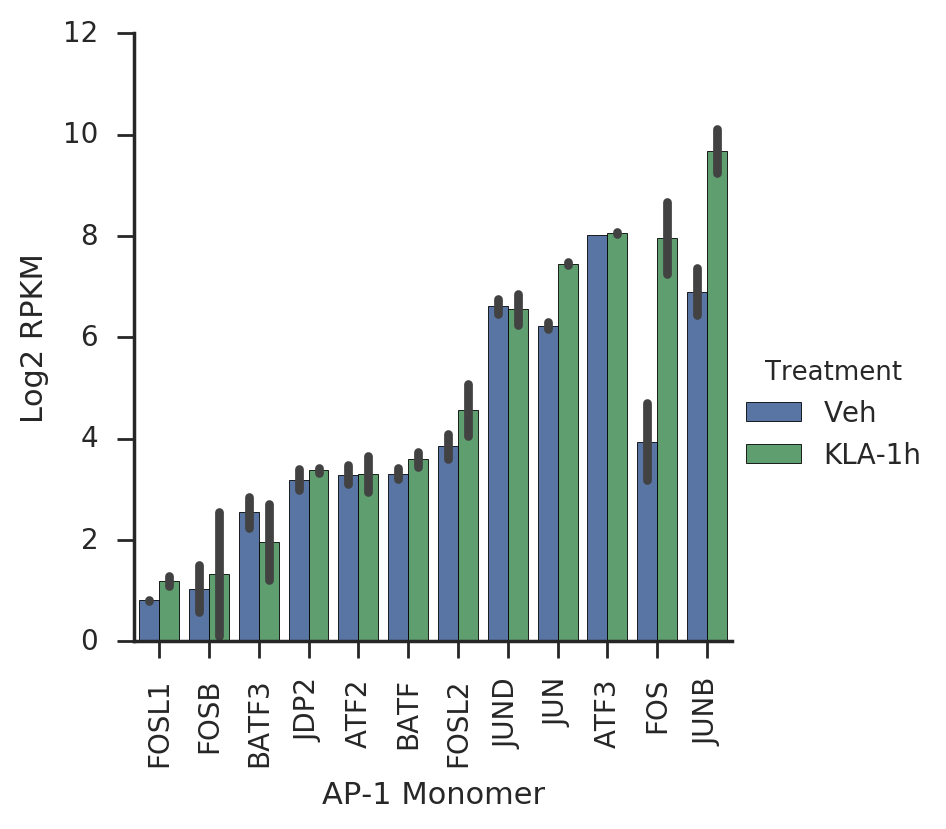

In [15]:
# from AP-1 as a regulator of cell life and death
# Jun (c-Jun, JunB, JunD), 
# Fos (c-Fos, FosB, Fra-1 and Fra2), 
# Maf (c-Maf, MafB, MafA, MafG/F/K and Nrl) and 
# ATF (ATF2, LRF1/ATF3, B-ATF, JDP1, JDP2) 
# BATF3 and JDP1 are the same thing
gene_list = ['JUN' , 'JUNB', 'JUND',
             'FOS', 'FOSL1', 'FOSL2', 'FOSB',
#              'MAF', 'MAFA','MAFB','MAFG', 'MAFF', 'MAFK', 'NRL',
             'ATF2', 'ATF3','BATF','JDP2','BATF3'#'JDP1'
             ]
# gene_list = ['ATF3', 'FOS', 
#              'JUN' , 'JUNB', 'JUND']
plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='Gene', 
                   y='Log2 RPKM', 
                   hue='Treatment', 
                   kind='bar', 
                   order = ordered_genes,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
    plt.xlabel('AP-1 Monomer')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_a.svg', bbox_inches='tight')

### Heatmap of Vehicle Cistrome

In [ ]:
%% capture
### create tag matrix
!annotatePeaks.pl ./merged_peaks_filtered_resized.tsv mm10 -size given -d ./tag_directories_ap1/*/ ./tag_directories_strains/*/> merged_annotated_peaks_ap1.tsv

In [16]:
# average tag counts from both replicates
ap1_tag_frame = pd.read_csv('merged_annotated_peaks_ap1.tsv', sep='\t')
ap1_tag_frame.index = ap1_tag_frame.ix[:,0].values
ap1_tag_frame = ap1_tag_frame[[x for x in ap1_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in ap1_tag_frame.columns.values]
ap1_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[:5]) for x in columns]))

ap1_meanTag_dict = {}
for ft in factor_treatments:
    cleaned_ft = ft.replace('thiomac_chip_','').replace('-1h','')
    ap1_meanTag_dict[cleaned_ft] = ap1_tag_frame[[x for x in ap1_tag_frame.columns if ft in x]].mean(axis=1).values
ap1_meanTag_frame = pd.DataFrame(ap1_meanTag_dict)
ap1_meanTag_frame.index = ap1_tag_frame.index.values

### Heatmap for both Vehicle and KLA

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


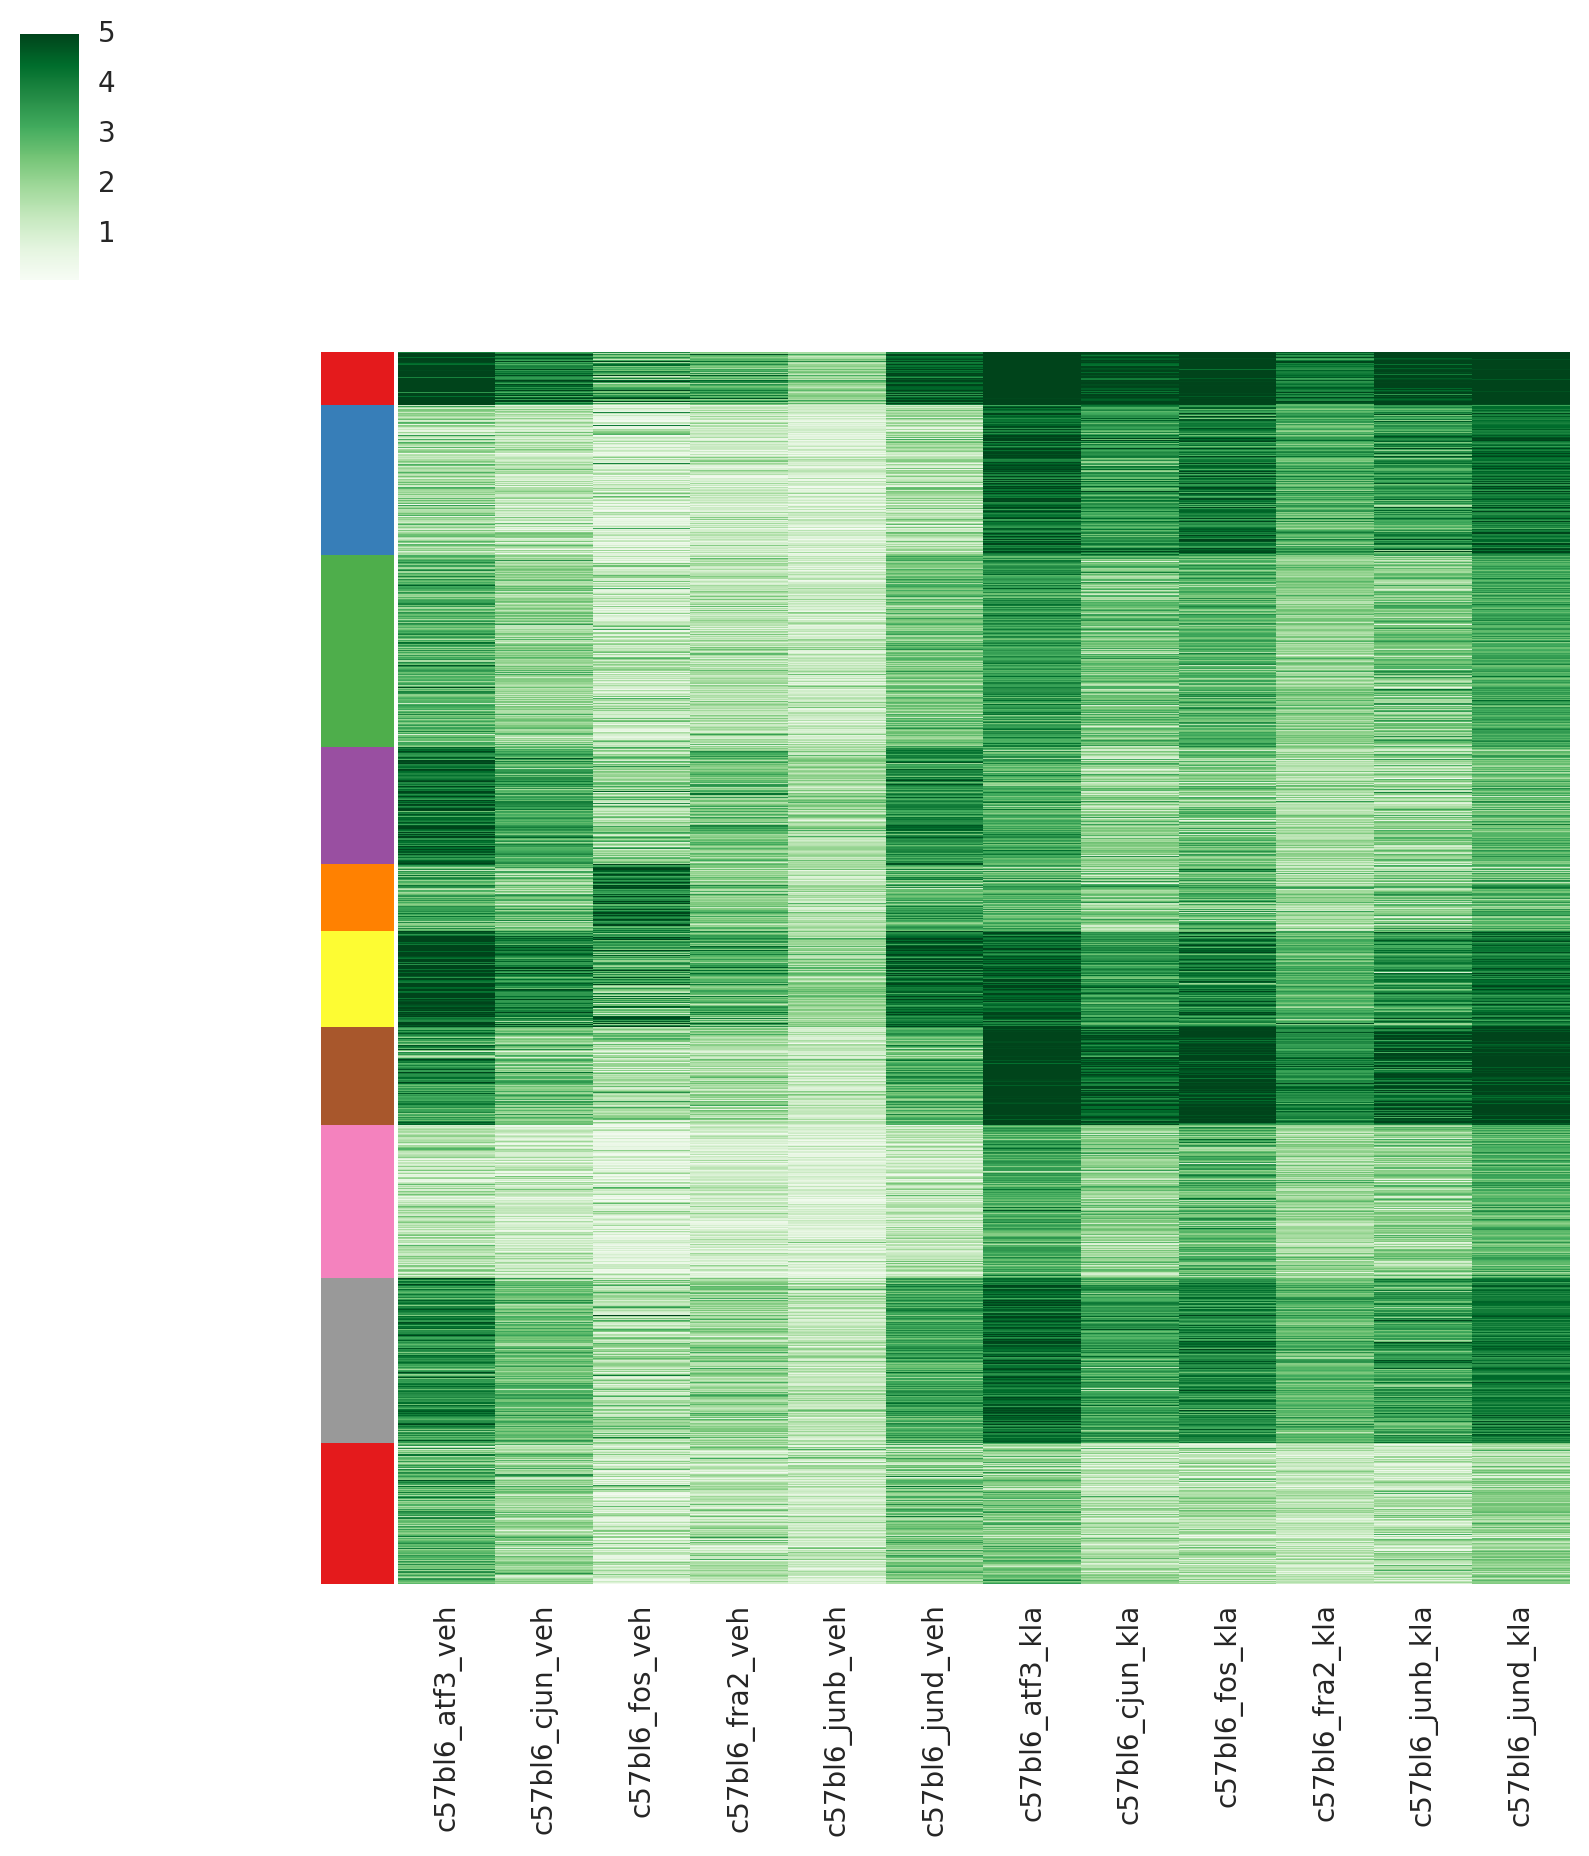

In [15]:
num_clusters = 10
strain = 'c57bl6'
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1')].index.values
ap1_normedTag_frame = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)][[]]
for treatment in ['veh','kla']:
    for factor in ['atf3','cjun', 'fos', 'fra2', 'junb', 'jund']:
        ft = strain + '_' + factor + '_' + treatment
        ap1_normedTag_frame[ft] = (ap1_meanTag_frame[ft] + 1)/(ap1_meanTag_frame[strain + '_input_'+treatment]+1)

logged_data = np.log2(ap1_normedTag_frame+1)

# fit K-means model
cluster_model = sklearn.cluster.KMeans(n_clusters = num_clusters, 
                                       random_state=0)
cluster_model.fit(logged_data)

# sort data
classes = cluster_model.predict(logged_data)
logged_data['cluster'] = classes
sorted_data = logged_data.sort('cluster', inplace=False)

# define row colors
palette = sns.color_palette("Set1", num_clusters)
color_dict = dict(zip(sorted(set(classes)), palette))
colors = [color_dict[x] for x in sorted_data['cluster'].values]
del sorted_data['cluster']

cg = sns.clustermap(sorted_data,
                    yticklabels=False,
                    xticklabels=sorted_data.columns,
                    row_colors = colors,
                    cmap='Greens',
                    col_cluster=False,
                    row_cluster = False,
                    vmax=5)

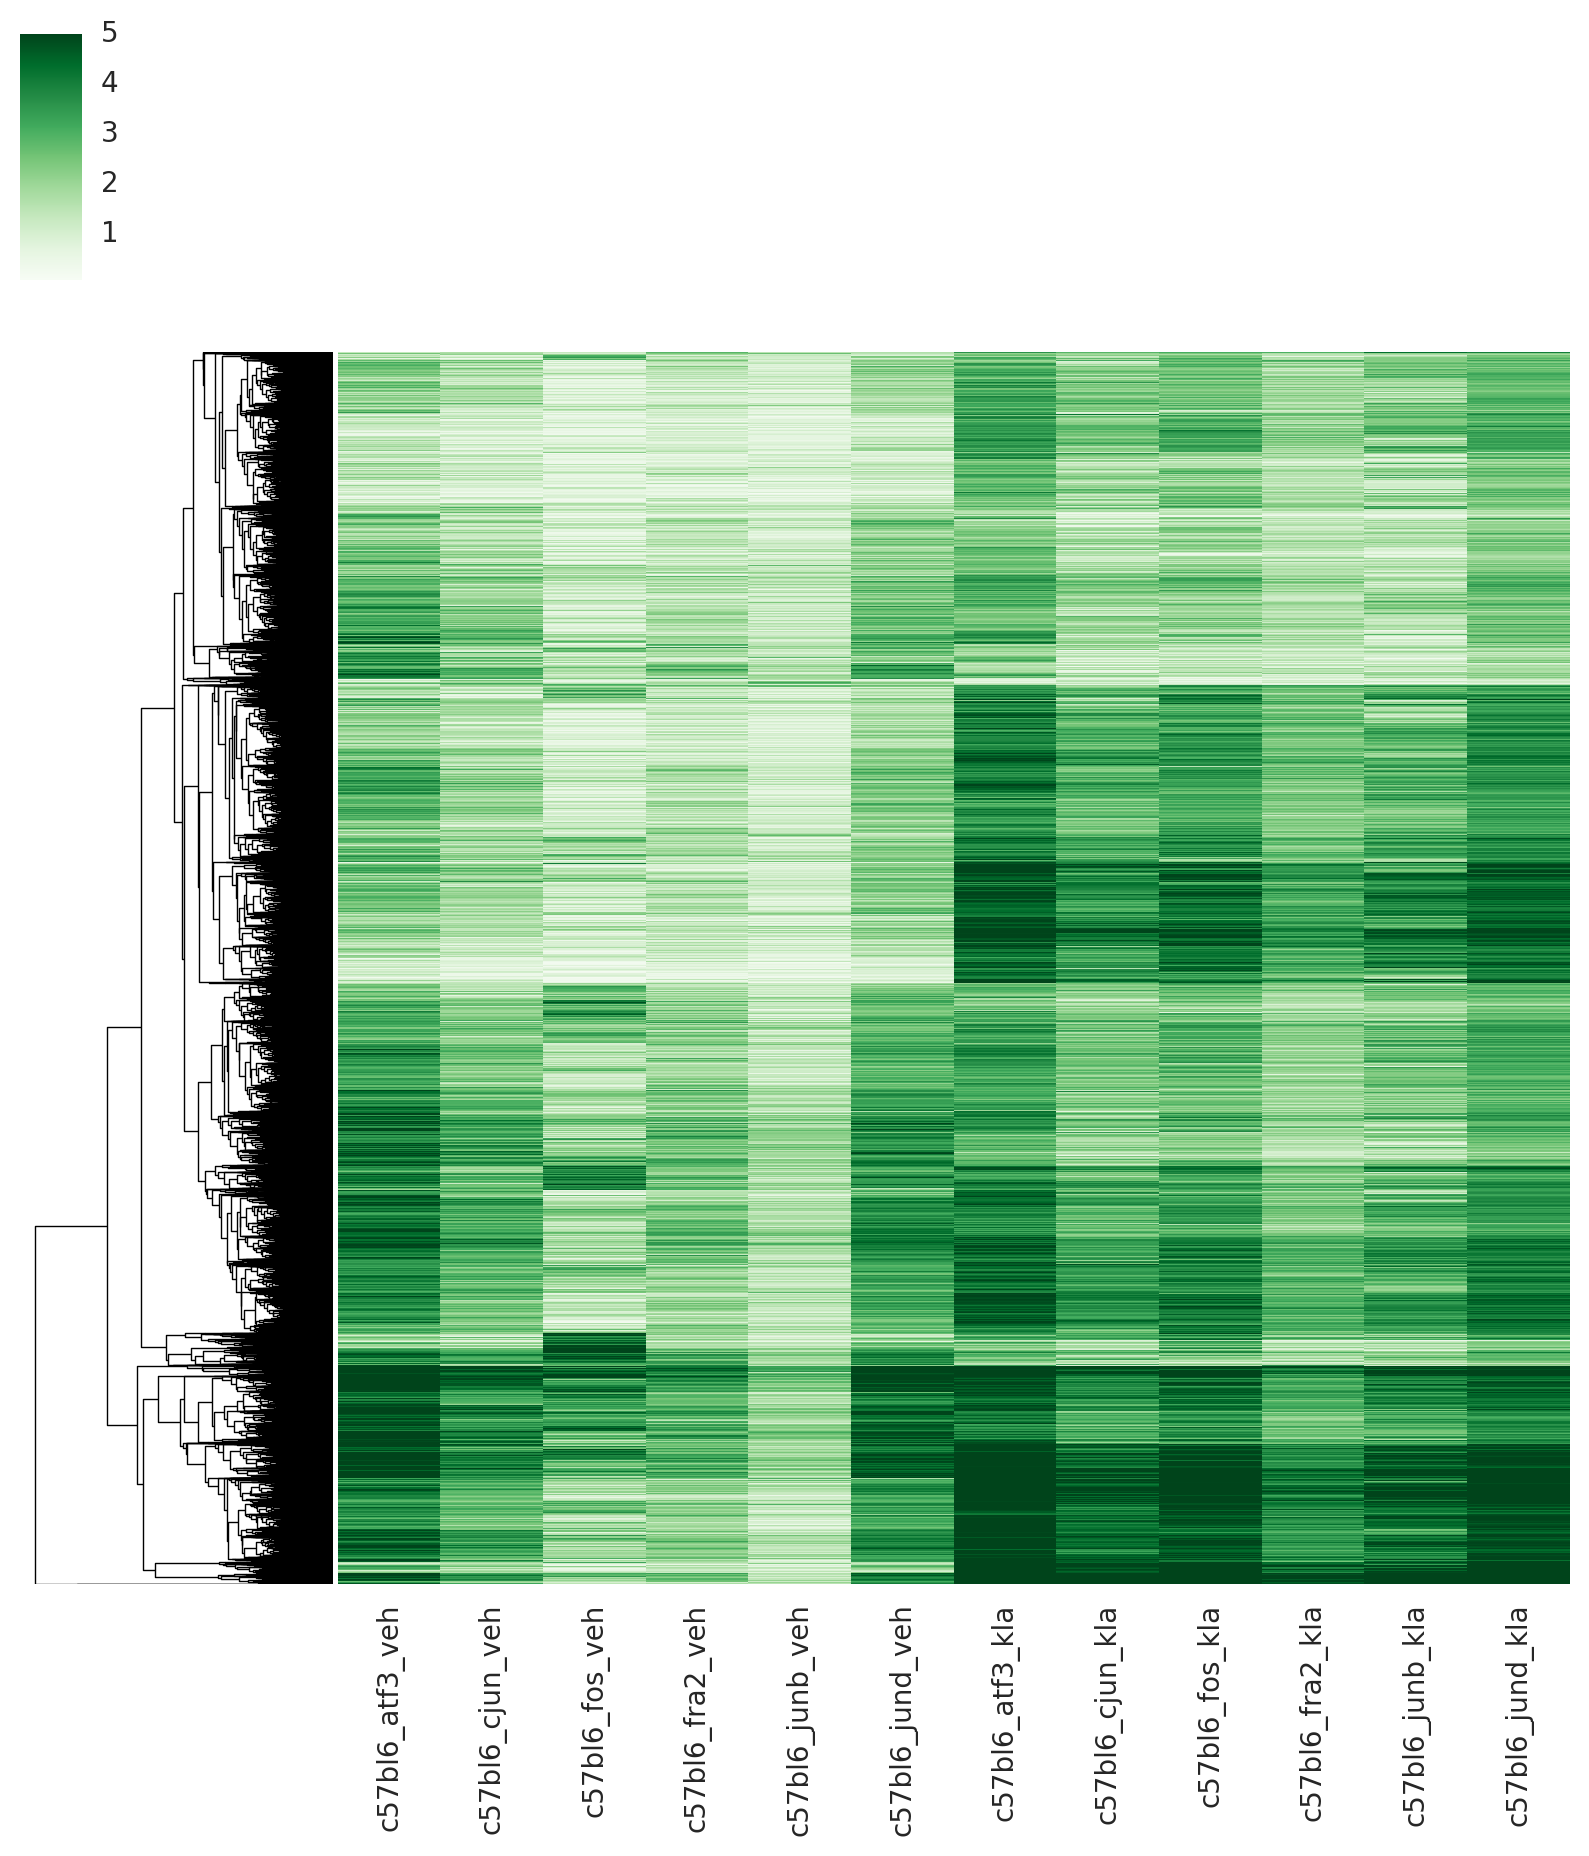

In [16]:
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1')].index.values
ap1_normedTag_frame = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)][[]]
for treatment in ['veh','kla']:
    for factor in ['atf3','cjun', 'fos', 'fra2', 'junb', 'jund']:
        ft = strain + '_' + factor + '_' + treatment
        ap1_normedTag_frame[ft] = (ap1_meanTag_frame[ft] + 1)/(ap1_meanTag_frame[strain + '_input_'+treatment]+1)

logged_data = np.log2(ap1_normedTag_frame+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=logged_data.columns,
          cmap='Greens',
          col_cluster=False,
          vmax=5)


### Barplot summarizing overlap of peaks before and after KLA

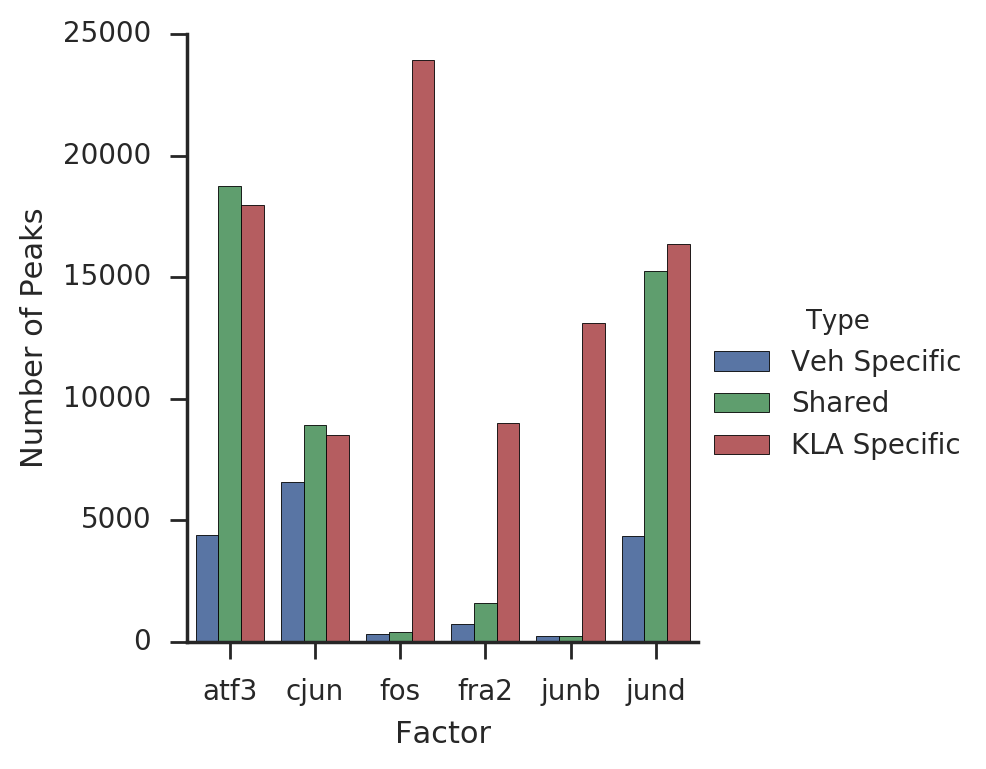

In [17]:
# ap1_members = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund']
ap1_members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
factor_list = []
count_list = []
type_list = []

veh_columns = ['c57bl6_' + x + '_veh' for x in ap1_members]
kla_columns = ['c57bl6_' + x + '_kla' for x in ap1_members]

for i in range(len(ap1_members)):
    factor = ap1_members[i]
    
        
    veh_indices = set(summary_frame[summary_frame['c57bl6_' + factor + '_veh'] > 0].index.values)
    kla_indices = set(summary_frame[summary_frame['c57bl6_' + factor + '_kla'] > 0].index.values)
        
    veh_count = len(veh_indices.difference(kla_indices))
    both_count = len(veh_indices.intersection(kla_indices))
    kla_count = len(kla_indices.difference(veh_indices))

    factor_list = factor_list + 3*[factor]
    type_list = type_list + ['Veh Specific', 'Shared', 'KLA Specific']
    count_list.append(veh_count)
    count_list.append(both_count)
    count_list.append(kla_count)
    
plotting_frame = pd.DataFrame({'Factor':factor_list,
                              'Type':type_list,
                              'Number of Peaks': count_list})
with sns.axes_style('ticks'):
    sns.factorplot(data=plotting_frame, 
                   x = 'Factor',
                   y = 'Number of Peaks',
                   hue = 'Type',
                   hue_order = ['Veh Specific', 'Shared', 'KLA Specific'],
                   kind = 'bar')

    plt.savefig('./figures/figure_01_d.png', bbox_inches='tight')
    plt.savefig('./figures/figure_01_d.svg', bbox_inches='tight')

### Phylogeny of AP-1 Monomers

In [ ]:
# protein tree built with clustalW
# run code on local machine with python 2.7 and et3 installed
# import ete3
# with open("/Users/jenhantao/Downloads/protein_tree.txt") as f:
#     data = f.readlines()
# tree_string = ''.join([x.strip() for x in data])
# tree = ete3.Tree(tree_string)
# ts = ete3.TreeStyle()
# ts.show_leaf_name = True
# ts.mode = "c"
# ts.arc_start = 0 
# ts.arc_span = 180
# # tree.show(tree_style=ts)
# tree.render("/Users/jenhantao/Desktop/tree_round.pdf", w=3,h=3, dpi=200, units="in",tree_style=ts)
# tree.render("/Users/jenhantao/Desktop/tree_default.pdf", w=3,h=3, dpi=200, units="in")

# Figure 2 

### Browser shot for overlapping dimers

In [ ]:
atf3_labels = summary_frame['Factors'].str.contains('c57bl6_atf3_veh')
jund_labels = summary_frame['Factors'].str.contains('c57bl6_jund_veh')

cjun_labels = summary_frame['Factors'].str.contains('c57bl6_cjun_veh')
fos_labels = summary_frame['Factors'].str.contains('c57bl6_fos_veh')

In [ ]:
summary_frame[~cjun_labels & ~fos_labels & atf3_labels & jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_atf3_veh', ascending=False)

In [ ]:
summary_frame[cjun_labels & fos_labels & ~atf3_labels & ~jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort_values(by='c57bl6_fos_veh', ascending=False)

### Browser shot for nonoverlapping dimers

In [ ]:
summary_frame[cjun_labels & fos_labels & atf3_labels & jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_fos_veh', ascending=False)

### - De Novo Motif Analysis

In [396]:
%%bash
### create motif analysis directories
if [ ! -d ./denovo_motif_analysis ]; 
then 
    # make directories for peaks
    mkdir ./denovo_motif_analysis;
    mkdir ./denovo_motif_analysis/veh_peaks;
    mkdir ./denovo_motif_analysis/kla_peaks;
    mkdir ./denovo_motif_analysis/veh_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/kla_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/veh_monomers_peaks;
    mkdir ./denovo_motif_analysis/kla_monomers_peaks;
    
    # make directories for motif analysis
    mkdir ./denovo_motif_analysis/veh_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_monomers;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_monomers;
    
    # make directories for top motifs
    mkdir ./denovo_motif_analysis/top_motifs_kla_overlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_overlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_nonoverlapping;
    mkdir ./denovo_motif_analysis/top_motifs_kla_nonoverlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_monomers;
    mkdir ./denovo_motif_analysis/top_motifs_kla_monomers;
else
    rm -rf ./denovo_motif_analysis/*/*
fi


### For overlapping dimer and monomer peaks

In [397]:
### create peak files for denovo motif
peak_threshold = 50 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']

for treatment in ['veh', 'kla']:
    for i in range(len(factors)):
        factor1 = 'c57bl6_'+factors[i] + '_' + treatment
        for j in range(i, len(factors)):
            factor2 = 'c57bl6_'+ factors[j] + '_' + treatment

            if factor1 == factor2:
                outputPath = './denovo_motif_analysis/' + treatment + '_monomers_peaks/' + factor1 + '_peaks.tsv'

                current_frame = summary_frame[(summary_frame[factor1] > 0)]
            else:
                outputPath = './denovo_motif_analysis/' + treatment + '_peaks/' + factor1 + '_' + factor2 + '_peaks.tsv'
                current_frame = summary_frame[(summary_frame[factor1]> 0) &
                                             (summary_frame[factor2] > 0)]
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                outputPath = outputPath.replace('c57bl6_','')
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [398]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 8 -S 25 &
    
done



	Position file = ./denovo_motif_analysis/veh_peaks/atf3_veh_fos_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_overlapping/atf3_veh_fos_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_peaks/atf3_veh_fra2_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_overlapping/atf3_veh_fra2_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs

	Position file = ./denovo_motif_analysis/veh_peaks/cjun_veh_junb_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_overlapping/cjun_veh_junb_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs
	Found mset for "m

In [399]:
%%bash
for peakFile in ./denovo_motif_analysis/kla_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 8 -S 25 &
done


	Position file = ./denovo_motif_analysis/kla_peaks/cjun_kla_junb_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_overlapping/cjun_kla_junb_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_peaks/atf3_kla_fos_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_overlapping/atf3_kla_fos_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_peaks/fos_kla_jund_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_overlapping/fos_kla_jund_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mou

In [400]:
%%bash
rm -rf ./denovo_motif_analysis/veh_motif_analysis_monomers/*
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_monomers/${peakName} -size 200 -len 8 -p 8 -S 25 &
    
done


	Position file = ./denovo_motif_analysis/veh_monomers_peaks/fra2_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_monomers/fra2_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_monomers_peaks/jund_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_monomers/jund_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_monomers_peaks/junb_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_monomers/junb_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebra

In [401]:
%%bash
rm -rf ./denovo_motif_analysis/kla_motif_analysis_monomers/*
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_monomers/${peakName} -size 200 -len 8 -p 8 -S 25 &
    
done


	Position file = ./denovo_motif_analysis/kla_monomers_peaks/junb_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_monomers/junb_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_monomers_peaks/atf3_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_monomers/atf3_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_monomers_peaks/fra2_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_monomers/fra2_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebra

### For nonoverlapping dimer peaks

In [402]:
### create peak files for denovo motif analysis 
peak_threshold = 50 # minimum number of peaks required for running motif analysis

factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    


for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

for treatment in ['veh', 'kla']:
    c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in ap1_members]
    for i in range(len(factorPairs)):
        monomer1 = factorPairs[i][0] + '_' + treatment
        monomer2 = factorPairs[i][1] + '_' + treatment
            
        outputPath = './denovo_motif_analysis/' + treatment + '_nonoverlapping_peaks/' + \
            '-'.join(factorPairs[i]).replace('c57bl6_','') + '_nonoverlapping_peaks.tsv'
            
        current_frame = summary_frame[(summary_frame[[monomer1, monomer2]].sum(axis=1) == summary_frame[c57bl6_columns].sum(axis=1))
                                     & (summary_frame[monomer1] > 0) & (summary_frame[monomer2] > 0)]
        if current_frame.shape[0] >= peak_threshold:
            print(factorPairs[i], current_frame.shape)
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

('c57bl6_atf3', 'c57bl6_cjun') (1779, 40)
('c57bl6_atf3', 'c57bl6_jund') (4789, 40)


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('c57bl6_cjun', 'c57bl6_jund') (955, 40)
('c57bl6_atf3', 'c57bl6_cjun') (398, 40)
('c57bl6_atf3', 'c57bl6_fos') (1186, 40)
('c57bl6_atf3', 'c57bl6_junb') (165, 40)
('c57bl6_atf3', 'c57bl6_jund') (4982, 40)
('c57bl6_cjun', 'c57bl6_fos') (66, 40)
('c57bl6_cjun', 'c57bl6_jund') (249, 40)
('c57bl6_fos', 'c57bl6_junb') (88, 40)
('c57bl6_fos', 'c57bl6_jund') (809, 40)
('c57bl6_junb', 'c57bl6_jund') (94, 40)


### for non overlappinng monomer peaks

In [403]:
### create peak files for denovo motif analysis 
peak_threshold = 50 # minimum number of peaks required for running motif analysis
strain = 'c57bl6'
factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

for treatment in ['veh', 'kla']:
    c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in ap1_members]
    for i in range(len(ap1_members)):
        monomer1 = strain + '_' +ap1_members[i] + '_' + treatment
            
        outputPath = './denovo_motif_analysis/' + treatment + '_nonoverlapping_peaks/' + \
            ap1_members[i].replace('c57bl6_','') + '_nonoverlapping_peaks.tsv'
            
        current_frame = summary_frame[(summary_frame[[monomer1]].sum(axis=1) == summary_frame[c57bl6_columns].sum(axis=1))
                                     & (summary_frame[monomer1] > 0)]
        if current_frame.shape[0] >= peak_threshold:
            print(ap1_members[i], current_frame.shape)
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

atf3 (5938, 40)
cjun (2230, 40)


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


fos (362, 40)
junb (147, 40)
jund (3271, 40)
atf3 (7124, 40)
cjun (420, 40)
fos (1512, 40)
junb (260, 40)
jund (2704, 40)


In [404]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 8 -S 25 &
done

for peakFile in ./denovo_motif_analysis/kla_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 8 -S 25 &
done


	Position file = ./denovo_motif_analysis/veh_nonoverlapping_peaks/jund_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/jund_nonoverlapping
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_nonoverlapping_peaks/junb_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/junb_nonoverlapping
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 25 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_nonoverlapping_peaks/cjun-fos_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/cjun-fos_nonoverlapping
	Fragment size set to 200
	Motif length 

## Schematic showing top motif analysis for all overlapping dimer sites

In [28]:
def combineTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir):
    if not os.path.isdir(scanning_results_dir):
        os.mkdir(scanning_results_dir)
   
    combinedFile = open(scanning_results_dir + '/combined.motif', 'w')

    # for each denovo motif analysis result for each monomer
    for monomer_result_dir in os.listdir(denovo_result_dir):
        for i in range(1, numMotifs+1):
            # construct path to motifs 1 through numMotifs
            motif_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.motif'
            # read in motif file
            if os.path.isfile(motif_path):
                with open(motif_path) as f:
                    data = f.readlines()

                # change motif header
                headerTokens = data[0].split('\t')
                newMotifName = monomer_result_dir + '_' + str(i) + ',' + headerTokens[1].split(',')[1]
                headerTokens[1] = newMotifName

                newHeader = '\t'.join(headerTokens)

                # write motif into combined file
                combinedFile.write(newHeader)
                for line in data[1:]: # skip header line
                    combinedFile.write(line)
    combinedFile.close()

In [29]:
numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/veh_motif_analysis_monomers/'
scanning_results_dir = './denovo_motif_analysis/veh_motif_scanning/'
combineTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir)

numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/kla_motif_analysis_monomers/'
scanning_results_dir = './denovo_motif_analysis/kla_motif_scanning/'
combineTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir)



In [30]:
def copyTopMotifLogos(numMotifs, denovo_result_dir, output_dir):
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    else:
        for f in os.listdir(output_dir):
            os.remove(output_dir + '/' + f)

    # for each denovo motif analysis result for each monomer
    for monomer_result_dir in os.listdir(denovo_result_dir):
        for i in range(1, numMotifs+1):
            # construct path to motifs 1 through numMotifs
            motif_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.logo.png'
            # read in motif file
            if os.path.isfile(motif_path):
                newMotifName = monomer_result_dir + '_' + str(i) + '.logo.png'
                os.system('cp ' +motif_path + ' '+ output_dir +'/' + newMotifName)


In [35]:
numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/veh_motif_analysis_monomers/'
veh_logo_path = './denovo_motif_analysis/veh_motif_scanning_logos/'
copyTopMotifLogos(numMotifs, denovo_result_dir, veh_logo_path)

numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/kla_motif_analysis_monomers/'
kla_logo_path = './denovo_motif_analysis/kla_motif_scanning_logos/'
copyTopMotifLogos(numMotifs, denovo_result_dir, kla_logo_path)




In [409]:
%%bash
### scan for top denovo motifs
rm -rf ./denovo_motif_analysis/veh_motif_scanning/*/
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_scanning/${peakName} -nomotif -mknown ./denovo_motif_analysis/veh_motif_scanning/combined.motif -size 200 -p 8 &
    
done

rm -rf ./denovo_motif_analysis/kla_motif_scanning/*/
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_scanning/${peakName} -nomotif -mknown ./denovo_motif_analysis/kla_motif_scanning/combined.motif -size 200 -p 8 &
    
done


	Position file = ./denovo_motif_analysis/kla_monomers_peaks/jund_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_scanning/jund_kla
	Will not run homer for de novo motifs
	Will search for known motifs in file: ./denovo_motif_analysis/kla_motif_scanning/combined.motif
	Fragment size set to 200
	Using 8 CPUs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_monomers_peaks/cjun_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_scanning/cjun_veh
	Will not run homer for de novo motifs
	Will search for known motifs in file: ./denovo_motif_analysis/veh_motif_scanning/combined.motif
	Fragment size set to 200
	Using 8 CPUs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_monomers_peaks/fos_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_scanning/fos_kla
	Will not run homer for

In [32]:
def combineKnownMotifResults(scanning_results_dir):
    sorted_motif_names = None
    monomer_fractions_dict = {}
    for result_dir in os.listdir(scanning_results_dir):
        if os.path.isdir(scanning_results_dir + '/' + result_dir):
            knownResults_path = scanning_results_dir + '/' + result_dir + '/knownResults.txt'
            knownResults_frame = pd.read_csv(knownResults_path, sep='\t')
            motif_names = knownResults_frame['Motif Name'].values
            if sorted_motif_names == None:
                sorted_motif_names = sorted(motif_names)

            string_target_fractions = knownResults_frame['% of Target Sequences with Motif'].values
            target_fractions = np.array([float(x[:-1]) for x in string_target_fractions])

            string_background_fractions = knownResults_frame['% of Background Sequences with Motif'].values
            background_fractions = np.array([float(x[:-1]) for x in string_background_fractions])

            enrichment = target_fractions/background_fractions
            # sort fractions by motif name
            name_fraction_dict =  dict(zip(motif_names, target_fractions))
            sorted_fractions = [name_fraction_dict[x] for x in sorted_motif_names]

            monomer_fractions_dict[result_dir] = sorted_fractions
    monomer_fractions_frame = pd.DataFrame(monomer_fractions_dict, 
                                           index = [x.split(',')[0] for x in sorted_motif_names])
    monomer_fractions_frame['Best Match'] = [x.split(',')[1].split('/')[0].split(':')[1] for x in sorted_motif_names]
    return monomer_fractions_frame

In [33]:
# combine motif scanning results into one table
scanning_results_dir = './denovo_motif_analysis/veh_motif_scanning/'

veh_monomer_fractions_frame = combineKnownMotifResults(scanning_results_dir)

scanning_results_dir = './denovo_motif_analysis/kla_motif_scanning/'

kla_monomer_fractions_frame = combineKnownMotifResults(scanning_results_dir)

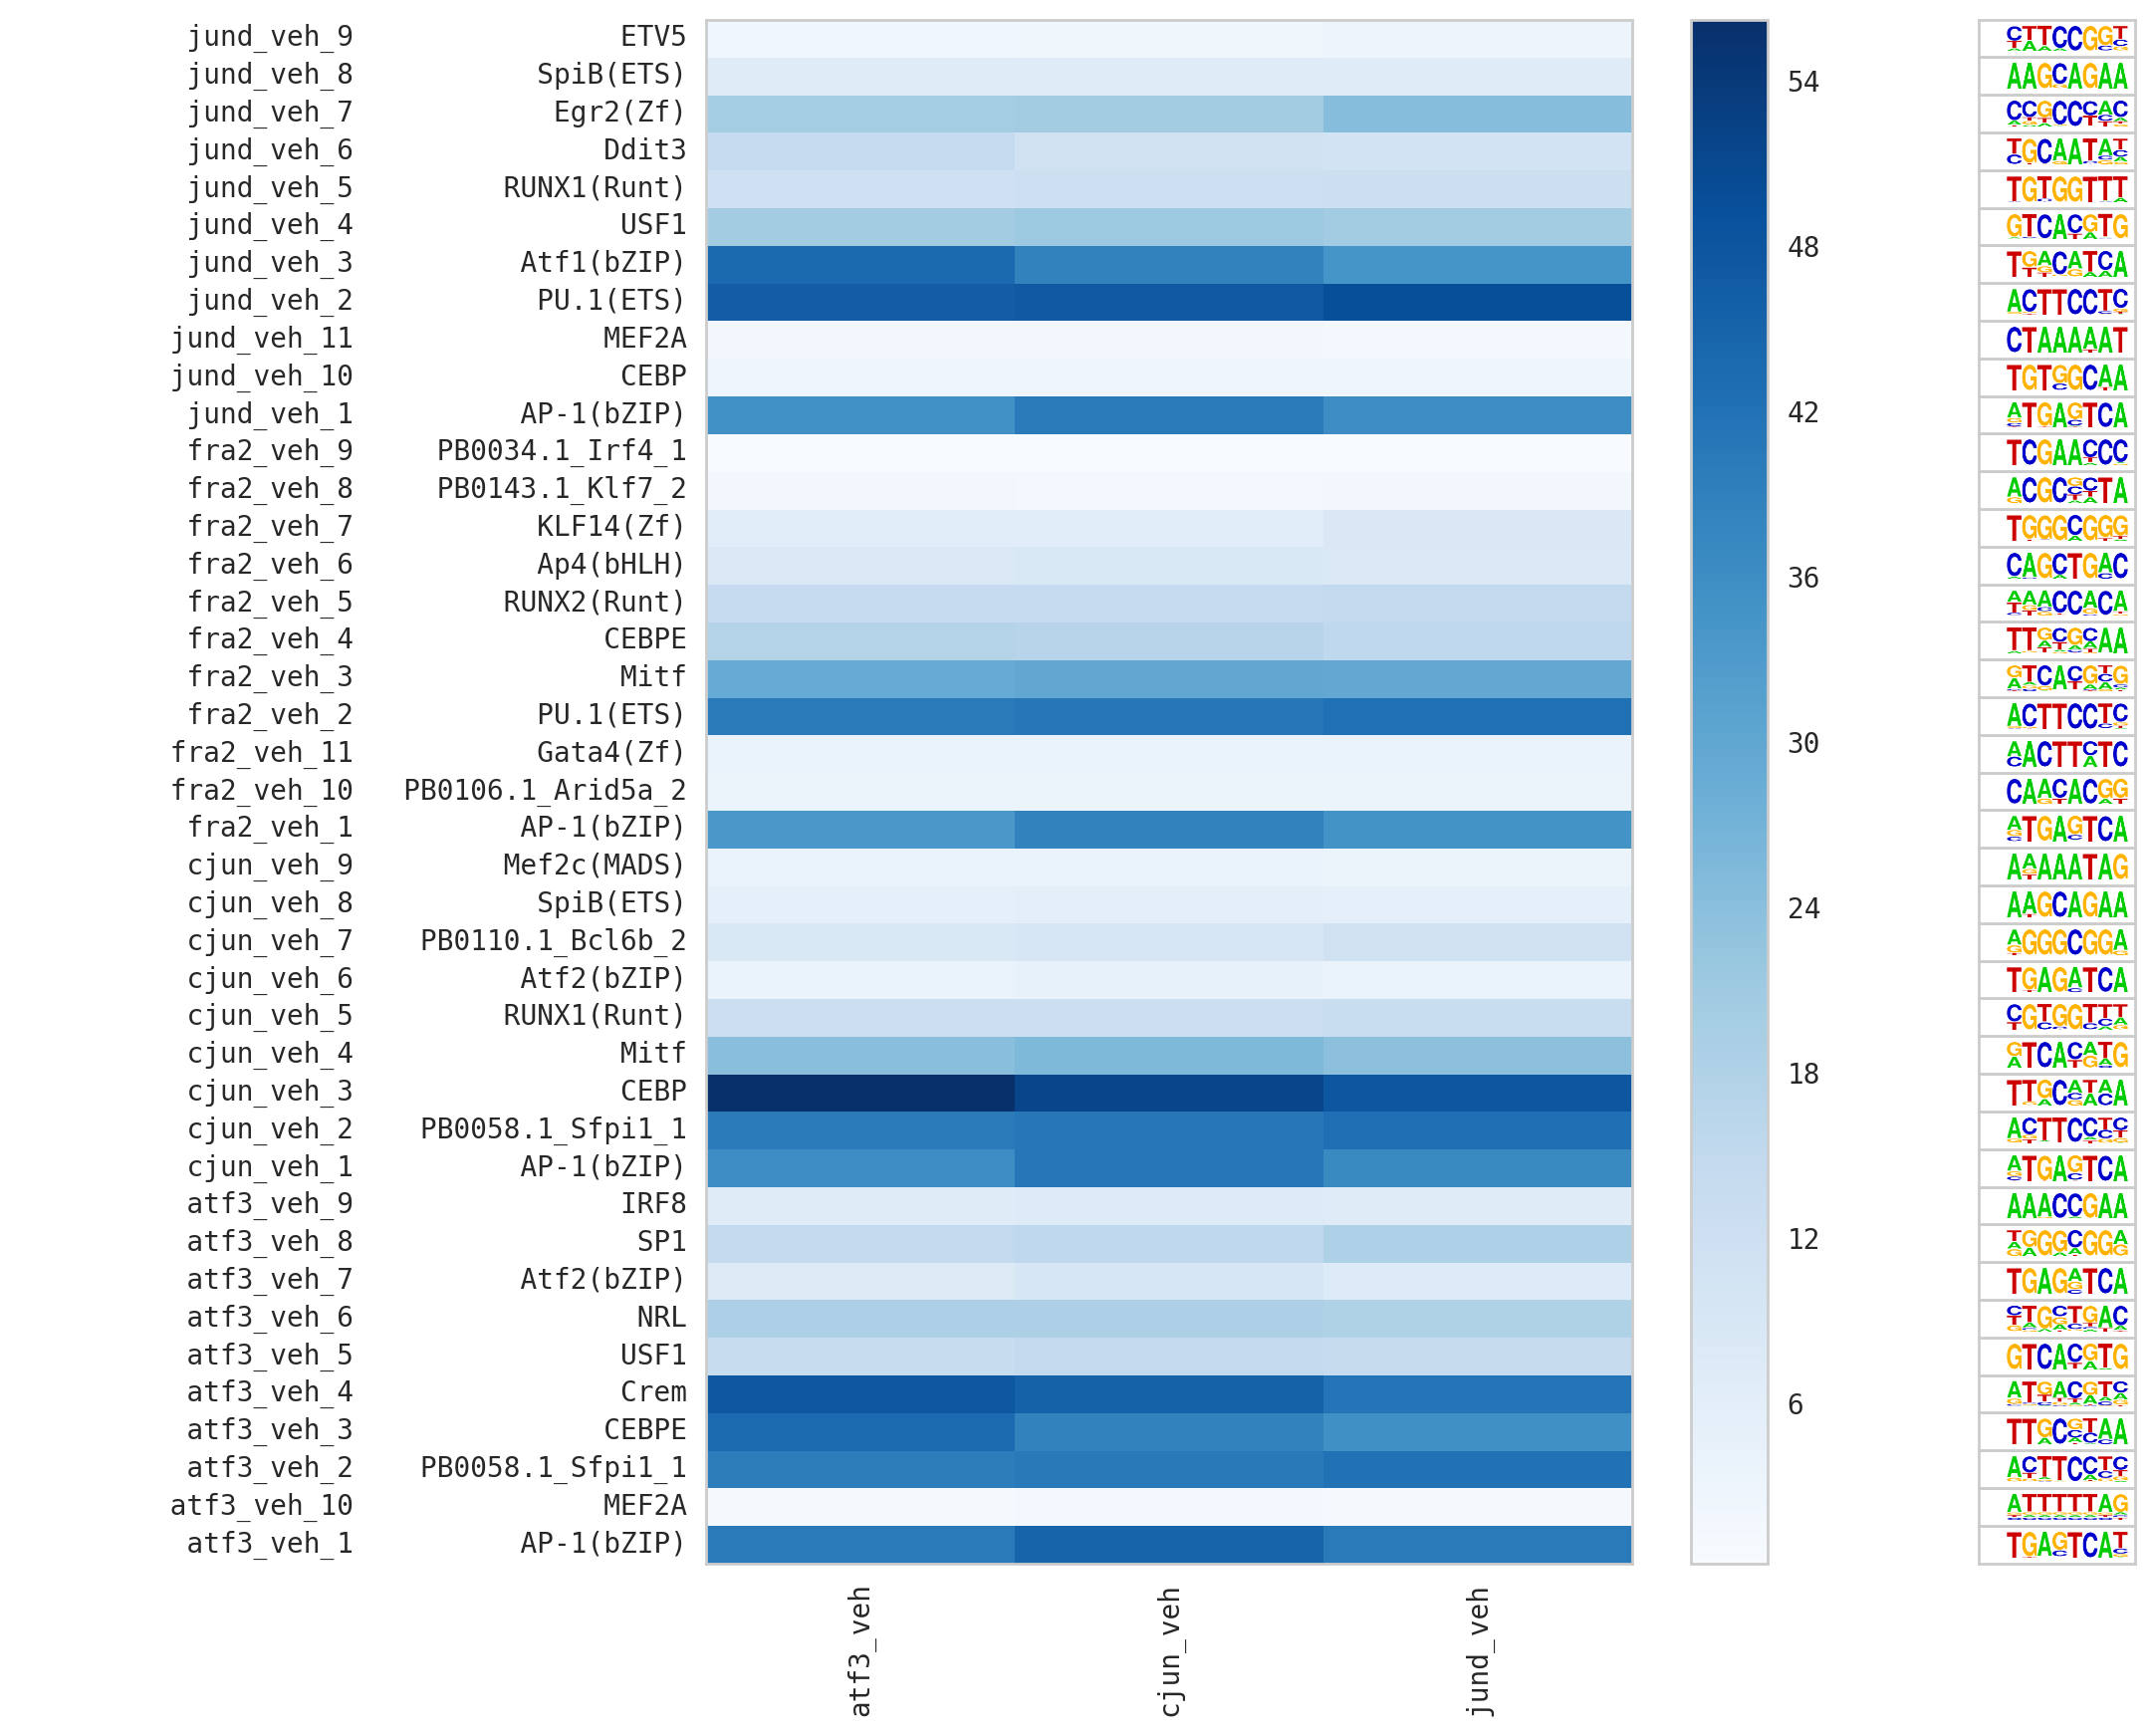

In [36]:
monomers = ['atf3_veh', 'cjun_veh', 'jund_veh']
text_padding=20
with sns.axes_style('whitegrid', {'font.family':'monospace'}):
    
    fig = plt.figure(figsize=(10,10))

    data = veh_monomer_fractions_frame.ix[[x for x in veh_monomer_fractions_frame.index.values if not 'junb' in x and not 'fos' in x],: 
                                        ]
    numRows = data.shape[0]
    gs = matplotlib.gridspec.GridSpec(numRows, len(monomers) + 1, wspace=0.0, hspace=0.0)
    
    heatmap_axis = plt.subplot(gs[:,:len(monomers)])


    img = heatmap_axis.pcolor(data[monomers].values, 
                        cmap = matplotlib.cm.Blues,
#                         vmin = 0,
#                         vmax = 50
                       )
    fig.colorbar(img)
    
    
    labels = []
    for t in list(zip(data.index.values, data['Best Match'].values)):
        l = t[0].rjust(text_padding,' ') + t[1].rjust(text_padding,' ')
        labels.append(l)
    
    heatmap_axis.set_yticks(np.array(range(len(labels))) + 0.5 );
    heatmap_axis.set_yticklabels(labels, size =10);
    
    heatmap_axis.set_xticks(np.array(range(len(monomers)))+0.5)
    heatmap_axis.set_xticklabels(monomers, rotation=90)
    
    heatmap_axis.set_ylim(0,numRows)

    motif_names = data.index.values
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[numRows - 1 - i,len(monomers)])
        mn = motif_names[i]
        img = plt.imread(veh_logo_path + '/' + mn + '.logo.png')
        current_axis.imshow(img)
        current_axis.set_xticks([])
        current_axis.set_yticks([])


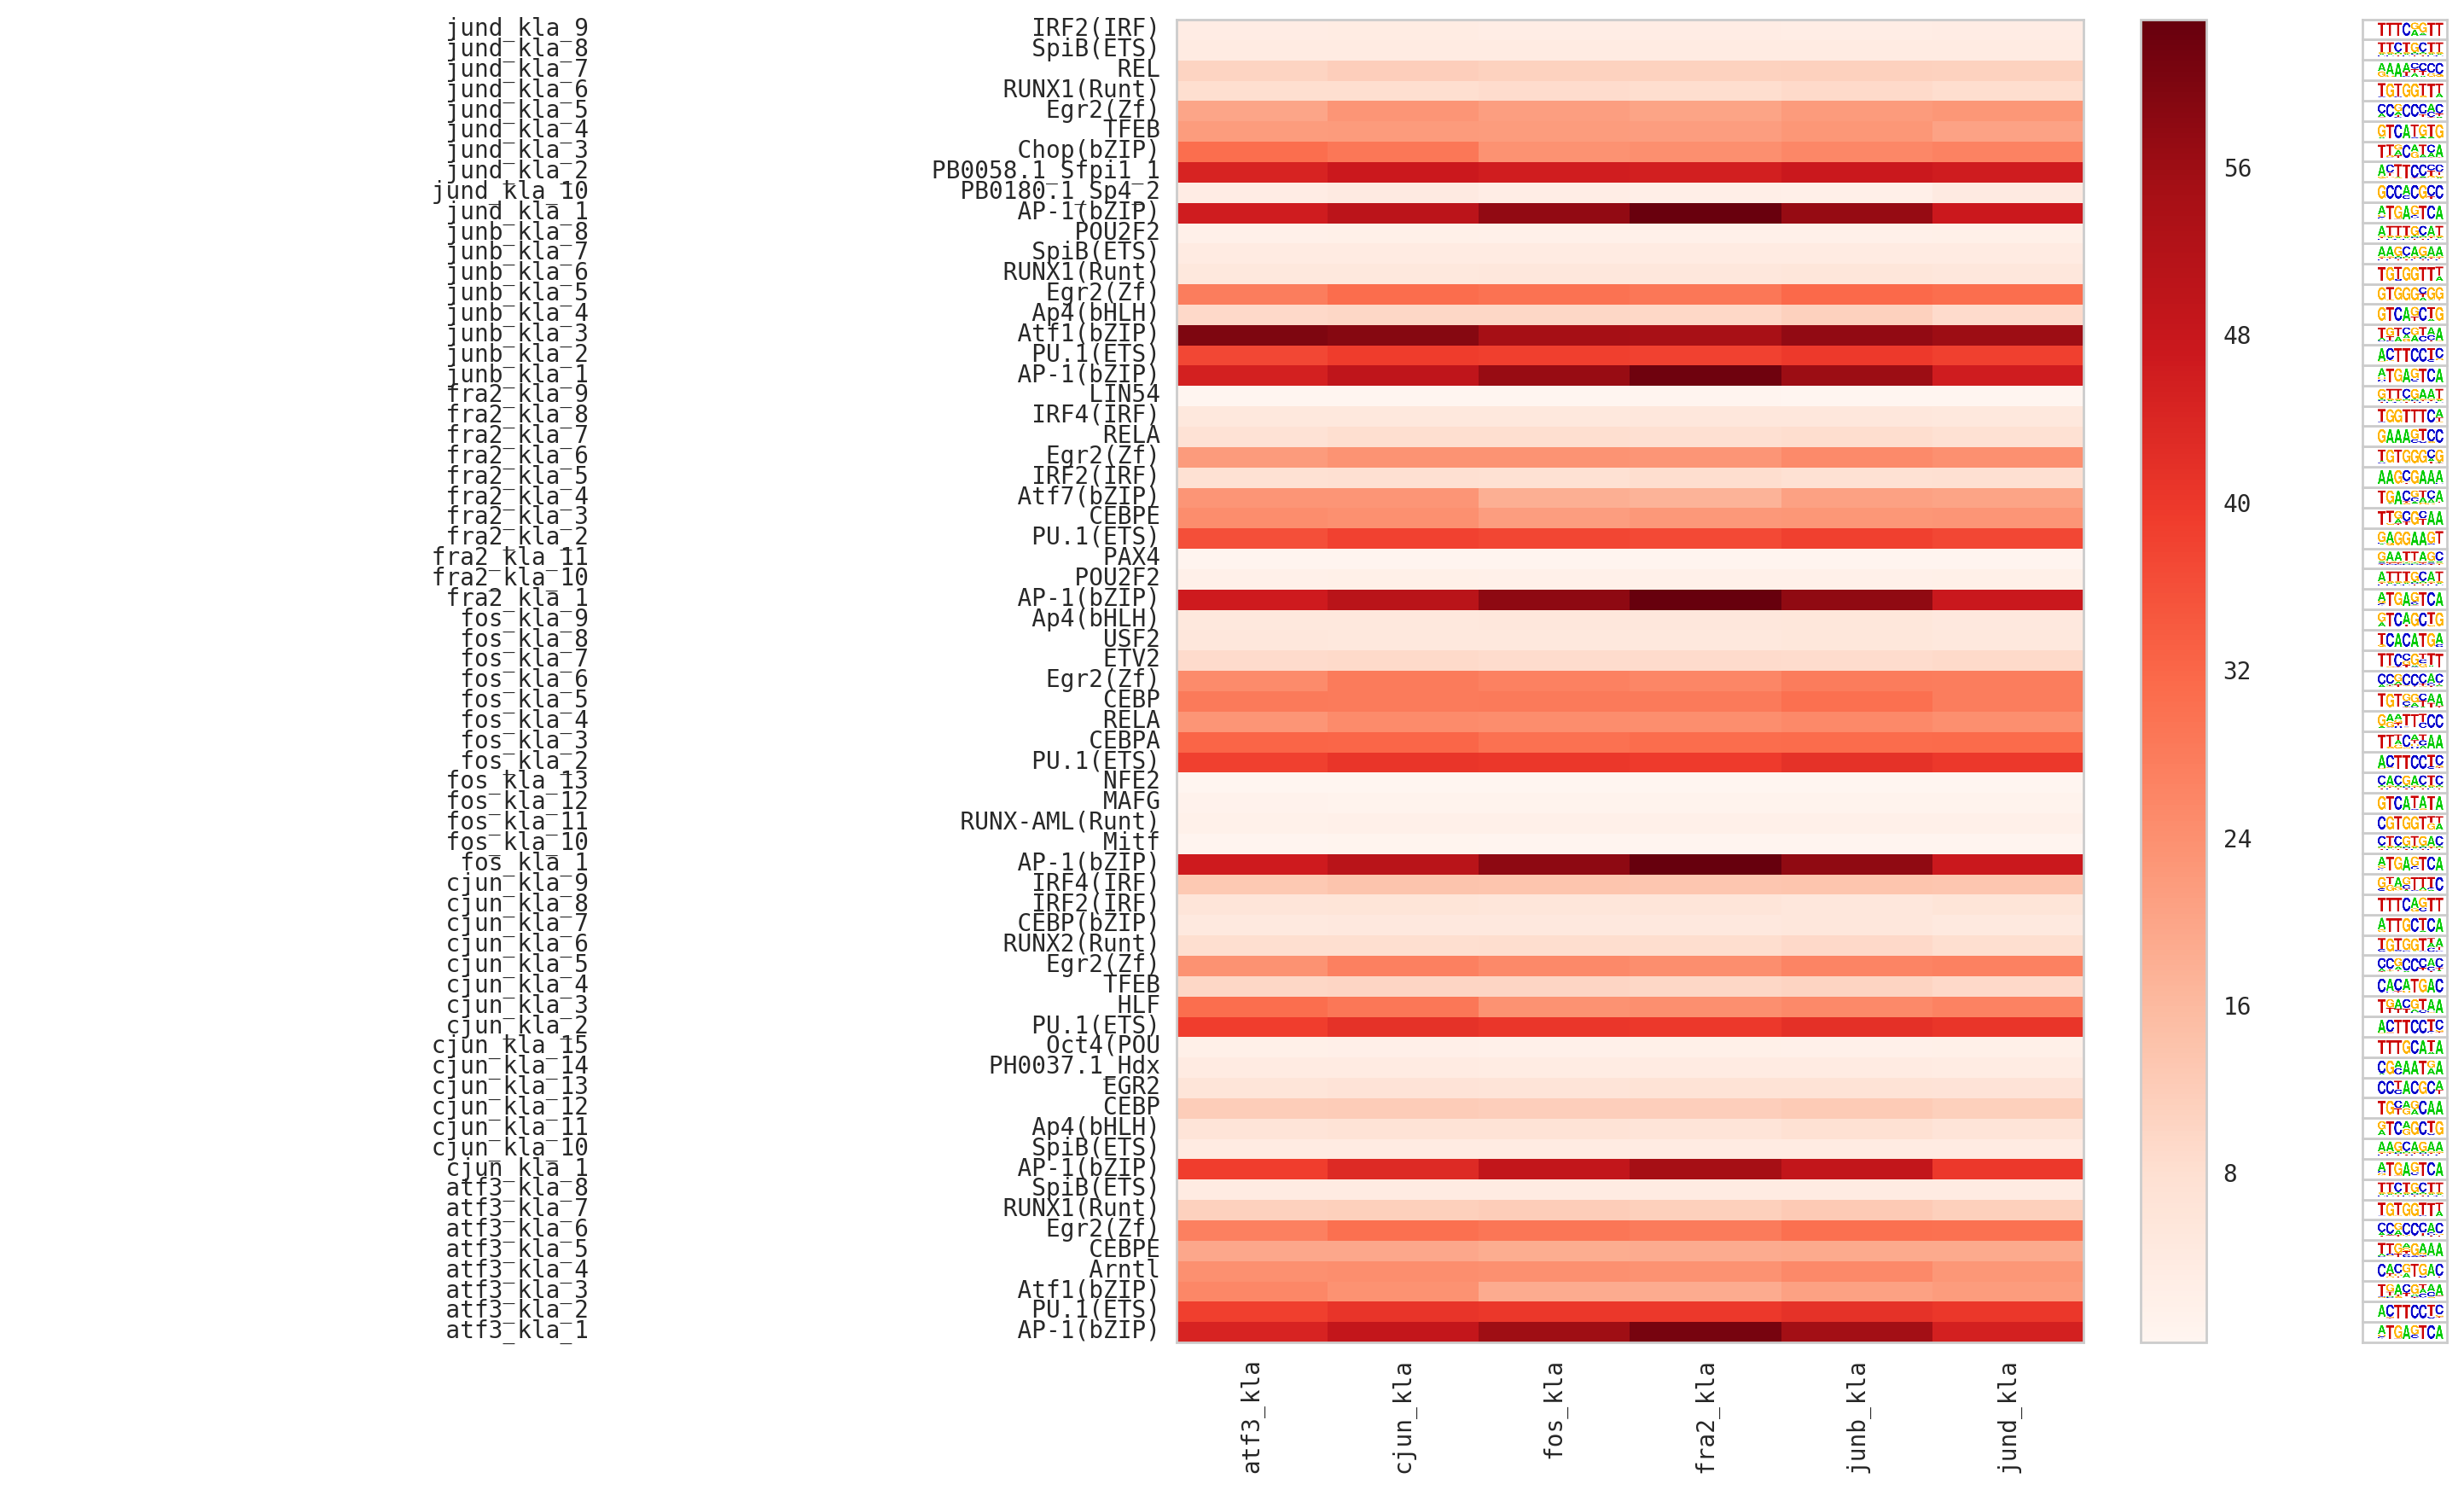

In [37]:
monomers = ['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']
text_padding = 40
with sns.axes_style('whitegrid', {'font.family':'monospace'}):
    
    fig = plt.figure(figsize=(10,10))

    data = kla_monomer_fractions_frame
    numRows = data.shape[0]
    gs = matplotlib.gridspec.GridSpec(numRows, len(monomers) + 1, wspace=0.0, hspace=0.0)
    
    heatmap_axis = plt.subplot(gs[:,:len(monomers)])

    img = heatmap_axis.pcolor(data[monomers].values, 
                        cmap = matplotlib.cm.Reds,
#                         vmin = 0,
#                         vmax = 50
                       )
    cb = fig.colorbar(img)
    
    labels = []
    for t in list(zip(data.index.values, data['Best Match'].values)):
        l = t[0].rjust(text_padding,' ') + t[1].rjust(text_padding,' ')
        labels.append(l)
    
    heatmap_axis.set_yticks(np.array(range(len(labels))) + 0.5 );
    heatmap_axis.set_yticklabels(labels, size =10);
    
    heatmap_axis.set_xticks(np.array(range(len(monomers)))+0.5)
    heatmap_axis.set_xticklabels(monomers, rotation=90)
    
    heatmap_axis.set_ylim(0,numRows)

    motif_names = data.index.values
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[numRows - 1 - i,len(monomers)])
        mn = motif_names[i]
        img = plt.imread(kla_logo_path + '/' + mn + '.logo.png')
        current_axis.imshow(img)
        current_axis.set_xticks([])
        current_axis.set_yticks([])



### Venn Diagrams

#### Vehicle

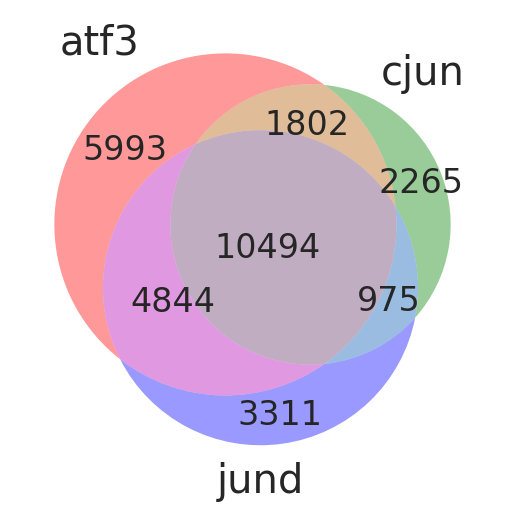

In [38]:
plt.figure(figsize=(3,3))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)
matplotlib_venn.venn3([atf3_indices, cjun_indices, jund_indices], set_labels=['atf3', 'cjun', 'jund'])
plt.savefig('./figures/figure_02_c_venn_veh.svg')
plt.savefig('./figures/figure_02_c_venn_veh.png')

### Fraction of Unique Peaks

atf3
cjun
jund


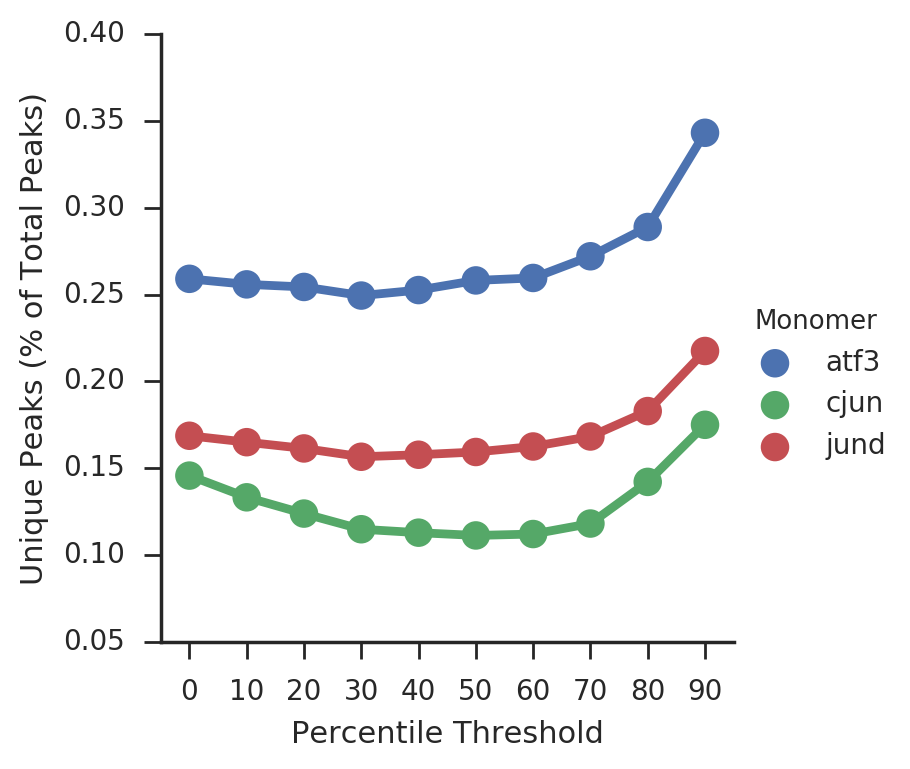

In [42]:
fraction_list = []
threshold_list = []
factor_list = []
thresholds = np.arange(0,100,10)
strain = 'c57bl6'
treatment = 'veh'
factors = ['atf3', 'cjun', 'jund']
for factor in factors:
    print(factor)
    factor_indices = set(summary_frame[summary_frame['_'.join([strain, factor, treatment])] > 0].index.values)
    factor_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(factor_indices)]['_'.join([strain, factor, treatment])]
    
    for threshold in thresholds:
        factor_threshold = np.percentile(factor_tagCounts, threshold)
        factor_filtered_indices = set(factor_tagCounts[factor_tagCounts >= factor_threshold].index.values)
        
        other_filtered_indices = set()
        for of in factors:
            if not of == factor:
                of_indices = set(summary_frame[summary_frame['_'.join([strain, of, treatment])] > 0].index.values)
                of_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(of_indices)]['_'.join([strain, of, treatment])]
                
                of_threshold = np.percentile(of_tagCounts, threshold)
                of_filtered_indices = set(of_tagCounts[of_tagCounts >= of_threshold].index.values)

                other_filtered_indices = other_filtered_indices.union(of_filtered_indices)

        factor_unique_indices = factor_filtered_indices - other_filtered_indices
        unique_fraction = len(factor_unique_indices)/len(factor_filtered_indices)
        
        fraction_list.append(unique_fraction)
        threshold_list.append(threshold)
        factor_list.append(factor)
frame = pd.DataFrame({'Unique Peaks (% of Total Peaks)':fraction_list,
                      'Percentile Threshold':threshold_list,
                      'Monomer':factor_list}, 
                     )
with sns.axes_style('ticks'):
    sns.factorplot(data=frame, x = 'Percentile Threshold', y='Unique Peaks (% of Total Peaks)', hue='Monomer')
    plt.savefig('./figures/figure_02_c_fraction_veh.png')
    plt.savefig('./figures/figure_02_c_fraction_veh.svg')



atf3
cjun
fos
fra2
junb
jund


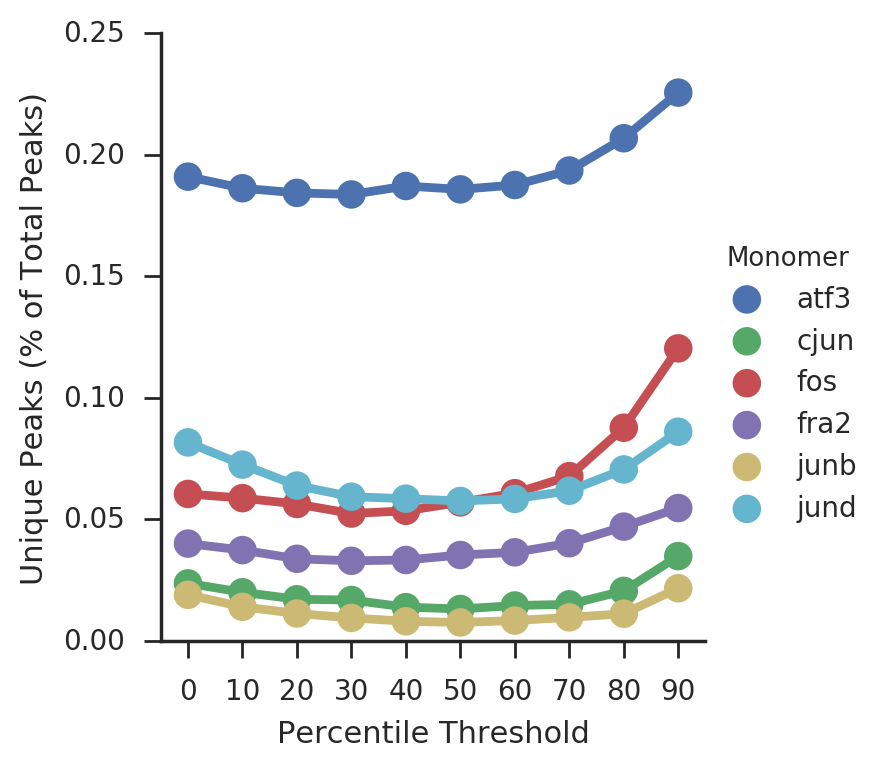

In [43]:
fraction_list = []
threshold_list = []
factor_list = []
thresholds = np.arange(0,100,10)
strain = 'c57bl6'
treatment = 'kla'
factors = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
# factors = ['atf3', 'cjun', 'jund']


for factor in factors:
    print(factor)
    factor_indices = set(summary_frame[summary_frame['_'.join([strain, factor, treatment])] > 0].index.values)
    factor_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(factor_indices)]['_'.join([strain, factor, treatment])]
    
    for threshold in thresholds:
        factor_threshold = np.percentile(factor_tagCounts, threshold)
        factor_filtered_indices = set(factor_tagCounts[factor_tagCounts >= factor_threshold].index.values)
        
        other_filtered_indices = set()
        for of in factors:
            if not of == factor:
                of_indices = set(summary_frame[summary_frame['_'.join([strain, of, treatment])] > 0].index.values)
                of_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(of_indices)]['_'.join([strain, of, treatment])]
                
                of_threshold = np.percentile(of_tagCounts, threshold)
                of_filtered_indices = set(of_tagCounts[of_tagCounts >= of_threshold].index.values)

                other_filtered_indices = other_filtered_indices.union(of_filtered_indices)

        factor_unique_indices = factor_filtered_indices - other_filtered_indices
        unique_fraction = len(factor_unique_indices)/len(factor_filtered_indices)
        
        fraction_list.append(unique_fraction)
        threshold_list.append(threshold)
        factor_list.append(factor)
frame = pd.DataFrame({'Unique Peaks (% of Total Peaks)':fraction_list,
                      'Percentile Threshold':threshold_list,
                      'Monomer':factor_list}, 
                     )
with sns.axes_style('ticks'):
    sns.factorplot(data=frame, x = 'Percentile Threshold', y='Unique Peaks (% of Total Peaks)', hue='Monomer')
    plt.ylim(0,0.25)
    plt.savefig('./figures/figure_02_c_fraction_kla.png')
    plt.savefig('./figures/figure_02_c_fraction_kla.svg')


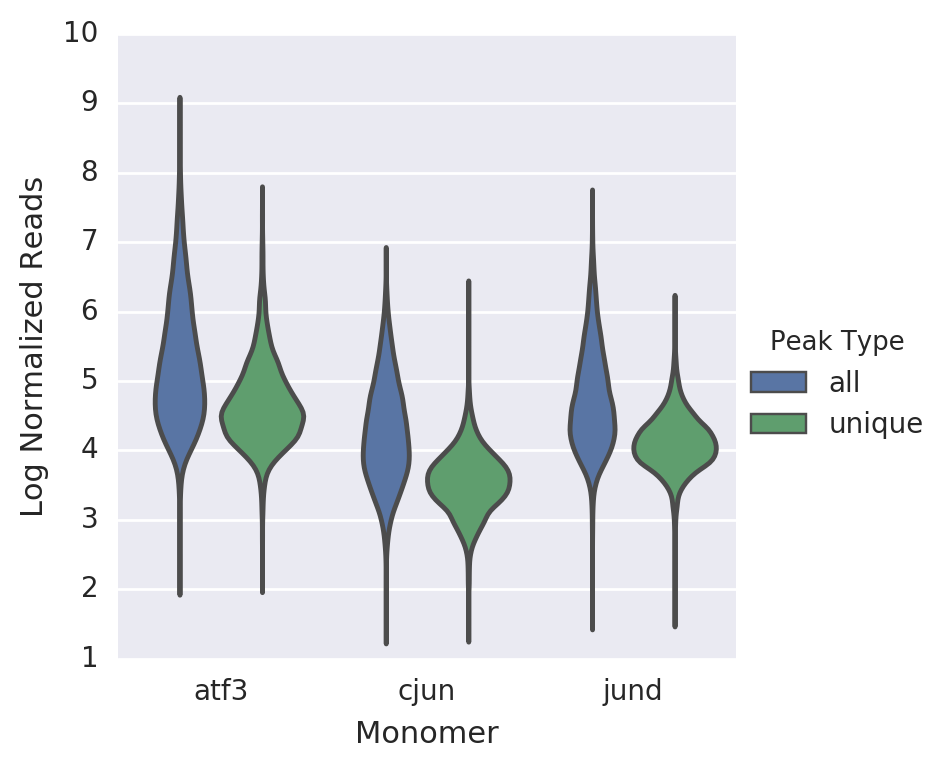

In [44]:
# tag count distribution - unique vs all other
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)

atf3_unique_indices = atf3_indices - (cjun_indices.union(jund_indices))
cjun_unique_indices = cjun_indices - (atf3_indices.union(jund_indices))
jund_unique_indices = jund_indices - (atf3_indices.union(cjun_indices))

atf3_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(atf3_indices)]['c57bl6_atf3_veh'].values)
cjun_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(cjun_indices)]['c57bl6_cjun_veh'].values)
jund_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(jund_indices)]['c57bl6_jund_veh'].values)

atf3_unique_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(atf3_unique_indices)]['c57bl6_atf3_veh'].values)
cjun_unique_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(cjun_unique_indices)]['c57bl6_cjun_veh'].values)
jund_unique_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(jund_unique_indices)]['c57bl6_jund_veh'].values)

tag_count_list = []
monomer_list = []
peakType_list = []

tag_count_list = tag_count_list + atf3_tagCounts + atf3_unique_tagCounts
monomer_list = monomer_list + (len(atf3_tagCounts) + len(atf3_unique_tagCounts)) * ['atf3']
peakType_list = peakType_list + len(atf3_tagCounts) *['all'] + len(atf3_unique_tagCounts) * ['unique']
tag_count_list = tag_count_list + cjun_tagCounts + cjun_unique_tagCounts
monomer_list = monomer_list + (len(cjun_tagCounts) + len(cjun_unique_tagCounts)) * ['cjun']
peakType_list = peakType_list + len(cjun_tagCounts) *['all'] + len(cjun_unique_tagCounts) * ['unique']
tag_count_list = tag_count_list + jund_tagCounts + jund_unique_tagCounts
monomer_list = monomer_list + (len(jund_tagCounts) + len(jund_unique_tagCounts)) * ['jund']
peakType_list = peakType_list + len(jund_tagCounts) *['all'] + len(jund_unique_tagCounts) * ['unique']

frame = pd.DataFrame({'Normalized Reads': tag_count_list,
                      'Log Normalized Reads': np.log2(np.array(tag_count_list) + 1),
                      'Monomer':monomer_list,
                      'Peak Type':peakType_list})

sns.factorplot(data = frame, 
               kind = 'violin', 
               x = 'Monomer', 
               y = 'Log Normalized Reads',
               hue = 'Peak Type', 
               showfliers = False,
               inner=None)

### Create Bed Files for Use with GREAT

In [ ]:
outdir = './great_bed_files/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
else:
    for f in os.listdir(outdir):
        os.remove(outdir + '/' + f)
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ['atf3', 'cjun', 'fos', 'junb', 'jund']:
        position_frame = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0][['chr', 'start', 'end']]
        position_frame.to_csv(outdir + '/' + strain + '_' + monomer + '_' + treatment + '.bed', 
                              sep='\t', 
                              header = False,
                              index=False)

In [ ]:
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)

atf3_unique_indices = atf3_indices - (cjun_indices.union(jund_indices))
cjun_unique_indices = cjun_indices - (atf3_indices.union(jund_indices))
jund_unique_indices = jund_indices - (atf3_indices.union(cjun_indices))

position_frame = summary_frame[summary_frame.index.isin(atf3_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_atf3_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)
position_frame = summary_frame[summary_frame.index.isin(cjun_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_cjun_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)
position_frame = summary_frame[summary_frame.index.isin(jund_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_jund_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)

# Figure 3 - Machine Learning Overview

### Schematic of classifier workflow

## VIF Analysis for Features

In [45]:
def calculateVIF(features):
    '''
    calculates the VIF for each feature
    inputs: features, n X m (numSamples x numFeatures) vector of features
    output: VIFS, list of m VIFS
    '''
    vifs = []
    all_motifs = features.columns.values
    for motif in all_motifs:
        current_motif_scores = features[[motif]]
        other_motif_scores = features[[x for x in all_motifs if not x == motif]]
        lr = sklearn.linear_model.LinearRegression(n_jobs=-1)
        lr.fit(other_motif_scores, current_motif_scores)
        
        # calculate the coefficient of determination
        coeff_det = lr.score(other_motif_scores, current_motif_scores)
        # calculate VIF
        if coeff_det == 1:
            vif = 10
        else:
            vif = 1/(1-coeff_det)
        vifs.append(vif)
    toReturn = pd.Series(data = vifs, index = all_motifs)
    return toReturn

In [63]:
strain = 'c57bl6'
factorTreatment_vif_dict = {}

### calculate VIFs for vehicle data ###
treatment = 'veh'
ap1_members = ['atf3','cjun','jund']    
for factor in ap1_members:
    start = time.time()
    target_indices = summary_frame[summary_frame[strain + '_' + factor + '_' + treatment] > 0.0].index.values
    background_indices = motif_score_background_frame[
        motif_score_background_frame['Factors'] == strain + '_' + factor + '_' + treatment + '-background'].index.values
    # select subset of background indices to use
    target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
    background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

    # merge target and background features together 
    affinity_features = pd.concat([target_affinity_features, background_affinity_features])
    print(factor, treatment, affinity_features.shape)
    vifs = calculateVIF(affinity_features)
    factorTreatment_vif_dict['_'.join([strain, factor, treatment])] = vifs
    end = time.time()
    print(factor, treatment, end - start)


### calculate VIFs for KLA data ###
treatment = 'kla'  
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
for factor in ap1_members:
    start = time.time()
    target_indices = summary_frame[summary_frame[strain + '_' + factor + '_' + treatment] > 0.0].index.values
    background_indices = motif_score_background_frame[
        motif_score_background_frame['Factors'] == strain + '_' + factor + '_' + treatment + '-background'].index.values
    # select subset of background indices to use
    target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
    background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

    # merge target and background features together 
    affinity_features = pd.concat([target_affinity_features, background_affinity_features])
    print(factor, treatment, affinity_features.shape)
    vifs = calculateVIF(affinity_features)
    factorTreatment_vif_dict['_'.join([strain, factor, treatment])] = vifs
    end = time.time()
    print(factor, treatment, end - start)



atf3 veh (138708, 196)
atf3 veh 126.04513597488403
cjun veh (93148, 196)
cjun veh 82.34785509109497
jund veh (117668, 196)
jund veh 101.79504251480103
atf3 kla (220145, 196)
atf3 kla 195.20961117744446
cjun kla (104718, 196)
cjun kla 88.56738996505737
fos kla (145980, 196)
fos kla 125.48231649398804
fra2 kla (10609, 196)
fra2 kla 9.935188293457031
junb kla (80151, 196)
junb kla 68.72012209892273
jund kla (189515, 196)
jund kla 169.16090607643127


In [64]:
vif_frame = pd.DataFrame(factorTreatment_vif_dict)

frame = pd.DataFrame(vif_frame.stack(), columns = ['VIF'])
indices = vif_frame.stack().index.values
frame['Motif'] = [x[0] for x in indices]
frame['Factor'] = [x[1].split('_')[1] for x in indices]
frame['Treatment'] = [x[1].split('_')[2] for x in indices]

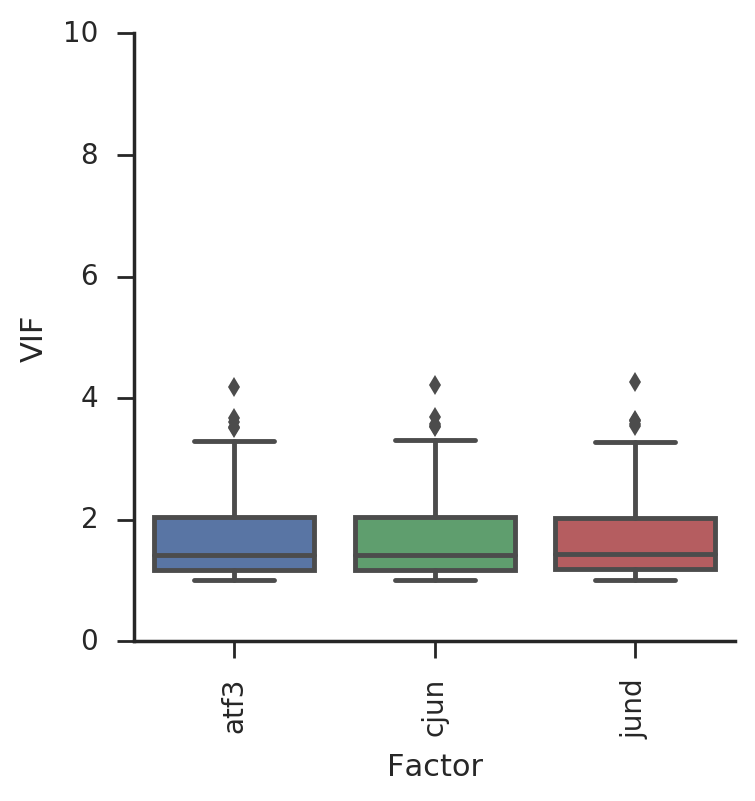

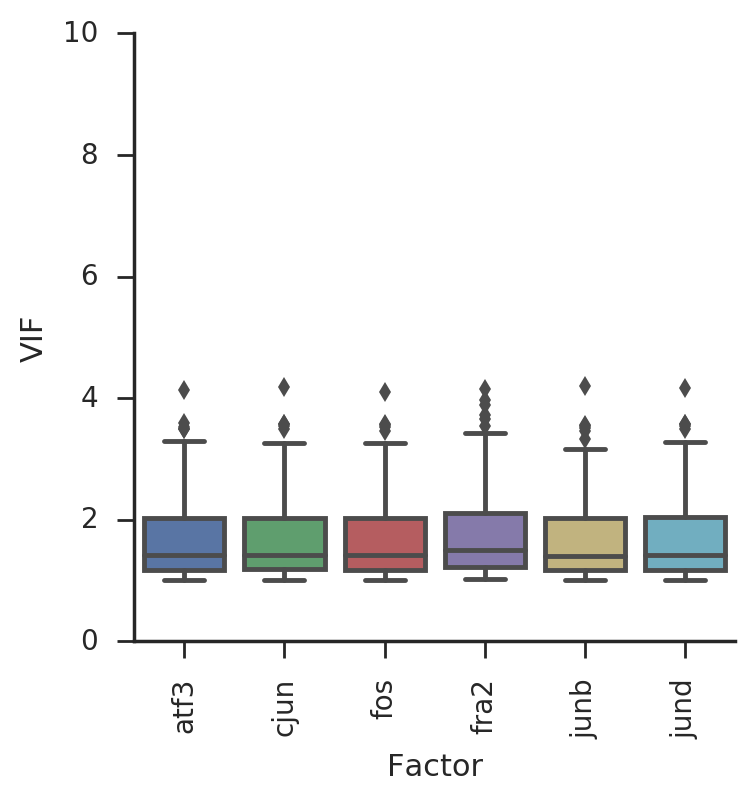

In [95]:
with sns.axes_style('ticks'):
    sns.factorplot(data = frame[frame['Treatment'] == 'veh'],
                   x = 'Factor',
                   y = 'VIF',
                   kind = 'box',
                  size=4,
                  )
plt.ylim(0,10)
plt.xticks(rotation=90)
# plt.plot([-1,3], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/supplementary - VIF analysis vehicle.png')
plt.savefig('./figures/supplementary - VIF analysis vehicle.svg')

with sns.axes_style('ticks'):
    sns.factorplot(data = frame[frame['Treatment'] == 'kla'],
                   x = 'Factor',
                   y = 'VIF',
                   kind = 'box',
                  size=4,
                  )
plt.ylim(0,10)
plt.xticks(rotation=90)
# plt.plot([-1,3], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/supplementary - VIF analysis kla.png')
plt.savefig('./figures/supplementary - VIF analysis kla.svg')

## Figure 4 - Motifs for Vehicle Dimers

In [17]:
def train_classifier(affinity_features,
                     labels,
                     numIterations=5,
                     test_size=0.5):
    all_affinity_rocs = []
    all_affinity_precisions = []
    all_affinity_coefficients = []
    all_affinity_scores = []
    all_testLabels = []

    for i in range(numIterations):  

        # split data into training and test sets
        training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
            affinity_features, labels, test_size = test_size)

        #  Train affinity classifier
        affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1, tol=1e-8)
        affinity_classifier.fit(training_affinity_features, training_labels)

        # score predictions
        affinity_probas = affinity_classifier.predict_proba(test_affinity_features)
        current_affinity_rocs = sklearn.metrics.roc_auc_score(test_labels, 
                                                              affinity_probas[:, 1], 
                                                              average = None)
        current_affinity_precision = sklearn.metrics.average_precision_score(test_labels, 
                                                                             affinity_probas[:, 1], 
                                                                             average = None)

         # retrieve coefficients
        current_affinity_coefficients = affinity_classifier.coef_.flatten()
        
        all_affinity_rocs.append(current_affinity_rocs)
        all_affinity_precisions.append(current_affinity_precision)
        all_affinity_coefficients.append(current_affinity_coefficients)
        all_affinity_scores.append(affinity_probas)
        all_testLabels.append(test_labels)
        
    results = (all_affinity_rocs, 
               all_affinity_precisions, 
               all_affinity_coefficients,
               all_affinity_scores,
               all_testLabels)
    return results
    

In [18]:
def calculate_mean_weights(affinity_weights_dict, 
                           sorted_motif_names):
    '''
    '''
    
    factor_coeff_affinity_dict = {}

    # calculates the mean of each of the weights
    for factor_treatment in affinity_weights_dict.keys():
        current_affinity_weights = affinity_weights_dict[factor_treatment]
        mean_affinity_weights = np.mean(current_affinity_weights, axis=0)
        
        factor_coeff_affinity_dict[factor_treatment] = mean_affinity_weights
    coeff_affinity_frame = pd.DataFrame(factor_coeff_affinity_dict)
    coeff_affinity_frame.index = sorted_motif_names
        
    return coeff_affinity_frame

In [19]:
def calculate_zscore_weights(affinity_weights_dict, 
                             sorted_motif_names):
    '''
        '''
    
    factor_zscore_coeff_affinity_dict = {}


    # calculates the mean of each of the weights
    for factor_treatment in affinity_weights_dict.keys():
        current_affinity_weights = affinity_weights_dict[factor_treatment]
        mean_affinity_weights = np.mean(current_affinity_weights, axis=0)
        
        # zscore normalize the weights
        zscore_affinity_weights = scipy.stats.zscore(mean_affinity_weights)
        
        factor_zscore_coeff_affinity_dict[factor_treatment] = zscore_affinity_weights

    
    zscore_coeff_affinity_frame = pd.DataFrame(factor_zscore_coeff_affinity_dict)

    zscore_coeff_affinity_frame.index = sorted_motif_names
        
    return zscore_coeff_affinity_frame

### All Motifs

In [20]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [21]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_affinity_coeff_dict = {}
factor_affinity_roc_dict = {}
factor_affinity_precision_dict = {}
factor_affinity_score_dict = {}
factor_affinity_testLabel_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

#         target_affinity_features = all_robustScaled_score_frame[all_robustScaled_score_frame.index.isin(target_indices)]
#         background_affinity_features = all_robustScaled_score_frame[all_robustScaled_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])

        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_affinity_roc_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_affinity_precision_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_affinity_coeff_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_affinity_score_dict[monomer + '_' + treatment] = all_affinity_scores
        factor_affinity_testLabel_dict[monomer + '_' + treatment] = all_affinity_testLabels
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


23133 46266
atf3_veh roc: 0.940308716238 precision: 0.936207436505
15536 31072
cjun_veh roc: 0.934640177599 precision: 0.931756726715
767 1534
fos_veh roc: 0.951955159505 precision: 0.947046790538
2333 4666
fra2_veh roc: 0.934941393902 precision: 0.934638194993
462 924
junb_veh roc: 0.717310395232 precision: 0.716373165637
19624 39248
jund_veh roc: 0.932887581269 precision: 0.928377342534
36715 73430
atf3_kla roc: 0.933668943547 precision: 0.927345834268
17468 34936
cjun_kla roc: 0.944111572214 precision: 0.940772479964
24342 48684
fos_kla roc: 0.941814907027 precision: 0.937544658563
10609 21218
fra2_kla roc: 0.938889824388 precision: 0.937850239519
13368 26736
junb_kla roc: 0.944360083442 precision: 0.940940864365
31607 63214
jund_kla roc: 0.935412019124 precision: 0.930700604866


In [22]:
zscore_coeff_affinity_frame = calculate_zscore_weights(factor_affinity_coeff_dict,
                                  all_standardized_score_frame.columns.values)

zscore_coeff_affinity_veh_frame = zscore_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
zscore_coeff_affinity_kla_frame = zscore_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']]

zscore_coeff_affinity_frame.to_pickle('zscore_coeff_affinity_frame.pickle')


### AP-1 Motif Only

In [23]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_affinity_roc_ap1Only_dict = {}
factor_affinity_precision_ap1Only_dict = {}
factor_affinity_scores_ap1Only_dict = {}
factor_affinity_testLabel_ap1Only_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        
        affinity_features = affinity_features[['ap-1','atf7_batf3_creb5']]
        
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_affinity_roc_ap1Only_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_affinity_precision_ap1Only_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_affinity_scores_ap1Only_dict[monomer + '_' + treatment] = all_affinity_scores
        factor_affinity_testLabel_ap1Only_dict[monomer + '_' + treatment] = all_affinity_testLabels
        
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


23133 46266
atf3_veh roc: 0.787089571458 precision: 0.806114366296
15536 31072
cjun_veh roc: 0.797126122671 precision: 0.817576023708
767 1534
fos_veh roc: 0.619890679253 precision: 0.678373547869
2333 4666
fra2_veh roc: 0.847265012053 precision: 0.866438760764
462 924
junb_veh roc: 0.696778546129 precision: 0.726952359813
19624 39248
jund_veh roc: 0.761117322001 precision: 0.791413059492
36715 73430
atf3_kla roc: 0.801504029047 precision: 0.820036928436
17468 34936
cjun_kla roc: 0.814676884511 precision: 0.830989008624
24342 48684
fos_kla roc: 0.825481113317 precision: 0.844453122507
10609 21218
fra2_kla roc: 0.839471162037 precision: 0.856230058313
13368 26736
junb_kla roc: 0.831060915766 precision: 0.843106057227
31607 63214
jund_kla roc: 0.790360665623 precision: 0.812253444214


### Top Motif

In [24]:
# for monomers using motif counts and best motif score for top motifs
strain = 'c57bl6'
weight_threshold = 1.0

factor_affinity_roc_top_dict = {}
factor_affinity_precision_top_dict = {}
factor_affinity_scores_top_dict = {}
factor_affinity_testLabel_top_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        # determine top motifs
        data = zscore_coeff_affinity_frame
        top_motifs = data[(data[monomer + '_' + treatment] > weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ].index.values
        
        print(len(top_motifs))
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
       
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        
        affinity_features = affinity_features[top_motifs]
        
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_affinity_roc_top_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_affinity_precision_top_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_affinity_testLabel_top_dict[monomer + '_' + treatment] = all_affinity_testLabels

        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

30


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.931220009966 precision: 0.926497753478
27
cjun_veh roc: 0.928647148618 precision: 0.925199738785
34
fos_veh roc: 0.969972059462 precision: 0.966426599662
32
fra2_veh roc: 0.943311239022 precision: 0.945753133912
51
junb_veh roc: 0.803954198759 precision: 0.818969081726
31
jund_veh roc: 0.92788476975 precision: 0.92357226762
27
atf3_kla roc: 0.927531437335 precision: 0.922972498846
26
cjun_kla roc: 0.934238574181 precision: 0.931236074447
26
fos_kla roc: 0.932101643547 precision: 0.928383581
26
fra2_kla roc: 0.935152809622 precision: 0.93383321339
24
junb_kla roc: 0.938029959627 precision: 0.935460635197
27
jund_kla roc: 0.928352674925 precision: 0.92289946701


### Polynomial Features

In [25]:
def make_interaction_features(features):
    '''
    input: raw unstandardized scores
    output: motif features with dgree 2 interaction terms
    creates motif features with degree 2 interaction terms 
    '''
    polynomial_transformer = sklearn.preprocessing.PolynomialFeatures(degree=2, 
                                                                      interaction_only=True)
    interaction_features = pd.DataFrame(polynomial_transformer.fit_transform(features))
    
    # drop first column which is invariant and always 1
    interaction_features = interaction_features.ix[:,1:]  
    
    # fix column names
    motifs = features.columns.values
    interaction_term_columns = list(motifs)
    for i in range(len(motifs)-1):
        for j in range(i+1,len(motifs)):
            interaction_term_columns.append(motifs[i]+'::'+motifs[j])
    interaction_features.columns = interaction_term_columns
    interaction_features.index = features.index.values
    
    # standardize features
    scaler = preprocessing.StandardScaler()
    standardized_interaction_features = pd.DataFrame(scaler.fit_transform(interaction_features))
    standardized_interaction_features.columns = interaction_features.columns.values
    standardized_interaction_features.index = interaction_features.index.values
    standardized_interaction_features = standardized_interaction_features[sorted(standardized_interaction_features.columns.values)]


    return standardized_interaction_features, interaction_features, interaction_term_columns

In [32]:
# for monomers using motif counts and best motif score for polynomial motifs
strain = 'c57bl6'
background_ratio =1.0
weight_threshold = 1.0

# top_veh_motifs = zscore_coeff_affinity_veh_frame[(zscore_coeff_affinity_veh_frame.max(axis=1) >= weight_threshold) |
#                                 (zscore_coeff_affinity_veh_frame.min(axis=1) < -1 * weight_threshold)
#                                 ].index.values

# top_kla_motifs = zscore_coeff_affinity_kla_frame[(zscore_coeff_affinity_kla_frame.max(axis=1) >= weight_threshold) |
#                                 (zscore_coeff_affinity_kla_frame.min(axis=1) < -1 * weight_threshold)
#                                 ].index.values
top_veh_motifs = zscore_coeff_affinity_veh_frame[(zscore_coeff_affinity_veh_frame.max(axis=1) >= weight_threshold)
                                ].index.values

top_kla_motifs = zscore_coeff_affinity_kla_frame[(zscore_coeff_affinity_kla_frame.max(axis=1) >= weight_threshold)
                                ].index.values
top_motifs = sorted(set(top_veh_motifs).union(top_kla_motifs))

factor_affinity_coeff_interaction_dict = {}
factor_affinity_roc_interaction_dict = {}
factor_affinity_precision_interaction_dict = {}
factor_affinity_testLabel_interaction_dict = {}
factor_affinity_scores_interaction_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_score_frame[all_score_frame.index.isin(target_indices)]
        background_affinity_features = all_score_frame[all_score_frame.index.isin(background_indices)]
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        print(affinity_features.shape)
        
        standardized_interaction_score_features, interaction_score_features, motif_names = make_interaction_features(affinity_features)
        
        print(standardized_interaction_score_features.shape)
               
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        
        results = train_classifier(standardized_interaction_score_features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_affinity_coeff_interaction_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_affinity_roc_interaction_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_affinity_precision_interaction_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_affinity_testLabel_interaction_dict[monomer + '_' + treatment] = all_affinity_testLabels
        factor_affinity_scores_interaction_dict[monomer + '_' + treatment] = all_affinity_scores


        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(46266, 23)
(46266, 276)
atf3_veh roc: 0.927358483663 precision: 0.921363134352
(31072, 23)
(31072, 276)
cjun_veh roc: 0.92419423218 precision: 0.921311123483
(1534, 23)
(1534, 276)
fos_veh roc: 0.826475016276 precision: 0.816741947171
(4666, 23)
(4666, 276)
fra2_veh roc: 0.916094850608 precision: 0.916493407291
(924, 23)
(924, 276)
junb_veh roc: 0.708073311969 precision: 0.732359470946
(39248, 23)
(39248, 276)
jund_veh roc: 0.922595384338 precision: 0.916938606532
(73430, 23)
(73430, 276)
atf3_kla roc: 0.925516063971 precision: 0.919468367169
(34936, 23)
(34936, 276)
cjun_kla roc: 0.931597820089 precision: 0.92627682752
(48684, 23)
(48684, 276)
fos_kla roc: 0.929815587441 precision: 0.924316015871
(21218, 23)
(21218, 276)
fra2_kla roc: 0.92874248948 precision: 0.927073879137
(26736, 23)
(26736, 276)
junb_kla roc: 0.936177162448 precision: 0.932319741244
(63214, 23)
(63214, 276)
jund_kla roc: 0.925315470355 precision: 0.918165770211


In [34]:
# combine weights
interaction_names = list(top_motifs)
for i in range(len(top_motifs)-1):
    for j in range(i+1,len(top_motifs)):
        interaction_names.append(top_motifs[i]+'::'+top_motifs[j])

coeff_affinity_interaction_frame = calculate_mean_weights(factor_affinity_coeff_interaction_dict,
                                                         interaction_names
                                                         )

In [35]:
coeff_affinity_interaction_frame.to_pickle('coeff_affinity_interaction_frame.pickle')

## gkmSVM

In [40]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi


In [41]:
! rm ./gkmsvm_files/*

In [42]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [43]:
### for all peaks in vehicle using gapped k-mers on background data
### write script
background_ratio = 1.0
numIterations = 5
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '.sh', 'w')
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_' +str(iteration) + '.fa'

                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1
                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration)
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                          ' -T 8 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 8)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 8)&\n')
                
    script_file.close()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh
cjun_veh
fos_veh
fra2_veh
junb_veh
jund_veh
atf3_kla
cjun_kla
fos_kla
fra2_kla
junb_kla
jund_kla


In [ ]:
%%bash
chmod a+x ./gkmsvm_veh.sh 
./gkmsvm_veh.sh

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla.sh 
./gkmsvm_kla.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on background data
### read performance
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame.index.values

        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration)
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)
                normalized_scores = sorted_scores
                # score predictions  

                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )

### Classifier Performance

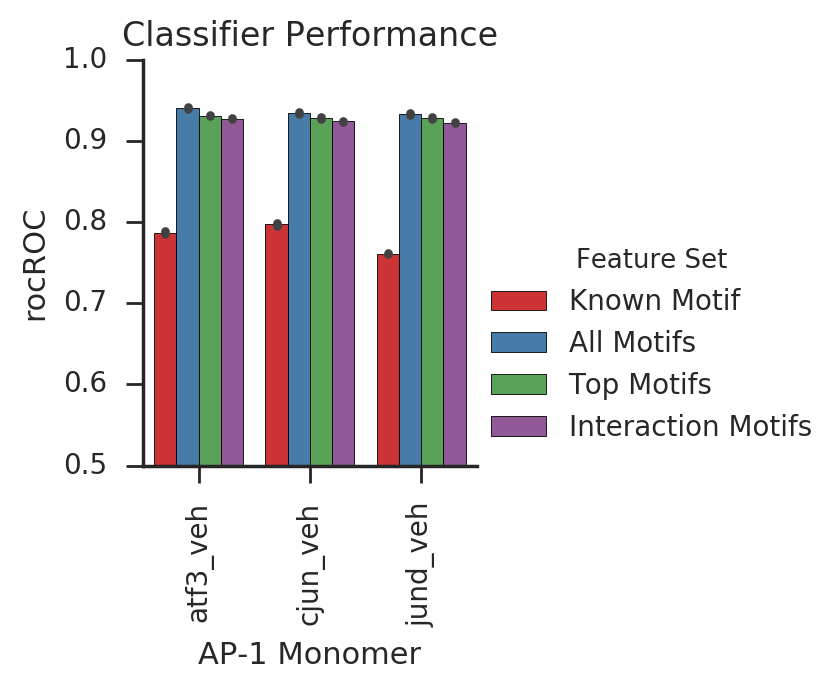

In [47]:
monomers = []
rocs = []
feature_set = []
for factor in ['atf3_veh', 'cjun_veh', 'jund_veh']:
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_ap1Only_dict[factor]
    feature_set = feature_set + numIterations * ['Known Motif']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_dict[factor]
    feature_set = feature_set + numIterations * ['All Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_top_dict[factor]
    feature_set = feature_set + numIterations * ['Top Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_interaction_dict[factor]
    feature_set = feature_set + numIterations * ['Interaction Motifs']
    
#     monomers = monomers + numIterations * [factor]
#     rocs = rocs + factor_auc_dict_gkmSVM[factor]
#     feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'roc':rocs,
                     'Feature Set': feature_set
                     })

for treatment in ['veh']:
    factor_roc_tuples = [(x, np.mean(factor_affinity_roc_dict[x])) for x in factor_affinity_roc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_roc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='roc',
#                                     order = sorted_monomers,
                                    palette='Set1',
                                    size=3,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('rocROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,1)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_04_a.svg')
        plt.show()

    

### Distribution of Motif Weights

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


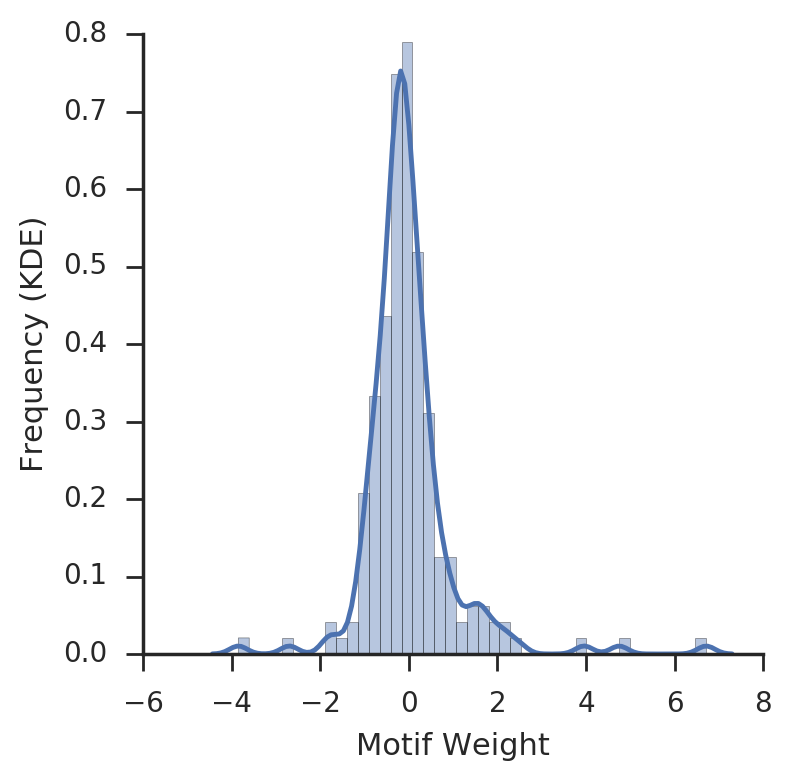

In [44]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.distplot(zscore_coeff_affinity_frame['cjun_veh'])
    sns.despine()
    plt.xlabel('Motif Weight')
    plt.ylabel('Frequency (KDE)')
plt.savefig('./figures/figure_04_b.svg', bbox_inches='tight')

### Scatter plot for similar dimers

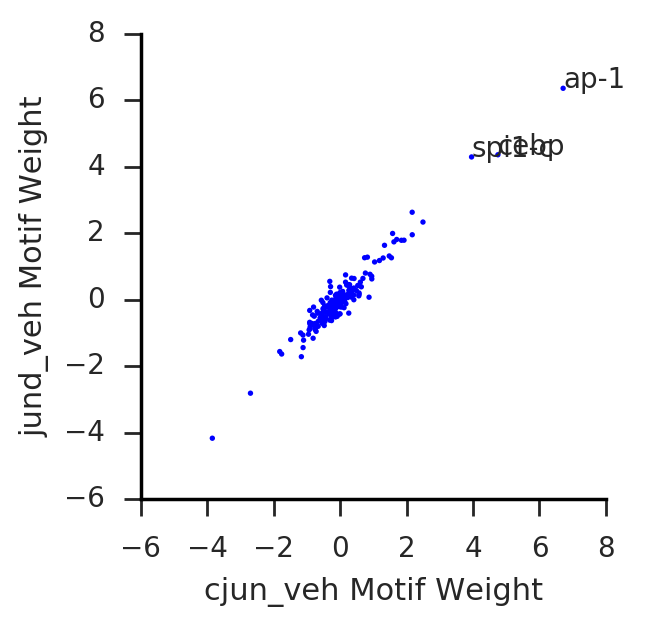

In [48]:
# scatterplot of weights
factor1 = 'cjun_veh'
factor2 = 'jund_veh'
delta_threshold = 2.0
targets = ['ap-1', 'cebp', 'spi1-c']
plt.figure(figsize=(3,3))
motifs = zscore_coeff_affinity_frame.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = zscore_coeff_affinity_frame[factor1]
    y_vals = zscore_coeff_affinity_frame[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15,
                edgecolor='None')
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if (abs(x) >= 0.5) or (abs(y) >= 0.5)  or (motifs[i] in targets):
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if (delta > delta_threshold) or (motifs[i] in targets):
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_04_c.svg', bbox_inches='tight')

### Scatter plot of dissimilar monomers

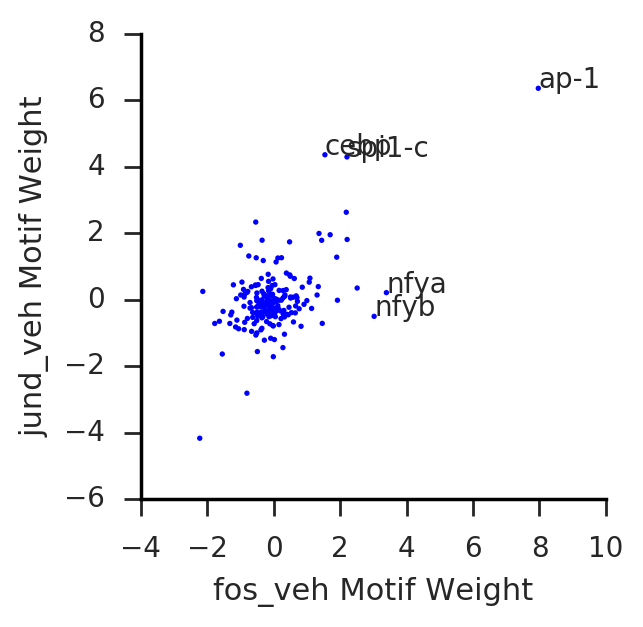

In [49]:
# scatterplot of weights
factor1 = 'fos_veh'
factor2 = 'jund_veh'
delta_threshold = 3.0
targets = ['ap-1', 'cebp', 'spi1-c']
plt.figure(figsize=(3,3))
motifs = zscore_coeff_affinity_frame.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = zscore_coeff_affinity_frame[factor1]
    y_vals = zscore_coeff_affinity_frame[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15,
                edgecolor='None')
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.5 or abs(y) >= 0.5:
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if delta > delta_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_04_d.svg', bbox_inches='tight')


### Visualization of significant weights

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


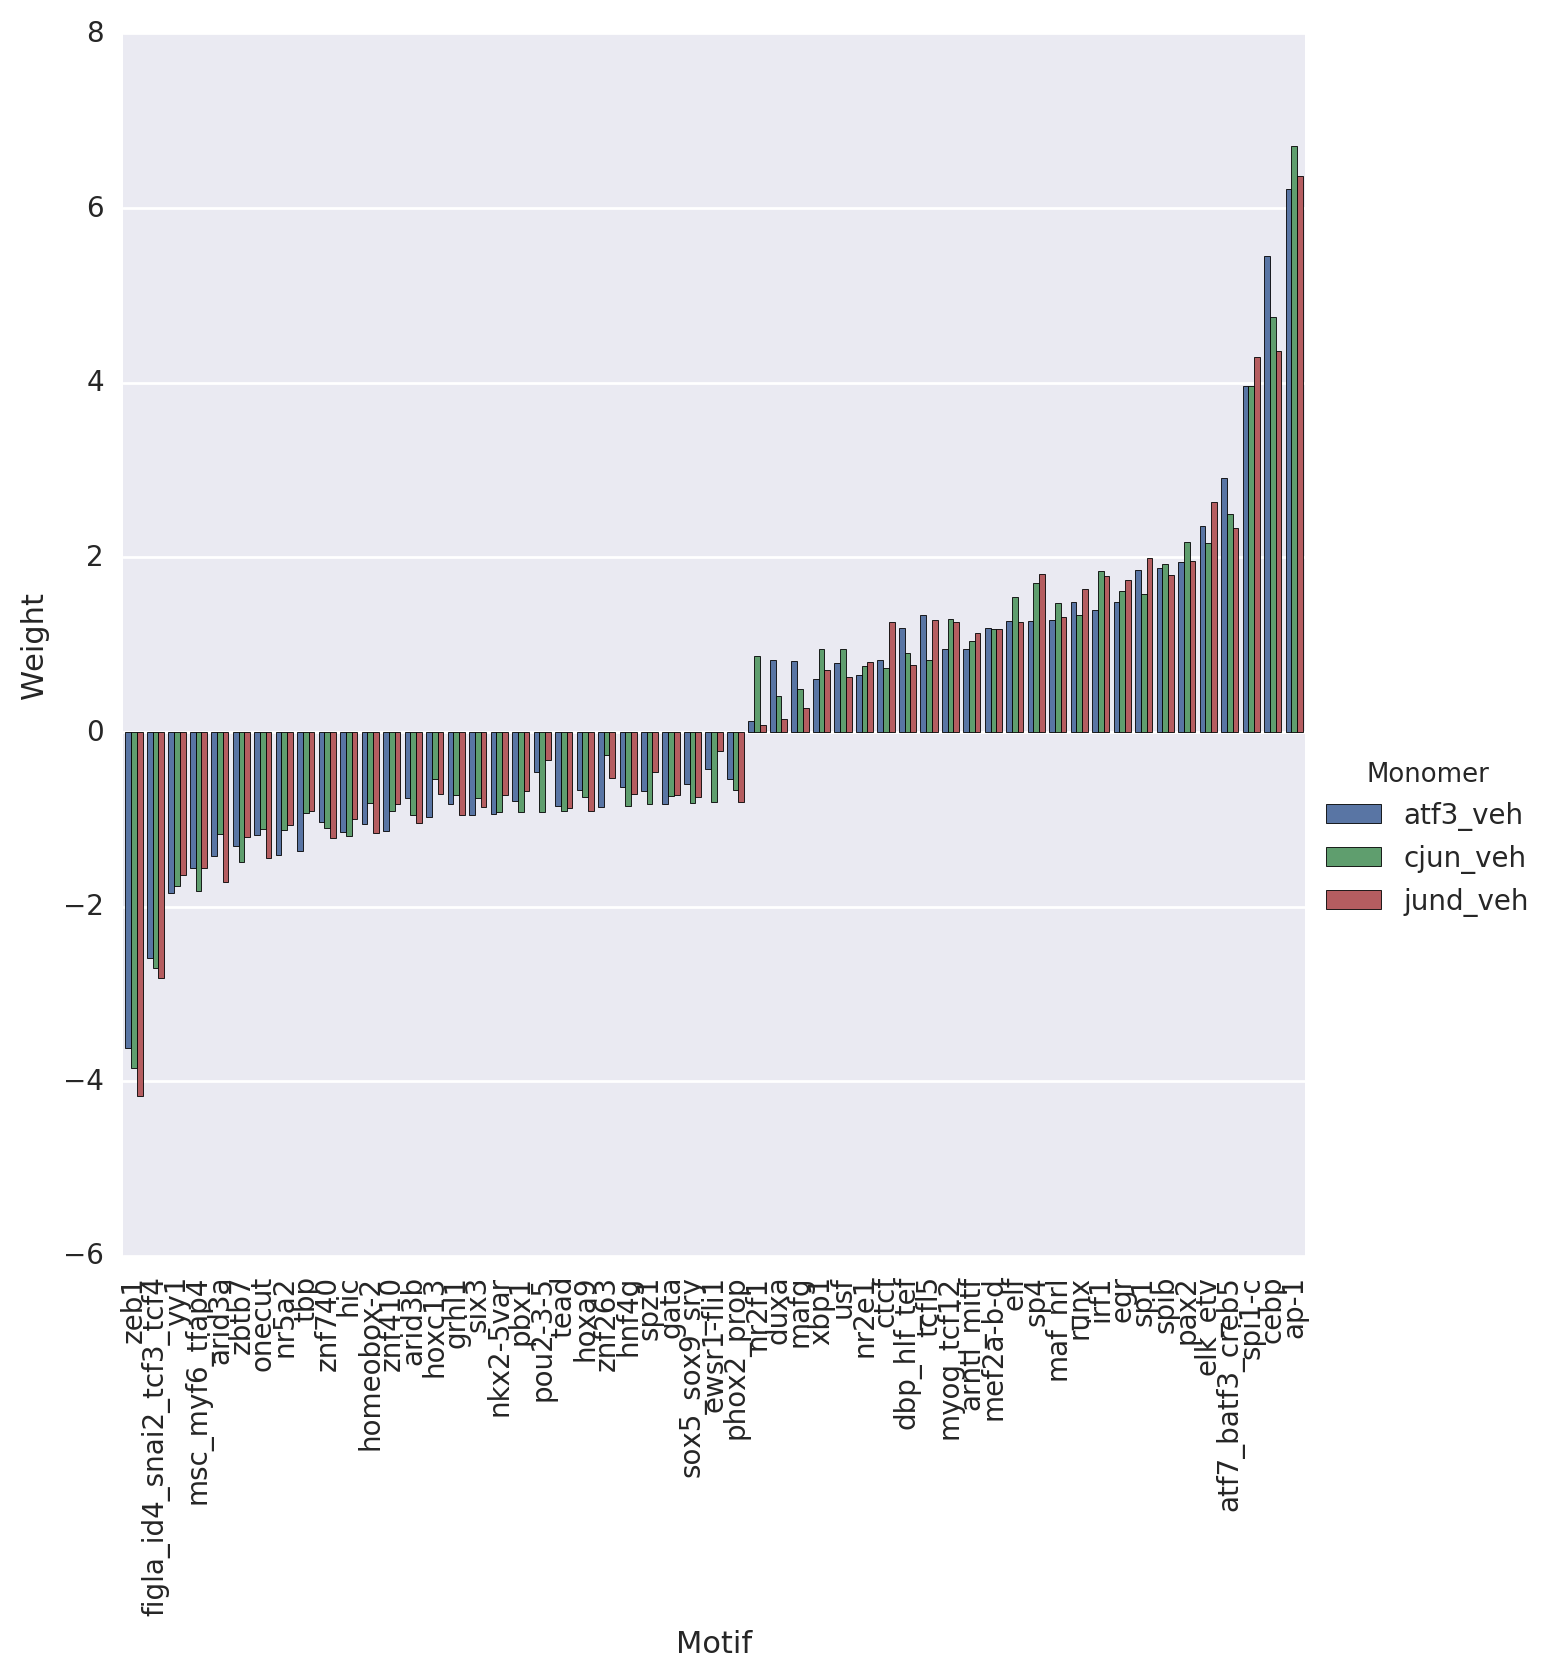

In [50]:
weight_threshold = 0.8
data = zscore_coeff_affinity_veh_frame[
    (zscore_coeff_affinity_veh_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_veh_frame.min(axis=1) < -1* weight_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_veh', 'cjun_veh', 'jund_veh'],
               size=7)
plt.xticks(rotation = 90, size=10);

In [51]:
import warnings
warnings.filterwarnings('ignore')

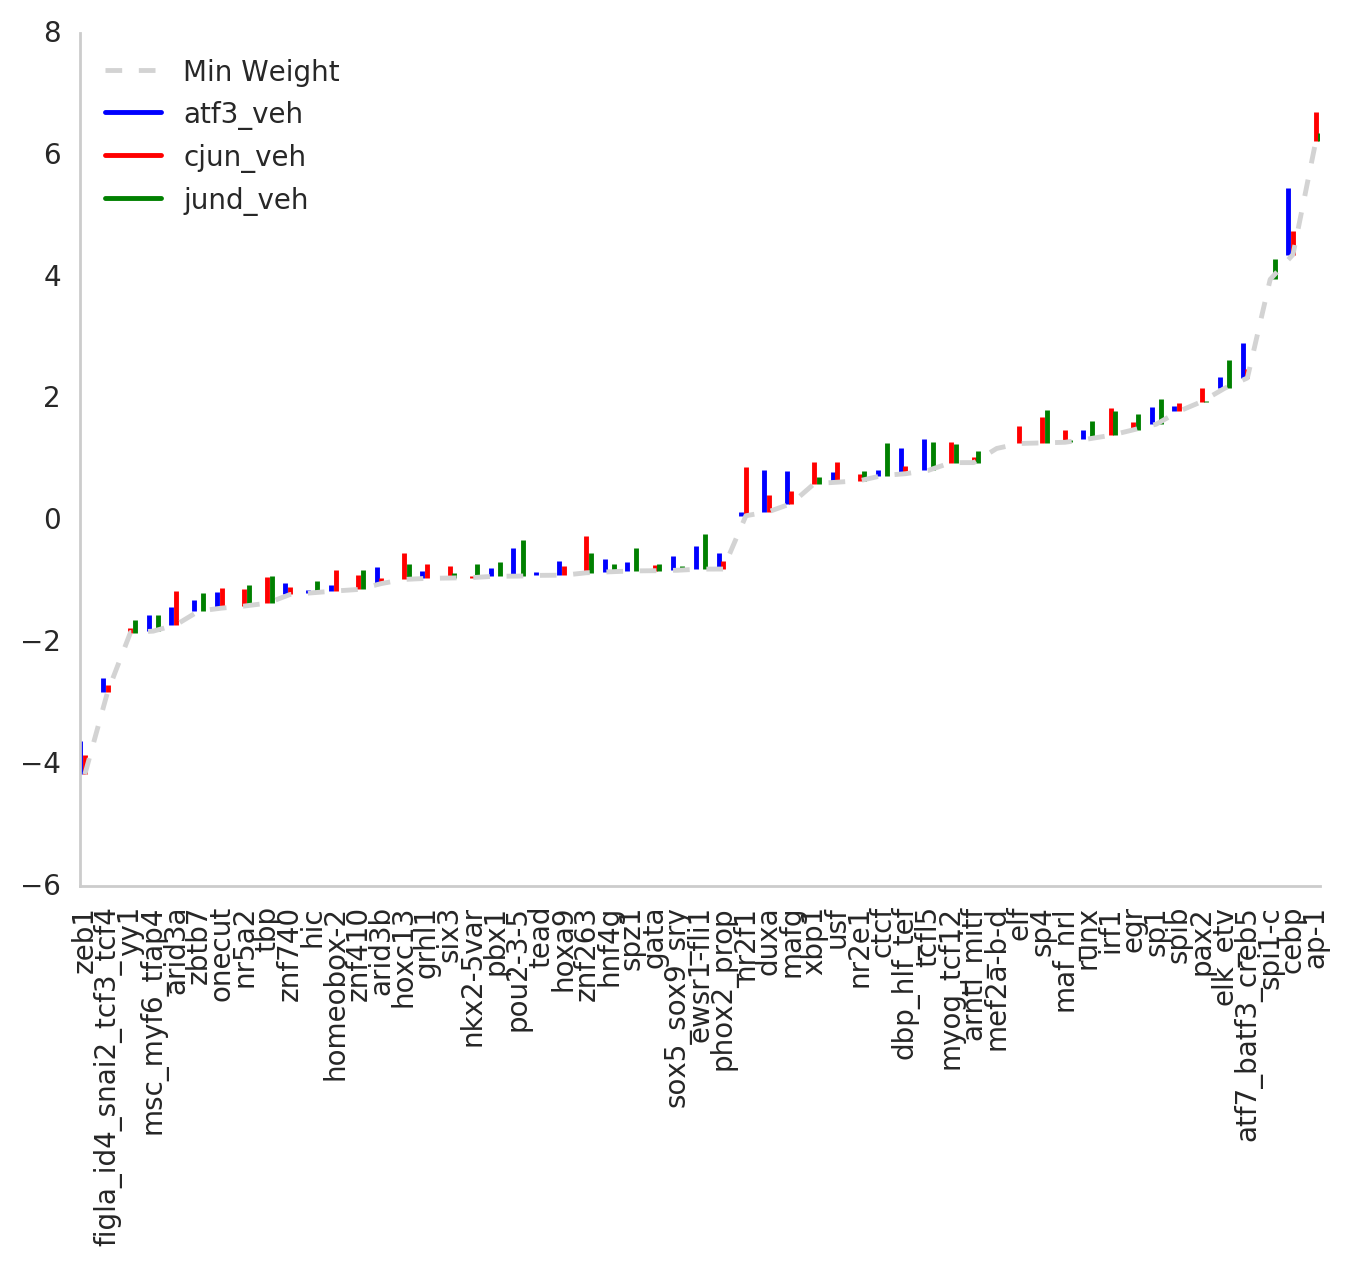

In [52]:
weight_threshold = 0.8
data = zscore_coeff_affinity_veh_frame[
    (zscore_coeff_affinity_veh_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_veh_frame.min(axis=1) < -1* weight_threshold)
]

x_starting_offset = -0.2
x_offset = 0.2
color_dict = {'atf3_veh':'blue',
              'cjun_veh':'red',
              'jund_veh':'green'}

data.loc[:,'Min'] = data.min(axis=1).values
data.sort('Min', inplace = True)
mean_weights = data['Min'].values
motif_names = data.index.values
x_positions = np.arange(len(mean_weights)) + 1
with sns.axes_style('whitegrid',{}):
    plt.plot(x_positions, 
             mean_weights,
             c= 'lightgrey',
             label = 'Min Weight',
            linestyle='--')
    plt.xticks(x_positions,
               motif_names,
               rotation=90)
    for i in range(data.columns.shape[0]):
        col = data.columns[i]
        if not col == 'Min':
            current_weights = data[col].values
            mod_x = x_positions + x_starting_offset + i * x_offset

            y_mins = [min(x) for x in zip(mean_weights, current_weights)]
            y_maxes = [max(x) for x in zip(mean_weights, current_weights)]


            plt.vlines(mod_x, y_mins, y_maxes, 
                       label=col,
                       color= color_dict[col])
    plt.gca().xaxis.grid(False)
    plt.gca().yaxis.grid(False)
    sns.despine()
    plt.legend(loc='upper left')

(0, 55)

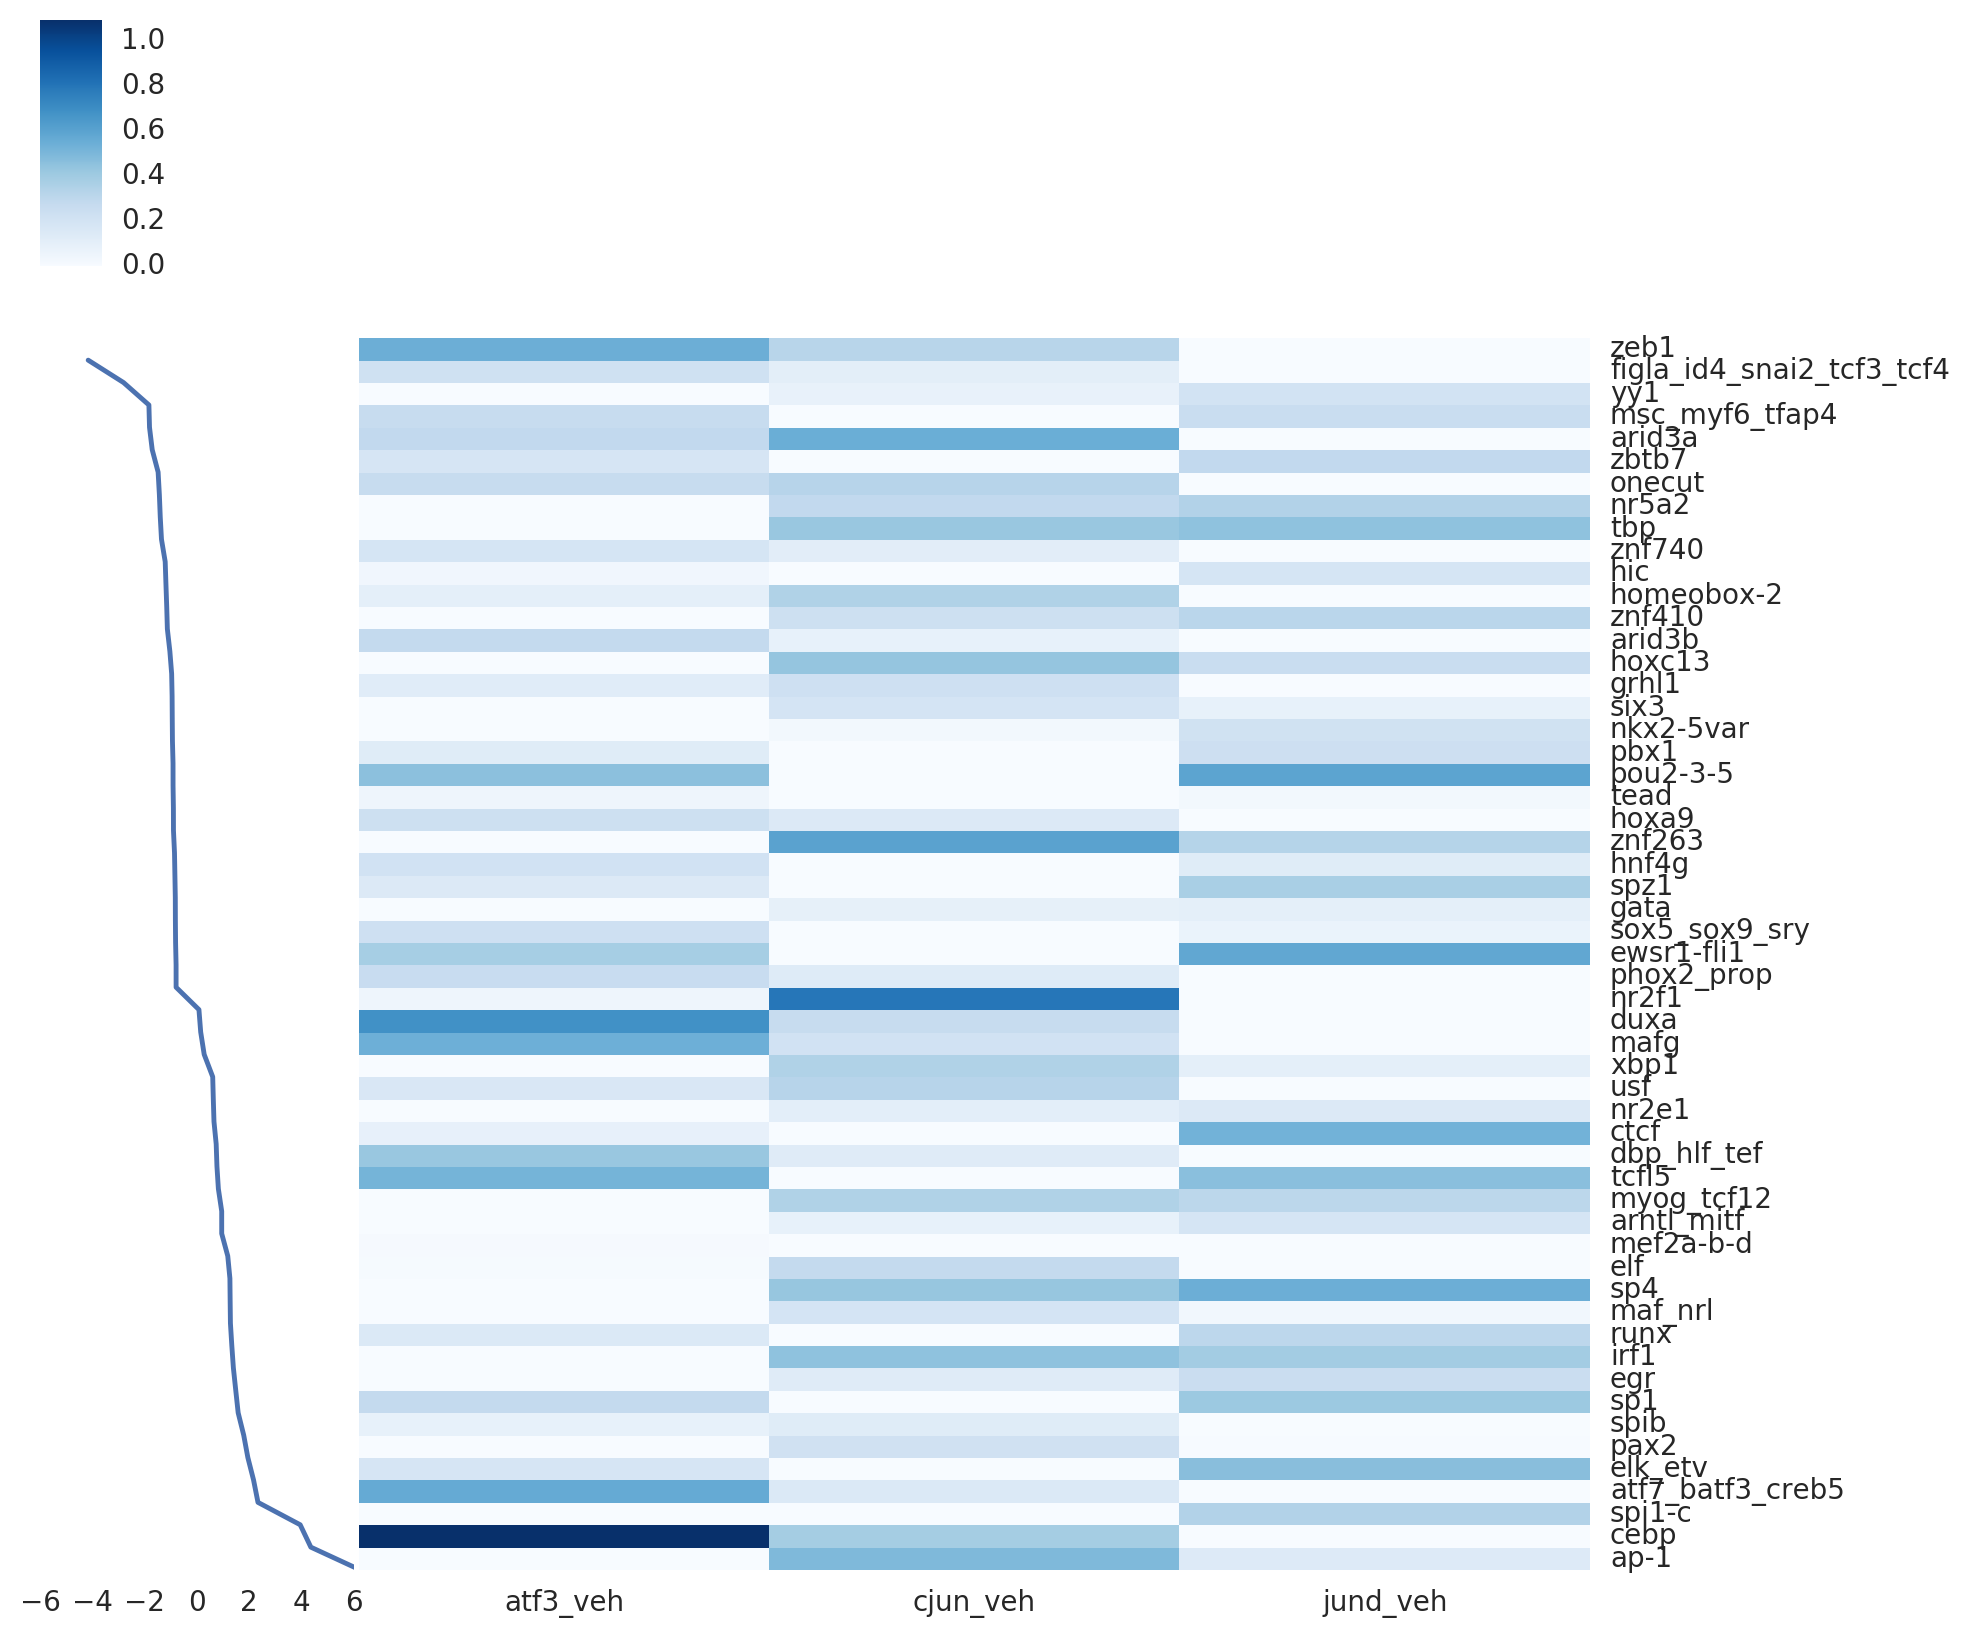

In [230]:
weight_threshold = 0.8
data = zscore_coeff_affinity_veh_frame[
    (zscore_coeff_affinity_veh_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_veh_frame.min(axis=1) < -1* weight_threshold)
]
mins = data.min(axis=1)

differences = data[[]]
for col in data.columns:
    differences[col] = data[col].values - mins.values
mins.sort()
sorted_differences = differences.ix[mins.index.values,:]
cg = sns.clustermap(sorted_differences,
                    col_cluster=False,
                   row_cluster=False,
                   cmap='Blues')
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
cg.ax_row_dendrogram.clear()
cg.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
cg.ax_row_dendrogram.set_yticks([])
cg.ax_row_dendrogram.set_xlim(-6,6)
cg.ax_row_dendrogram.set_ylim(0,len(mins))

### Visualize Interactions

In [60]:
factor_additiveInteraction_dict = {}
factor_multiplicativeInteraction_dict = {}


for factor_treatment in coeff_affinity_interaction_frame.columns.values:
    weights = coeff_affinity_interaction_frame[factor_treatment]
    additive_interactions = []
    multiplicative_interactions = []
    for i in range(len(top_motifs)-1):
        motif1 = top_motifs[i]
        weight1 = weights.ix[motif1]
        for j in range(i+1,len(top_motifs)):
            motif2 = top_motifs[j]
            interaction_term = motif1 + '::' + motif2
            weight2 = weights.ix[motif2]
            interaction_weight = weights.ix[interaction_term]
            
            additive_interaction = np.exp(weight1 + weight2 + interaction_weight) - np.exp(weight1) - np.exp(weight2) + 1
            multiplicative_interaction = (np.exp(weight1 + weight2 + interaction_weight))/((np.exp(weight1)) * (np.exp(weight2)))
            
            additive_interactions.append(additive_interaction)
            multiplicative_interactions.append(multiplicative_interaction)
    factor_additiveInteraction_dict[factor_treatment] = additive_interactions
    factor_multiplicativeInteraction_dict[factor_treatment] = multiplicative_interactions
    
interaction_terms = []
for i in range(len(top_motifs)-1):
    motif1 = top_motifs[i]
    for j in range(i+1,len(top_motifs)):
        motif2 = top_motifs[j]
        interaction_term = motif1 + '::' + motif2
        interaction_terms.append(interaction_term)
interaction_additive_frame = pd.DataFrame(factor_additiveInteraction_dict, index = interaction_terms) 
interaction_multiplicative_frame = pd.DataFrame(factor_multiplicativeInteraction_dict, index = interaction_terms) 

In [61]:
interaction_additive_veh_frame = interaction_additive_frame[['atf3_veh','cjun_veh', 'jund_veh']]
interaction_multiplicative_veh_frame = interaction_multiplicative_frame[['atf3_veh','cjun_veh', 'jund_veh']]

interaction_additive_kla_frame = interaction_additive_frame[['atf3_kla','cjun_kla','fos_kla', 'junb_kla', 'jund_kla']]
interaction_multiplicative_kla_frame = interaction_multiplicative_frame[['atf3_kla','cjun_kla','fos_kla', 'junb_kla', 'jund_kla']]

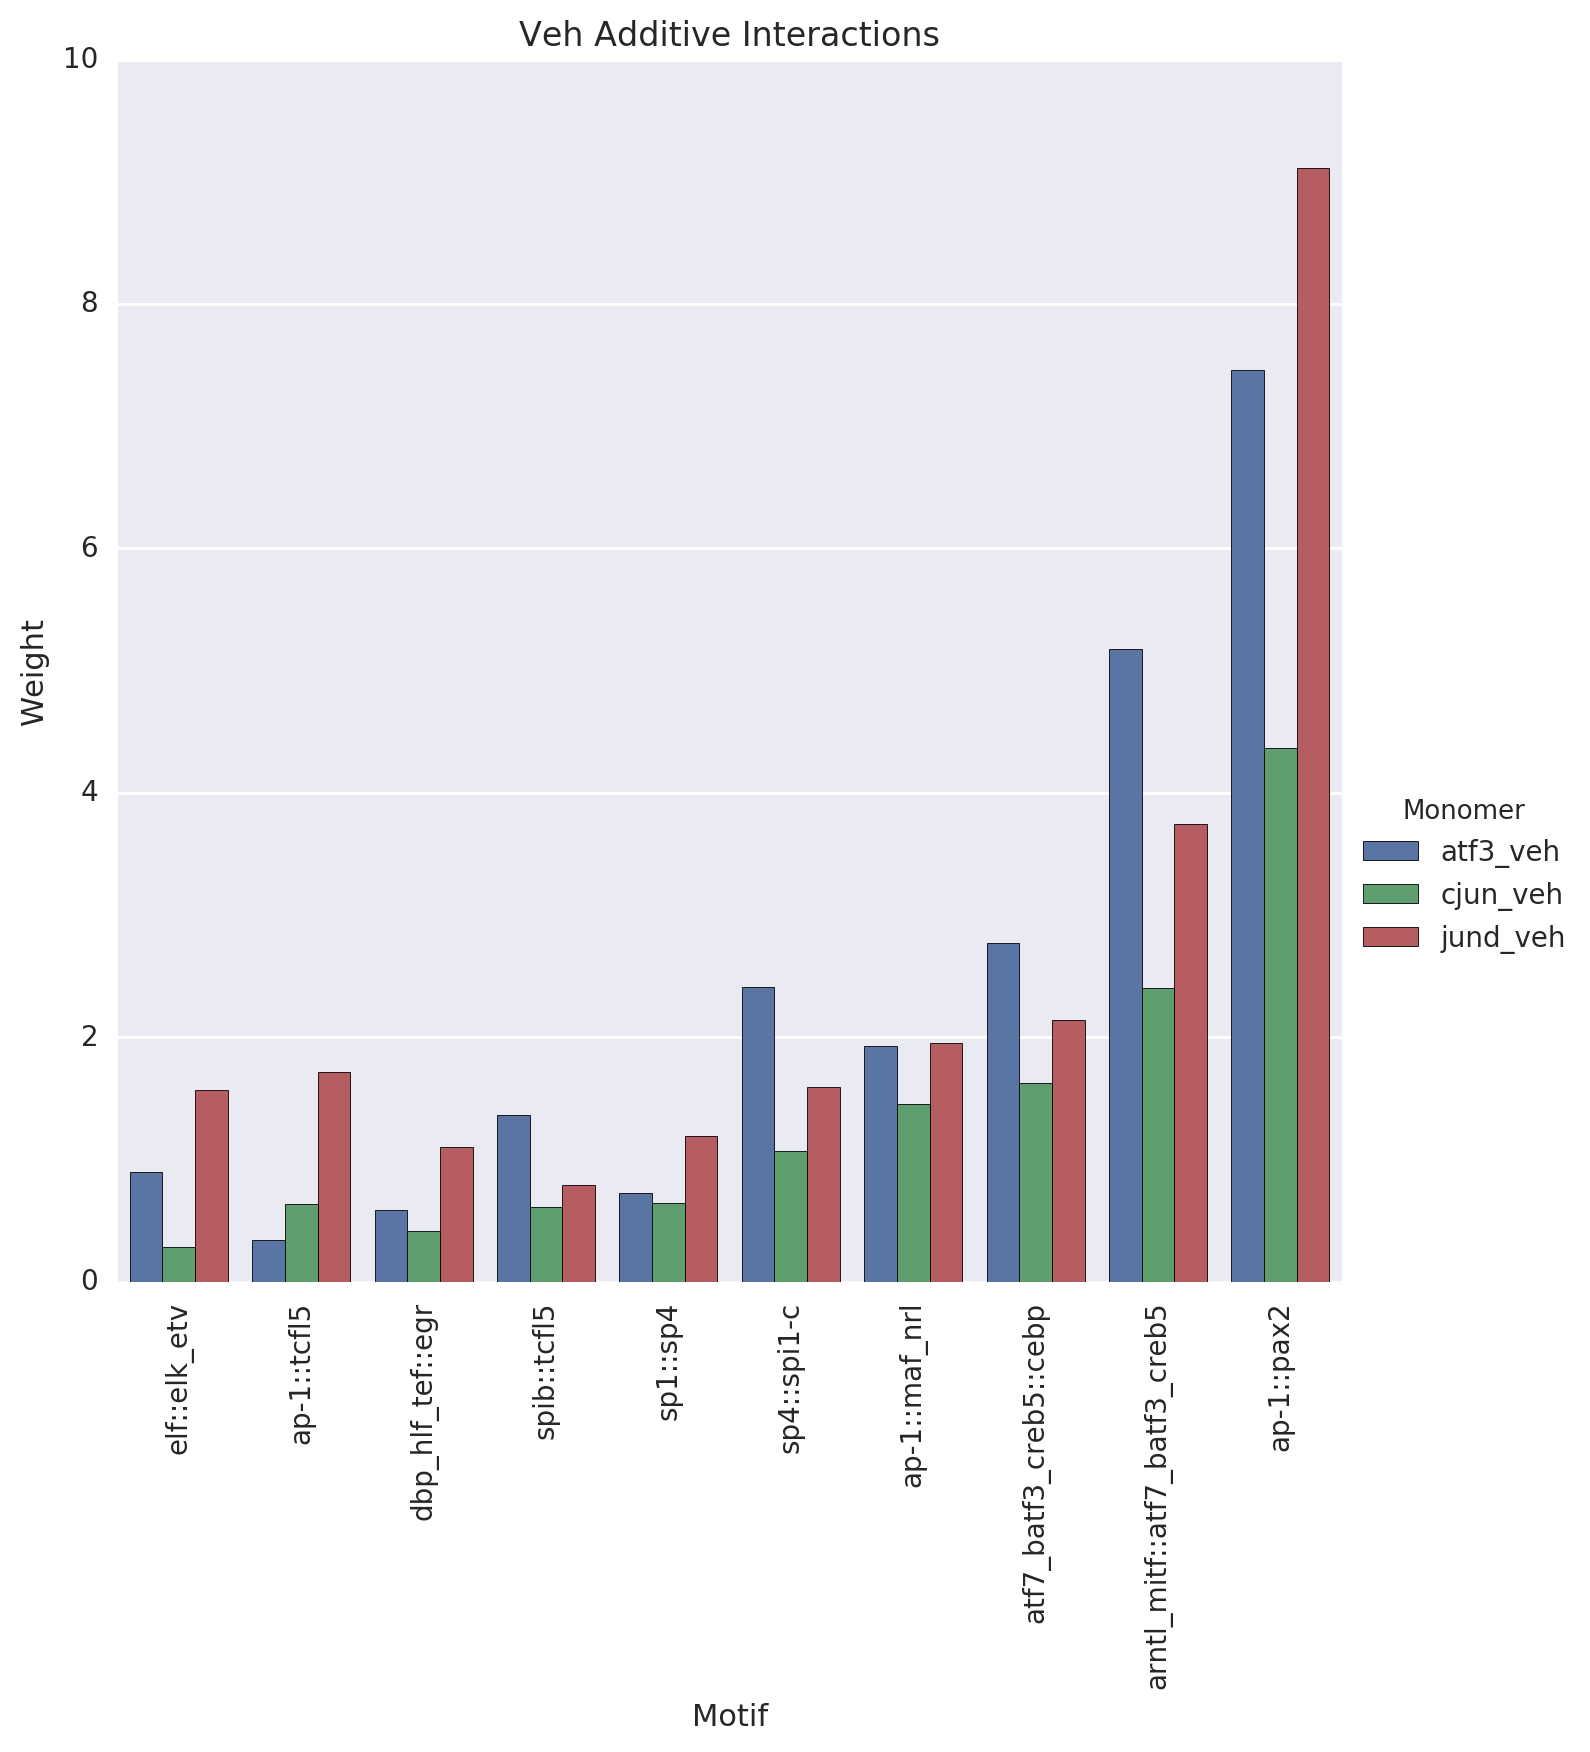

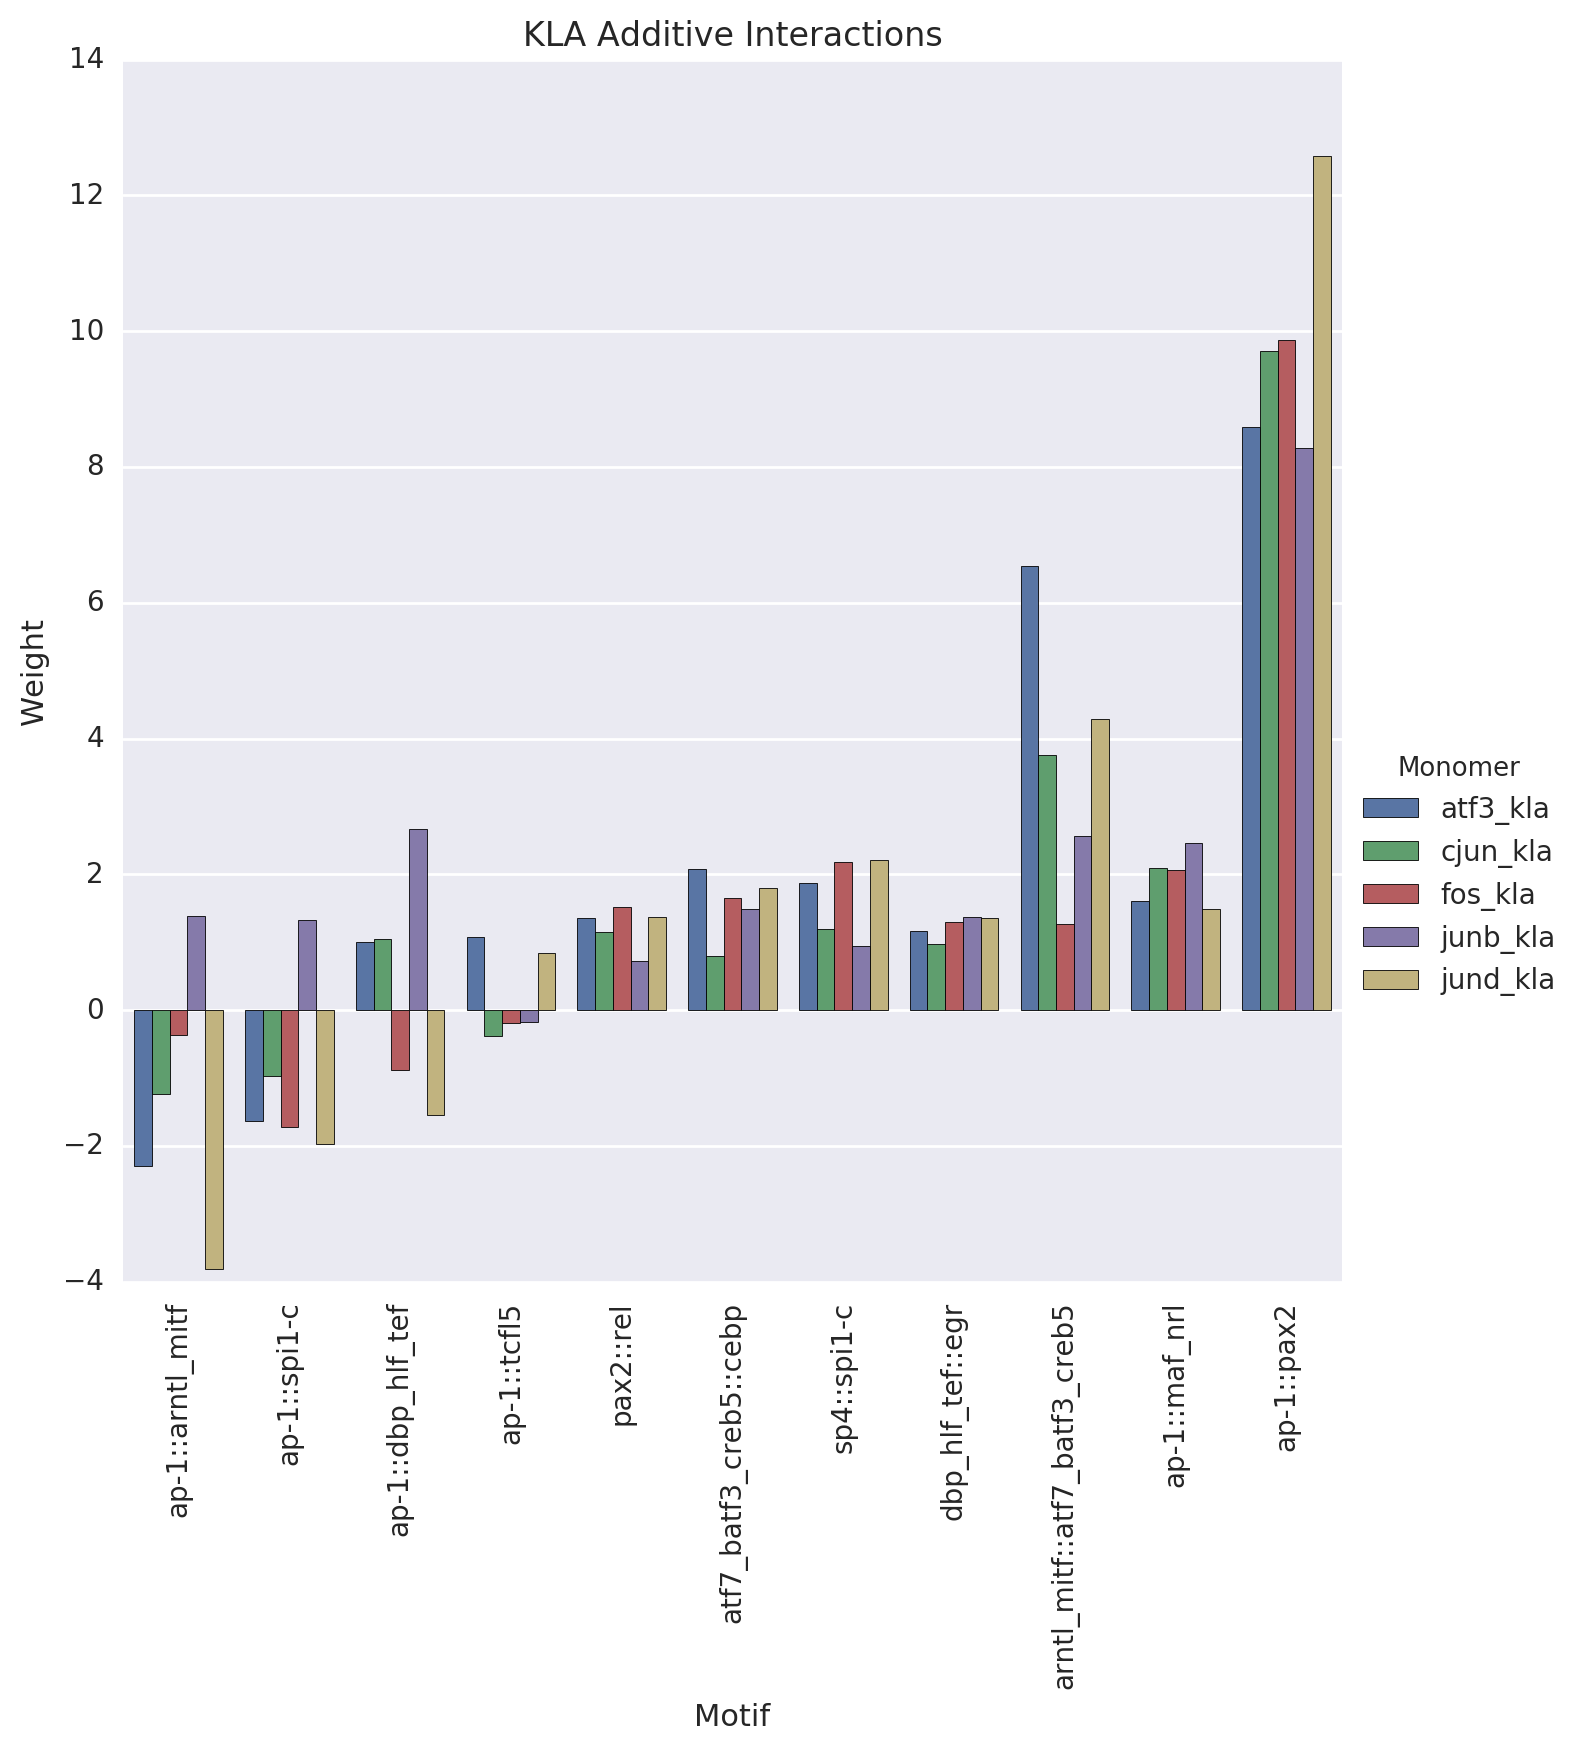

In [62]:
interaction_threshold = 1.0
data = interaction_additive_veh_frame[
    (interaction_additive_veh_frame.max(axis=1) > 1* interaction_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_veh','cjun_veh', 'jund_veh'],
               size=7)
plt.xticks(rotation = 90, size=10);
plt.title('Veh Additive Interactions')

data = interaction_additive_kla_frame[
    (interaction_additive_kla_frame.max(axis=1) > 1* interaction_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_kla','cjun_kla','fos_kla', 'junb_kla', 'jund_kla'],
               size=7)
plt.xticks(rotation = 90, size=10);
plt.title('KLA Additive Interactions')

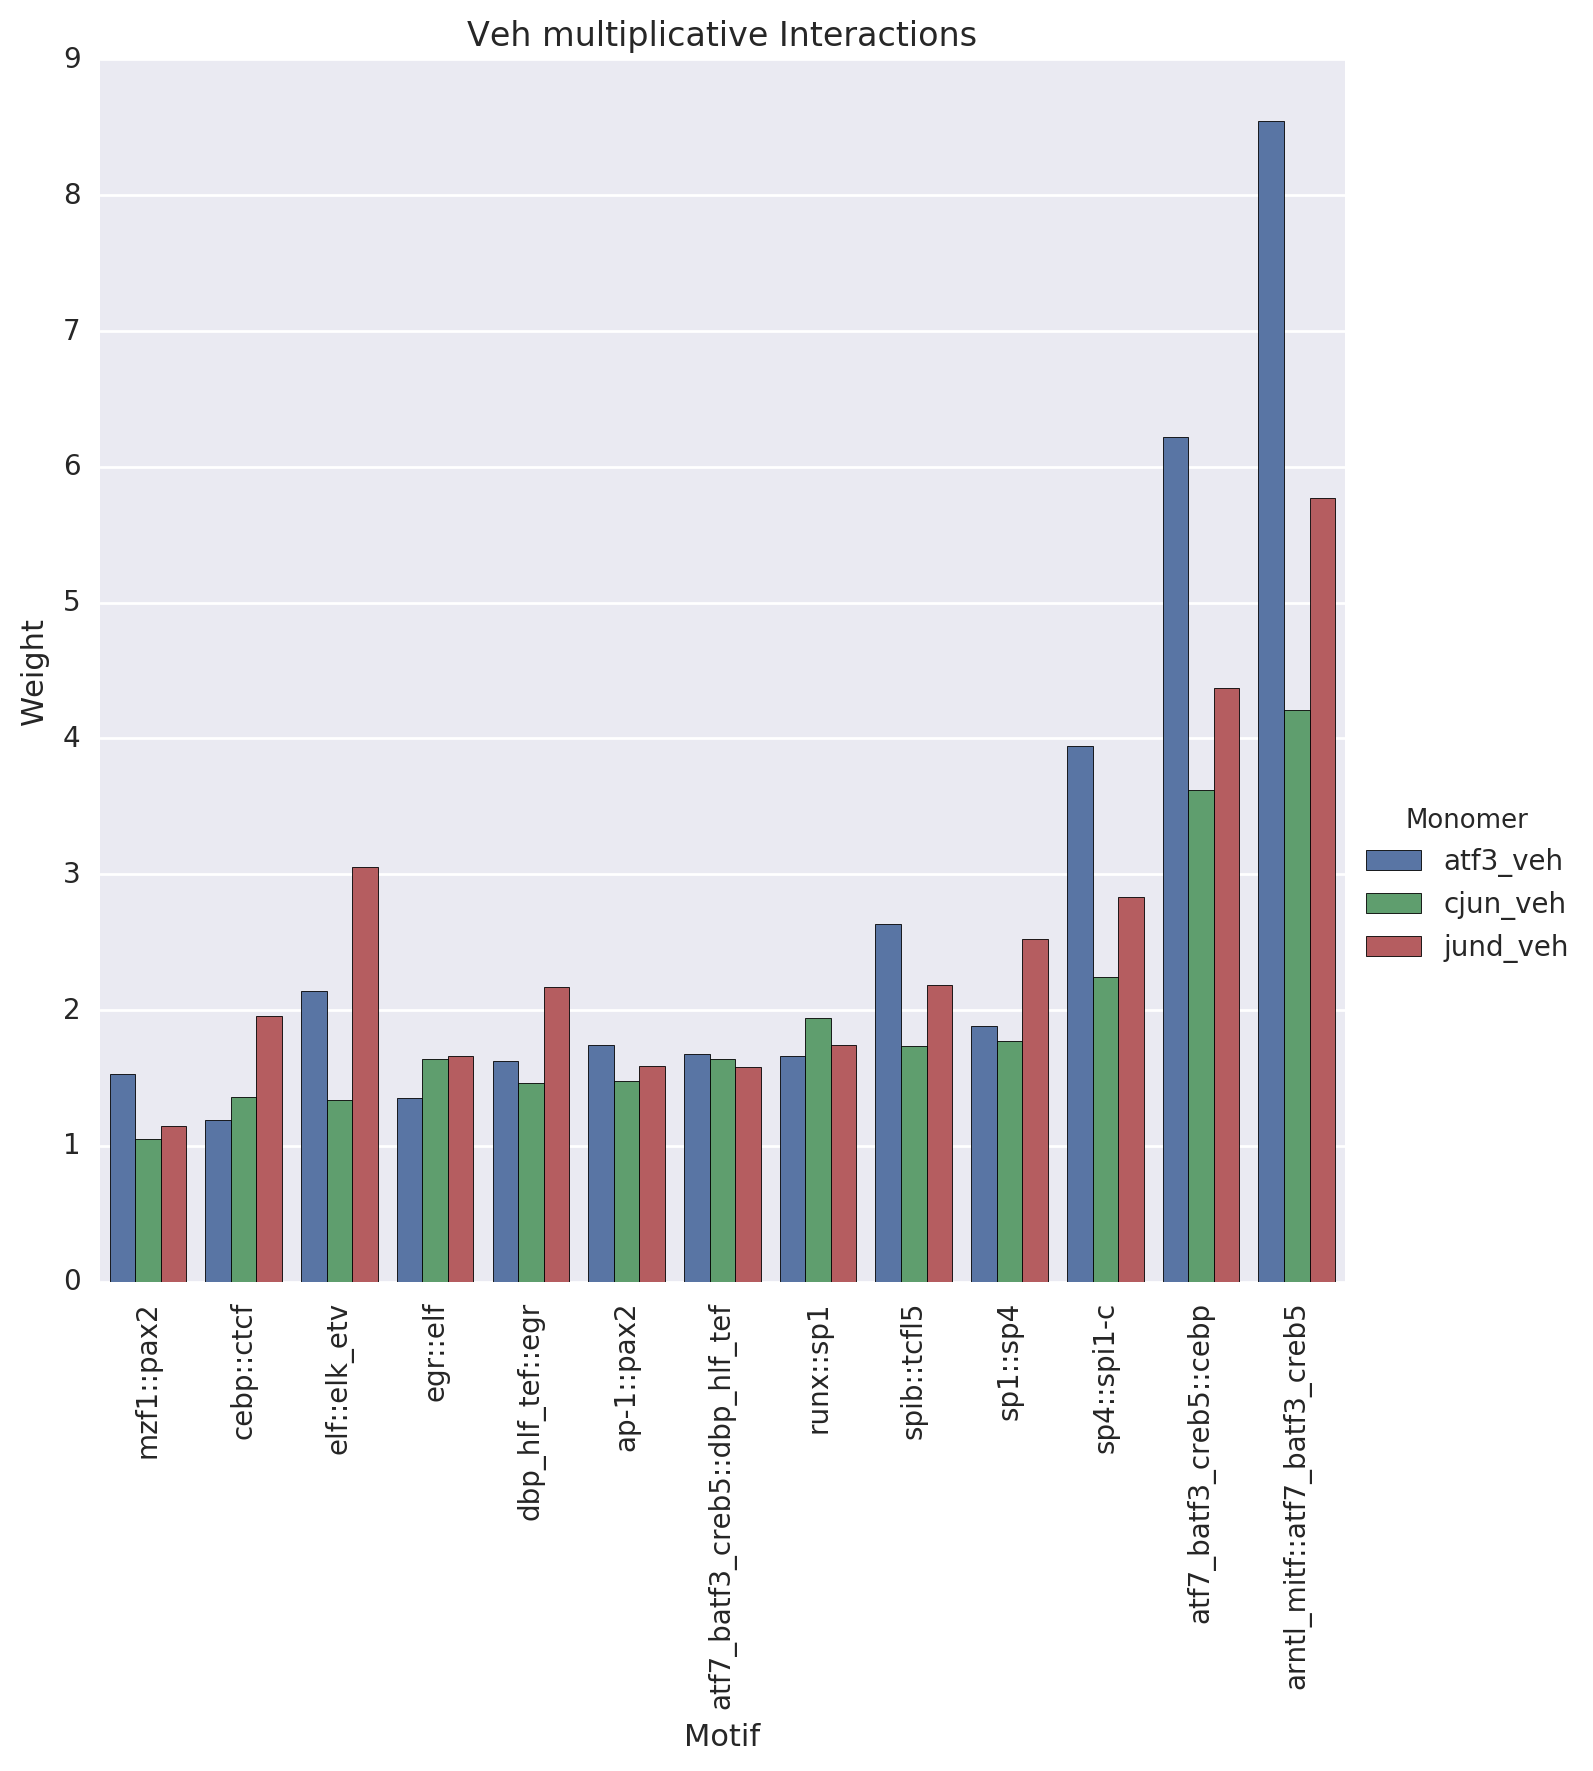

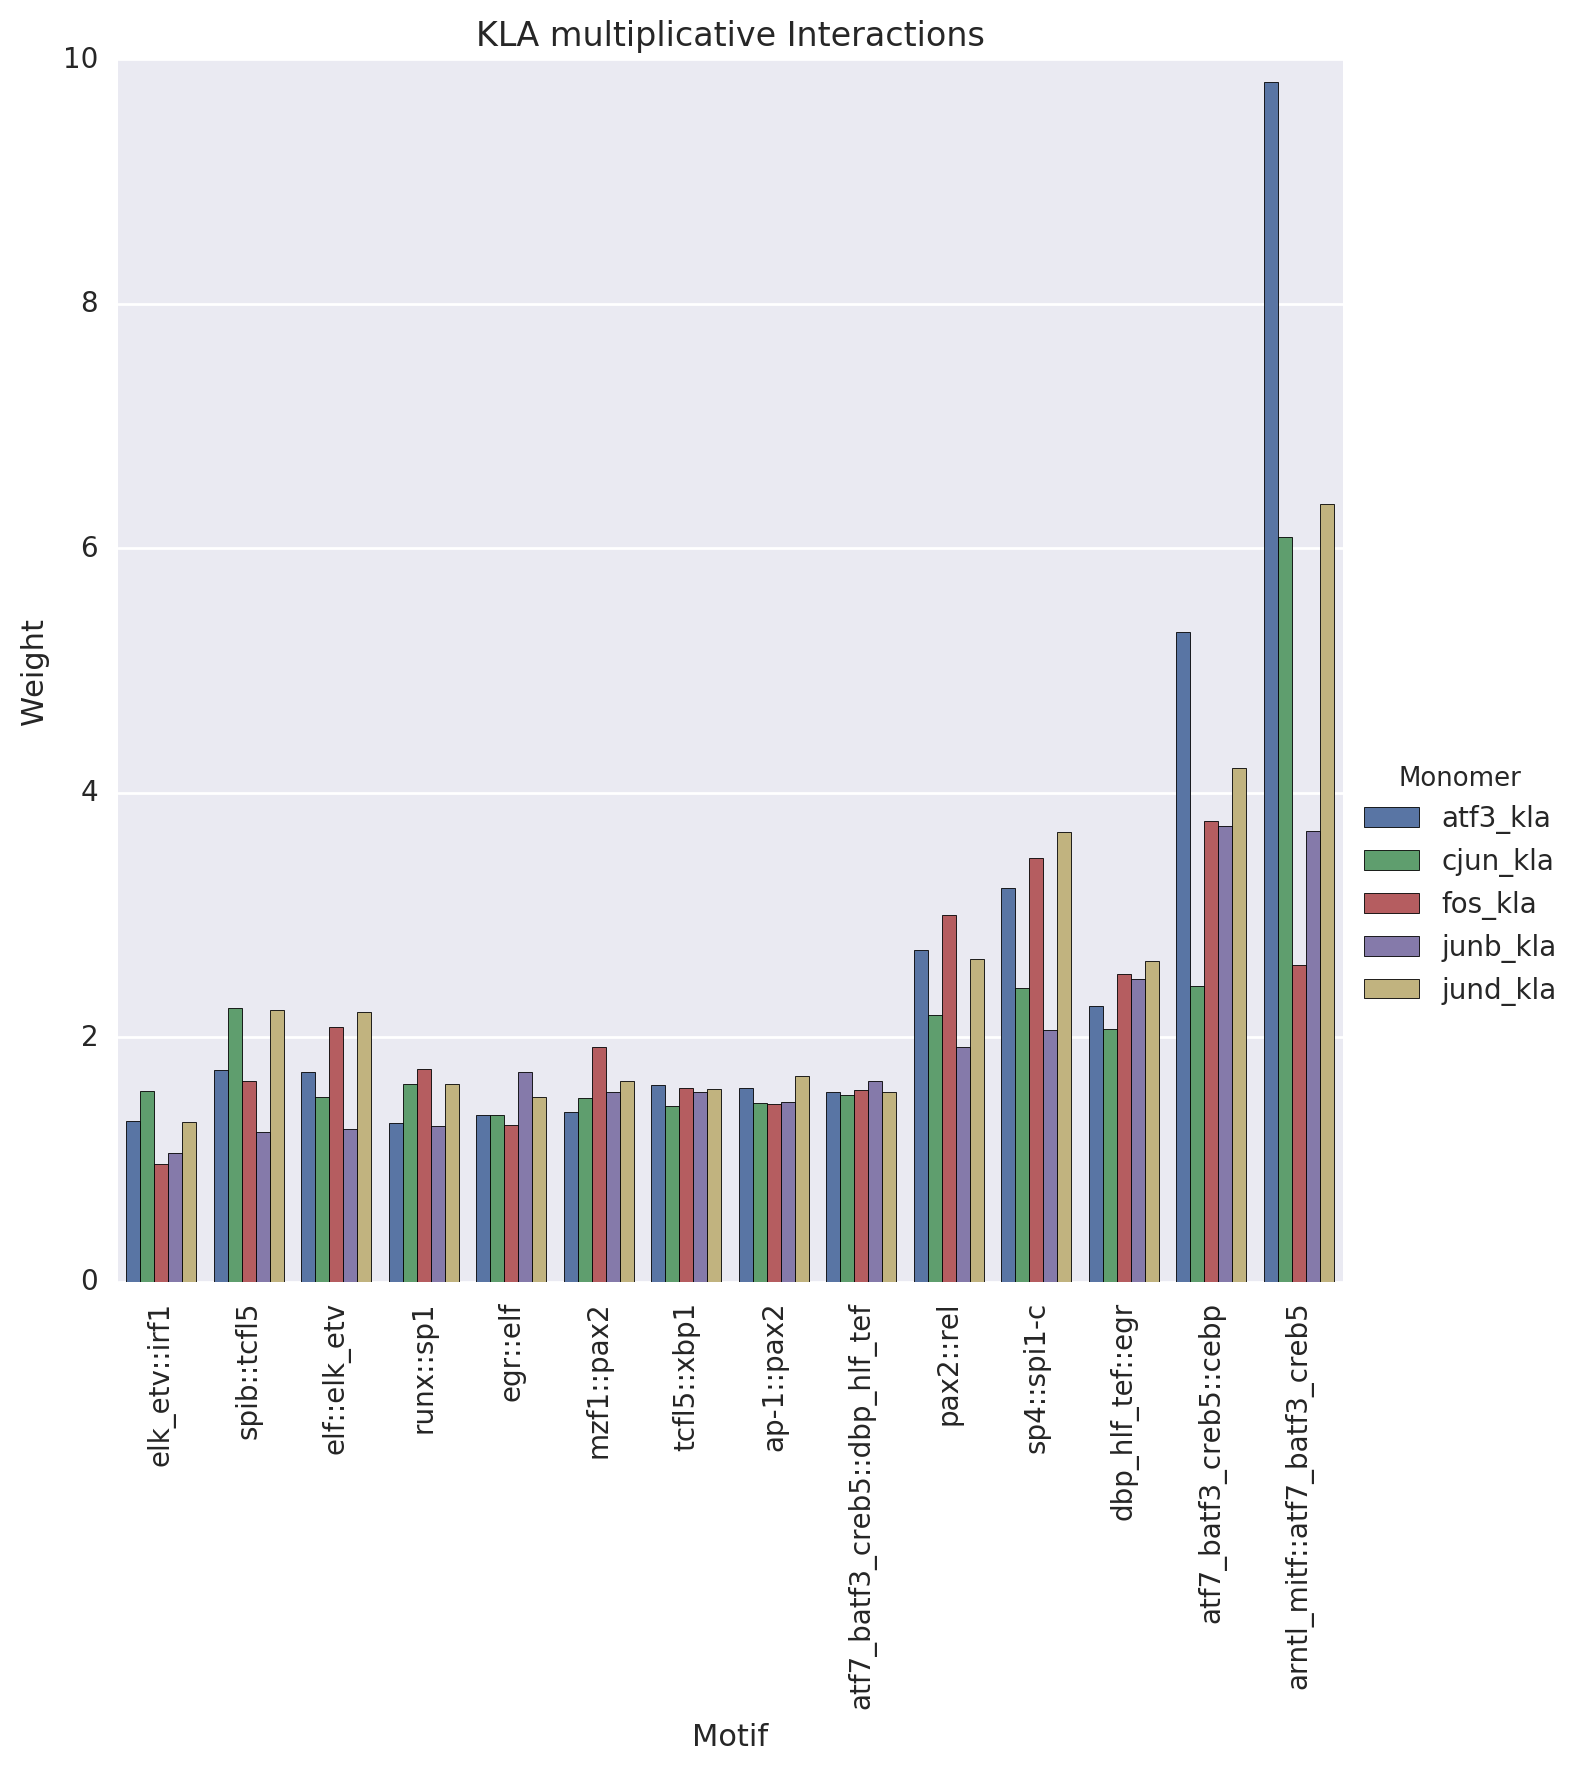

In [64]:
interaction_threshold = 1.5
data = interaction_multiplicative_veh_frame[
    (interaction_multiplicative_veh_frame.max(axis=1) > 1* interaction_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_veh','cjun_veh', 'jund_veh'],
               size=7)
plt.xticks(rotation = 90, size=10);
plt.title('Veh multiplicative Interactions')

data = interaction_multiplicative_kla_frame[
    (interaction_multiplicative_kla_frame.max(axis=1) > 1* interaction_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_kla','cjun_kla','fos_kla', 'junb_kla', 'jund_kla'],
               size=7)
plt.xticks(rotation = 90, size=10);
plt.title('KLA multiplicative Interactions')

### Stability of Coefficients

In [65]:
# calculate top motifs
motif_names = list(motif_score_frame.columns[3:])

treatment_list = []
factor_list = []
mad_list = []
ratio_list = []
weight_list = []
motifName_list = []

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        current_affinity_weights = factor_affinity_coeff_dict[monomer + '_' + treatment]
        current_affinity_weight_frame = pd.DataFrame(current_affinity_weights, 
                                                     ).T                
        mean_affinity_weights = current_affinity_weight_frame.mean(axis=1).values
        affinity_weight_mads = current_affinity_weight_frame.mad(axis=1).values
        
        ratios = np.abs(mean_affinity_weights)/ np.abs(affinity_weight_mads)
                
        treatment_list = treatment_list + [treatment] * len(mean_affinity_weights)
        factor_list = factor_list + [monomer] * len(mean_affinity_weights)
        mad_list = mad_list + list(affinity_weight_mads)
        ratio_list = ratio_list + list(ratios)
        weight_list = weight_list + list(mean_affinity_weights)
        motifName_list = motifName_list + motif_names
frame = pd.DataFrame({'Factor':factor_list,
                      'Treatment':treatment_list,
                      'MAD':mad_list,
                      'Weight/MAD Ratio': ratio_list,
                      'Log Weight/MAD Ratio': np.log2(ratio_list),
                      'Weight':weight_list,
                      'Motif': motifName_list})
        

In [66]:
weight_threshold = 1.0
top_veh_motifs = zscore_coeff_affinity_veh_frame[
    (zscore_coeff_affinity_veh_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_veh_frame.min(axis=1) < -1* weight_threshold)
].index.values

top_kla_motifs = zscore_coeff_affinity_kla_frame[
    (zscore_coeff_affinity_kla_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_kla_frame.min(axis=1) < -1* weight_threshold)
].index.values



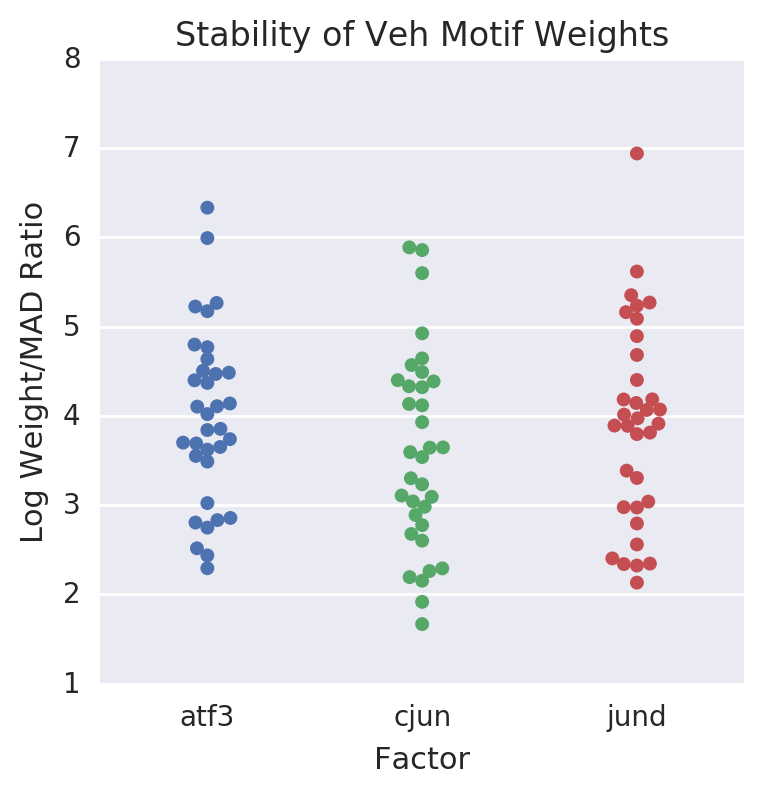

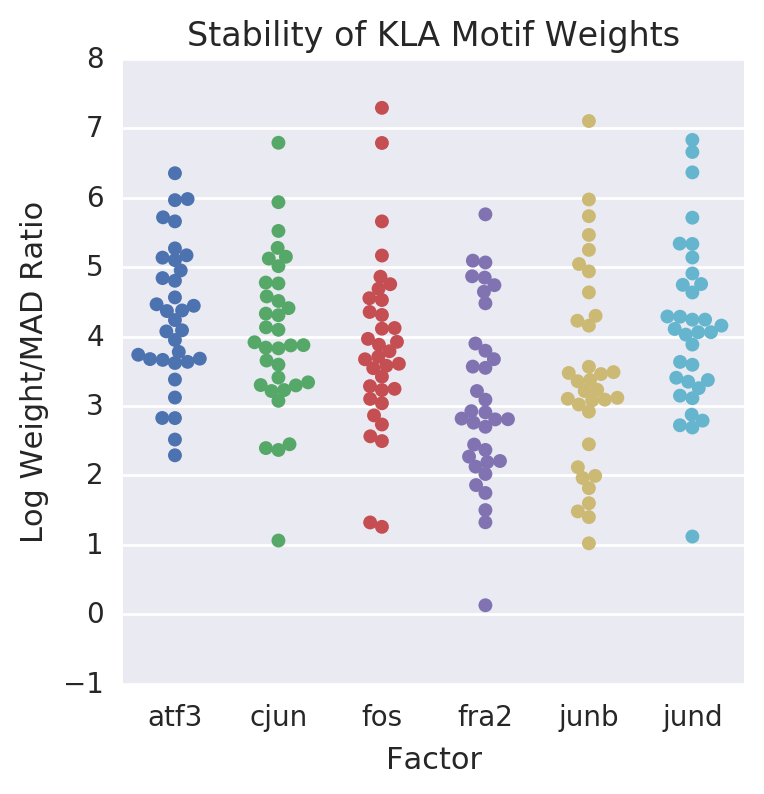

In [67]:
data = frame[(frame['Factor'].isin(['atf3','cjun', 'jund'])) &
             (frame['Treatment'] == 'veh') &
             (frame['Motif'].isin(top_veh_motifs))]
sns.factorplot(data = data, 
               x = 'Factor', 
#                y = 'Weight/MAD Ratio', 
               y = 'Log Weight/MAD Ratio',
               kind = 'swarm')
plt.title('Stability of Veh Motif Weights')
data = frame[(frame['Treatment'] == 'kla') &
             (frame['Motif'].isin(top_kla_motifs))]
sns.factorplot(data = data, 
               x = 'Factor', 
#                y = 'Weight/MAD Ratio', 
               y = 'Log Weight/MAD Ratio',
               kind = 'swarm')
plt.title('Stability of KLA Motif Weights')

# Figure 5 - Context Change after KLA treatment

In [68]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']

### Classifier Performance

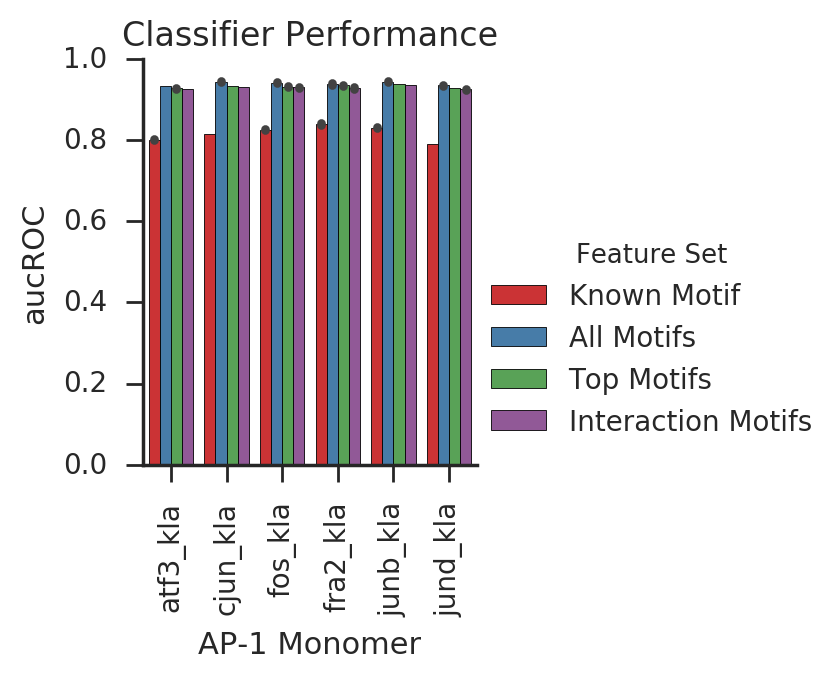

In [70]:
monomers = []
rocs = []
feature_set = []
for factor in ['atf3_kla','cjun_kla', 'fos_kla','fra2_kla', 'junb_kla','jund_kla']:
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_ap1Only_dict[factor]
    feature_set = feature_set + numIterations * ['Known Motif']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_dict[factor]
    feature_set = feature_set + numIterations * ['All Motifs']
    
#     monomers = monomers + numIterations * [factor]
#     rocs = rocs + factor_roc_dict[factor]
#     feature_set = feature_set + numIterations * ['All Combined Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_top_dict[factor]
    feature_set = feature_set + numIterations * ['Top Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_interaction_dict[factor]
    feature_set = feature_set + numIterations * ['Interaction Motifs']
    
#     monomers = monomers + numIterations * [factor]
#     rocs = rocs + factor_auc_dict_gkmSVM[factor]
#     feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'roc':rocs,
                     'Feature Set': feature_set
                     })

for treatment in ['kla']:
    factor_roc_tuples = [(x, np.mean(factor_affinity_roc_dict[x])) for x in factor_affinity_roc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_roc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='roc',
#                                     order = sorted_monomers,
                                    palette='Set1',
                                    size=3,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_05_a.svg')
        plt.show()

    

### Scatter plot for motif weights before and after Vehicle

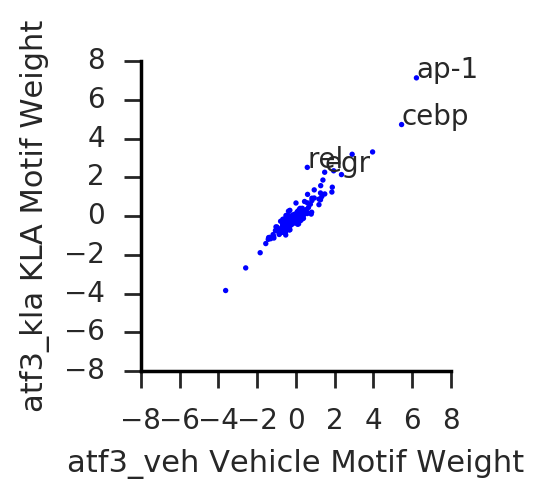

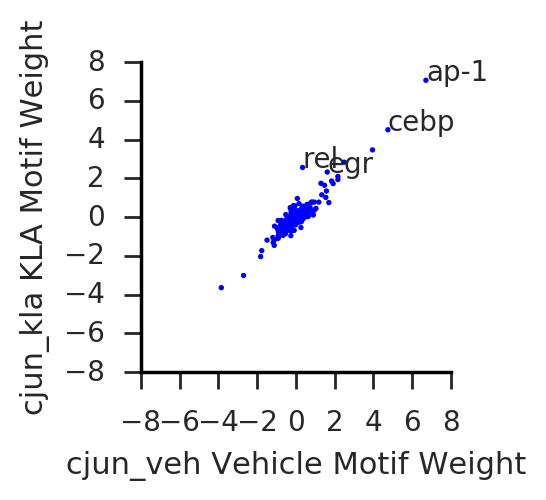

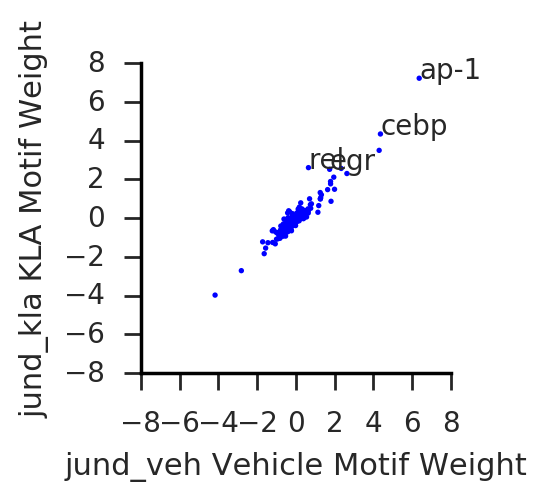

In [221]:
# scatterplot of weights
factor1 = 'jund_veh'
factor2 = 'jund_kla'
delta_threshold = 1.0
targets = ['ap-1', 'cebp', 'rel', 'egr']
# targets = []
motifs = zscore_coeff_affinity_veh_frame.index.values

for factor in ['atf3', 'cjun', 'jund']:
    factor1 = factor + '_veh'
    factor2 = factor + '_kla'
    with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                             }):
        plt.figure(figsize=(2,2))
        x_vals = zscore_coeff_affinity_veh_frame[factor1]
        y_vals = zscore_coeff_affinity_kla_frame[factor2]
        # calculate colors
        plt.scatter(x_vals,
                    y_vals,
                    marker = '.', 
                    s=15,
                    edgecolor='None')
        plt.xlabel(factor1.replace('c57bl6_','') + ' Vehicle Motif Weight')
        plt.ylabel(factor2.replace('c57bl6_','') + ' KLA Motif Weight')
        sns.despine()


        # calculate labels
        for i in range(len(x_vals)):
            x = x_vals[i]
            y = y_vals[i]
            if abs(x) >= 0.5 or abs(y) >= 0.5:
                delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
                if abs(delta) > delta_threshold or motifs[i] in targets:
                    plt.annotate(motifs[i], xy=(x,y) , size=10)
        
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        # Fix axes
        ax = plt.gca()
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        plt.show()
    # plt.savefig('./figures/figure_05_b.svg', bbox_inches='tight')


### Heatmap of difference in motif weight

In [179]:
weight_threshold= 1.0
indices = zscore_coeff_affinity_kla_frame[
    (zscore_coeff_affinity_kla_frame.max(axis=1) > 1* weight_threshold)    
].index.values

data_kla = zscore_coeff_affinity_kla_frame.ix[indices,['atf3_kla', 'cjun_kla', 'jund_kla']].values + 0.1
data_veh = zscore_coeff_affinity_veh_frame.ix[indices,['atf3_veh', 'cjun_veh', 'jund_veh']].values + 0.1
differences_frame = pd.DataFrame(data_kla / data_veh)
differences_frame.columns = ['atf3', 'cjun', 'jund']
differences_frame.index = indices

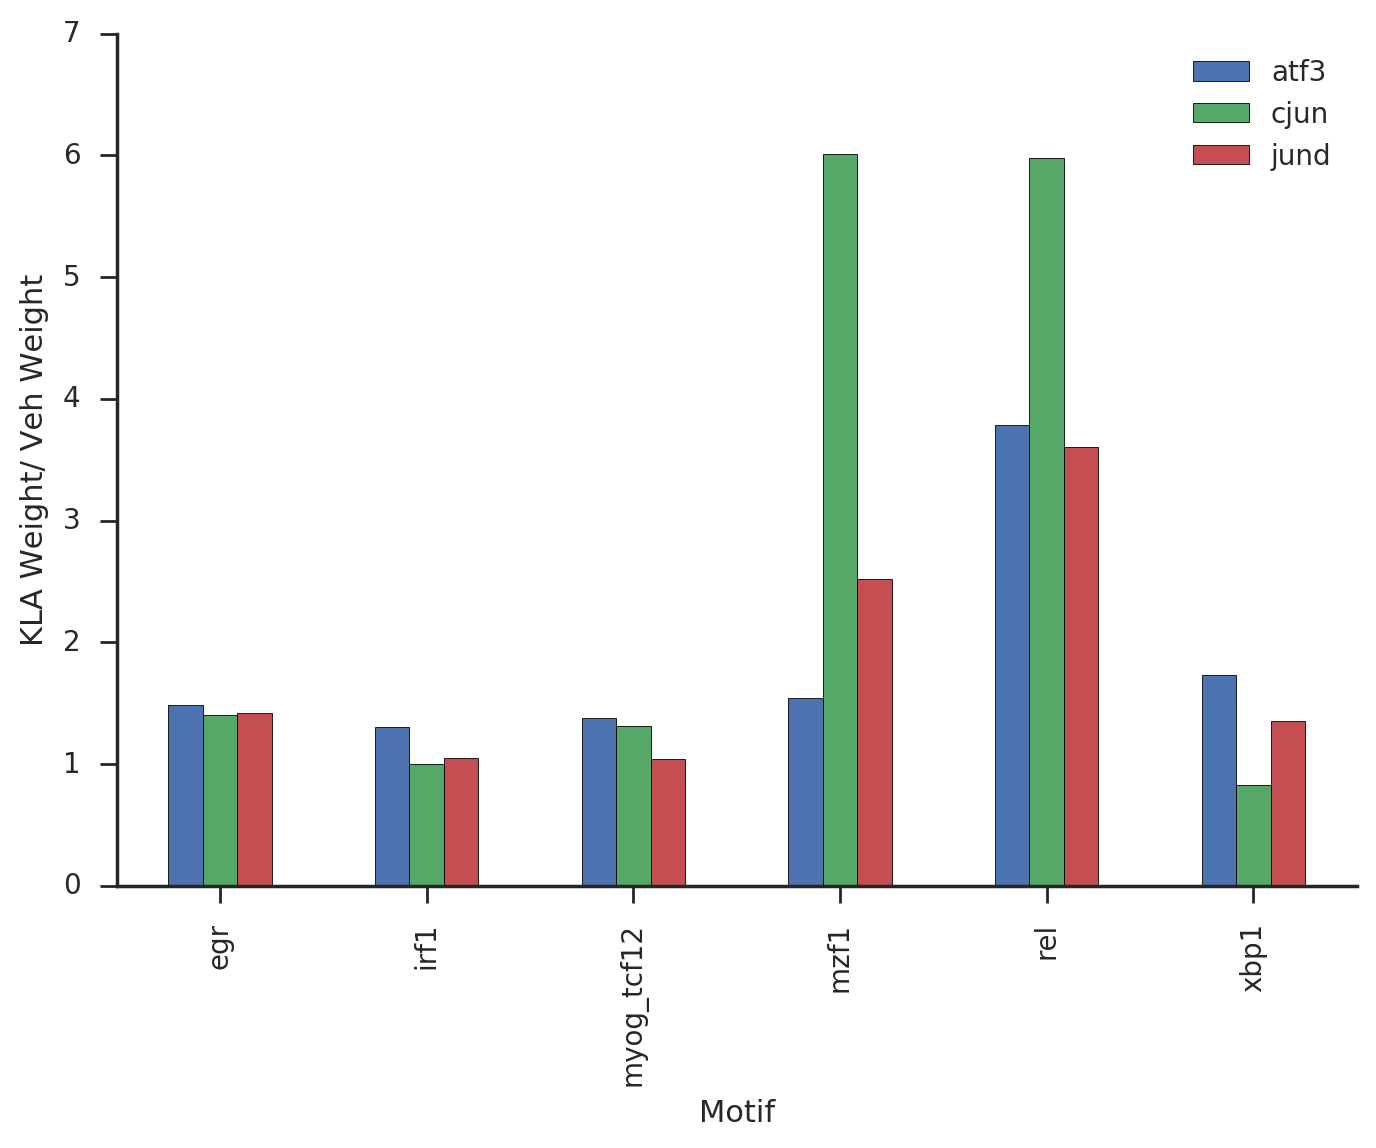

In [191]:

fold_threshold = 1.25

with sns.axes_style('ticks'):
    fig = plt.figure(figsize=(2,2))
    differences_frame[differences_frame.abs().max(axis=1) >=fold_threshold].plot(kind='bar')
    plt.ylabel('KLA Weight/ Veh Weight')
    plt.xlabel('Motif')
    sns.despine()

### Visualization of significant KLA motif Weights

### Barplots showing inducible RNA-seq expression for motifs that are different between vehicle and KLA

In [201]:
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/> raw_untreated.tsv



	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-26/
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26/
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR

In [210]:
!getDiffExpression.pl ./raw_untreated.tsv veh veh kla kla -AvsA>./diff_expression.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats veh vs. kla:
		Total Genes: 24453
		Total Up-regulated in kla vs. veh: 78 (0.319%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in kla vs. veh: 0 (0.000%) [log2fold<-1, FDR<0.05]



In [212]:
diffExpression_frame = pd.read_csv('diff_expression.tsv', sep='\t')

In [218]:
diff_expressed_genes = [x.split('|')[0].upper() for x in diffExpression_frame[diffExpression_frame['veh vs. kla p-value'] < 0.01]['Annotation/Divergence']]

In [220]:
sorted(diff_expressed_genes)

['ADM',
 'ADORA2B',
 'AREG',
 'ARL5C',
 'ART2A-PS',
 'BCL2A1B',
 'BCL2A1D',
 'BIRC3',
 'BTG1',
 'BTG2',
 'CBX2',
 'CCL12',
 'CCL2',
 'CCL3',
 'CCL4',
 'CCL7',
 'CCL9',
 'CCRL2',
 'CD14',
 'CD40',
 'CD83',
 'CDC42EP2',
 'CDK5R1',
 'CDKN1A',
 'CFLAR',
 'CLCF1',
 'CLEC4E',
 'CSF2',
 'CSRNP1',
 'CXCL1',
 'CXCL10',
 'CXCL2',
 'D630024D03RIK',
 'DNAJB4',
 'DUSP1',
 'DUSP2',
 'DUSP4',
 'DUSP5',
 'DUSP8',
 'E230013L22RIK',
 'E2F8',
 'EGR1',
 'EGR2',
 'EGR3',
 'EHD1',
 'EID3',
 'ERRFI1',
 'F3',
 'FLRT3',
 'FOS',
 'GADD45B',
 'GBP5',
 'GDF15',
 'GEM',
 'GM14023',
 'GM6377',
 'GPR84',
 'GPR85',
 'HILPDA',
 'ICAM1',
 'IER2',
 'IER3',
 'IER5L',
 'IFNB1',
 'IFRD1',
 'IL10',
 'IL12A',
 'IL12B',
 'IL1A',
 'IL1B',
 'IL23A',
 'IRF1',
 'IRG1',
 'ISG15',
 'JUNB',
 'KCNJ9',
 'KCTD12',
 'KDM6B',
 'KLF2',
 'KLF6',
 'LIF',
 'LRRC63',
 'MAFF',
 'MARCKSL1',
 'MEFV',
 'MIR1198',
 'MIR155HG',
 'MIR221',
 'MIR6963',
 'MKI67',
 'MNDA',
 'MYC',
 'NFKBIA',
 'NFKBIB',
 'NFKBID',
 'NFKBIE',
 'NFKBIZ',
 'NLRP3',
 'NOCT'

In [80]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

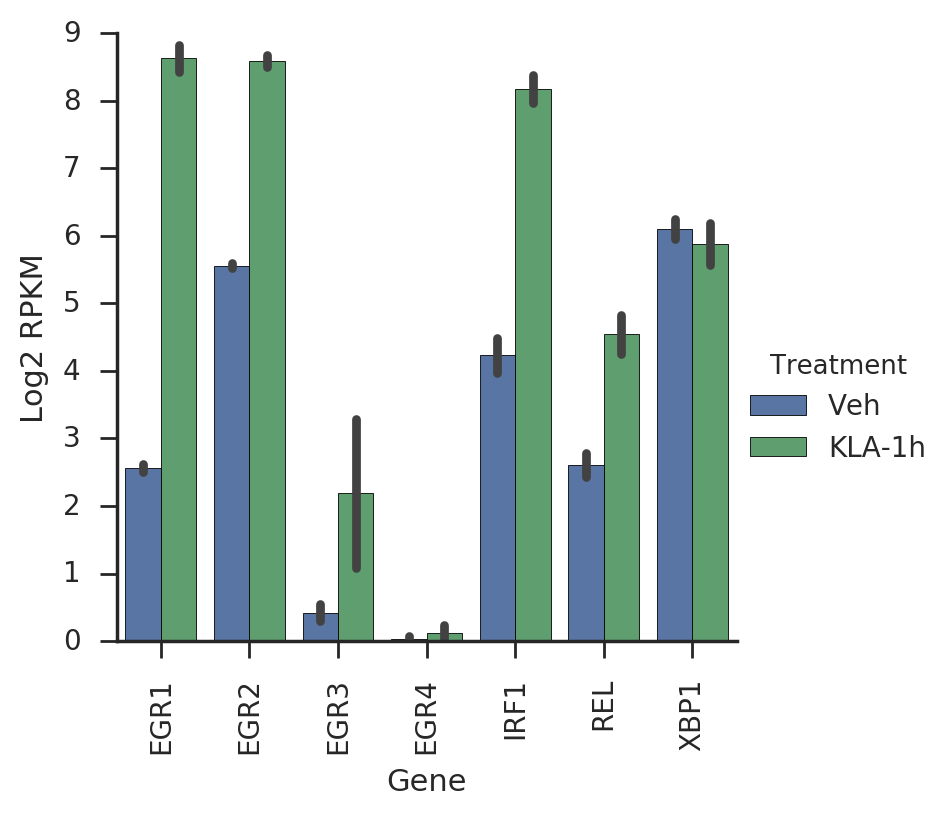

In [219]:
# gene_list = ['REL', 'EGR1', 'ESR1', 'ESR2', 'RXRA', 'RXRB', 'IRF1', 'IRF7', 'IRF8', 'IRF9']
gene_list = ['EGR1', 'REL', 'EGR2', 'EGR3', 'EGR4', 'IRF1', 'XBP1']#, 'RXRA', 'RXRB','PPARG','NR1H2']


plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Treatment', kind='bar', 
                   order = sorted(gene_list),
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)

plt.xticks(rotation=90)


# Figure 6 - Dimer Analysis in KLA

#### KLA

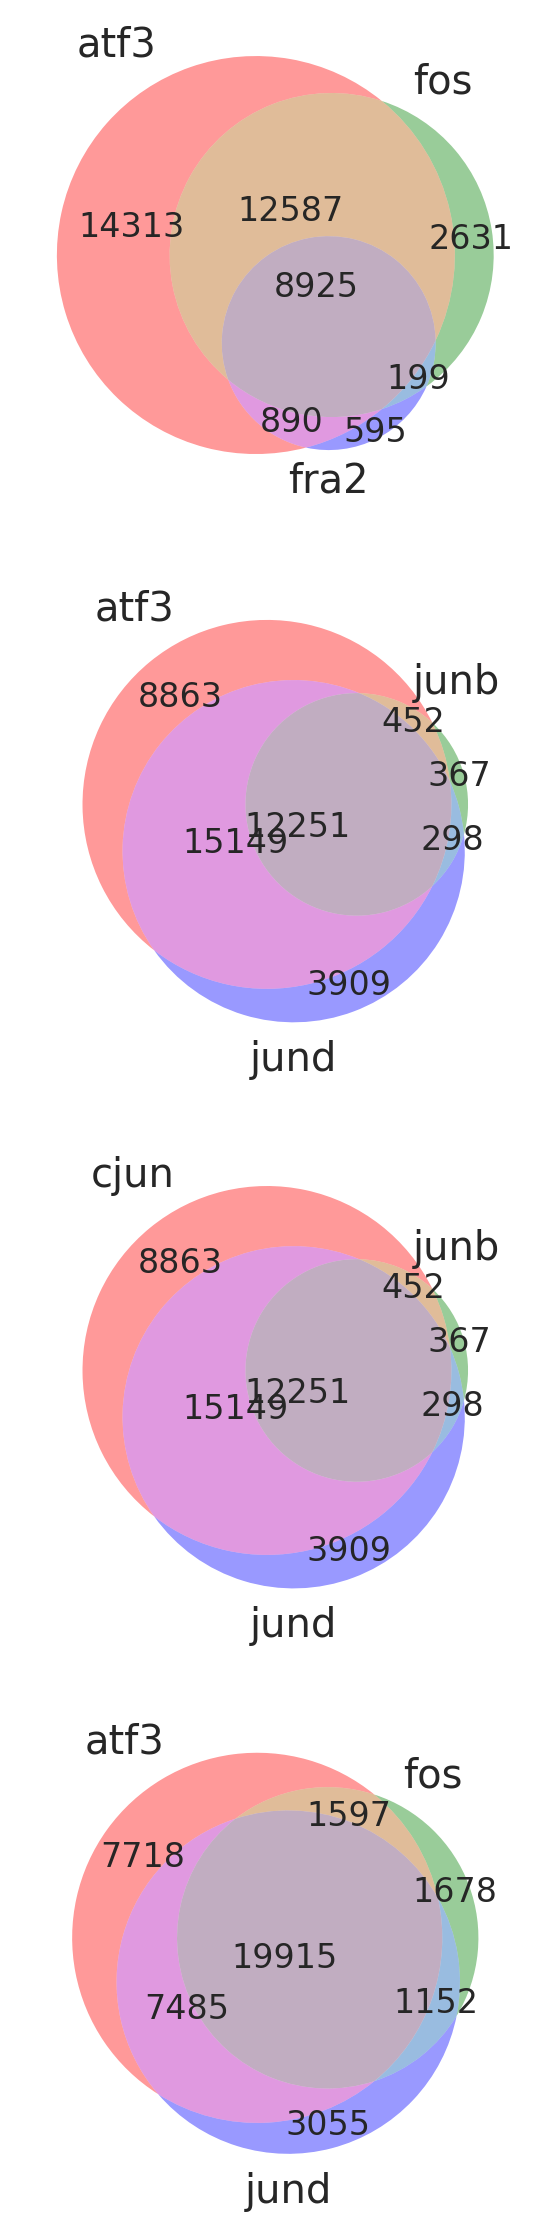

In [39]:
plt.figure(figsize=(3.5,14))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_kla'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_kla'] > 0].index.values)
fos_indices = set(summary_frame[summary_frame['c57bl6_fos_kla'] > 0].index.values)
fra2_indices = set(summary_frame[summary_frame['c57bl6_fra2_kla'] > 0].index.values)
junb_indices = set(summary_frame[summary_frame['c57bl6_junb_kla'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_kla'] > 0].index.values)
plt.subplot(4,1,1)
matplotlib_venn.venn3([atf3_indices, fos_indices, fra2_indices], set_labels=['atf3', 'fos', 'fra2'])
plt.subplot(4,1,2)
matplotlib_venn.venn3([atf3_indices, junb_indices, jund_indices], set_labels=['atf3', 'junb', 'jund'])
plt.subplot(4,1,3)
matplotlib_venn.venn3([atf3_indices, junb_indices, jund_indices], set_labels=['cjun', 'junb', 'jund'])
plt.subplot(4,1,4)
matplotlib_venn.venn3([atf3_indices, fos_indices, jund_indices], set_labels=['atf3', 'fos', 'jund'])

plt.savefig('./figures/figure_02_c_venn_kla.svg')
plt.savefig('./figures/figure_02_c_venn_kla.png')

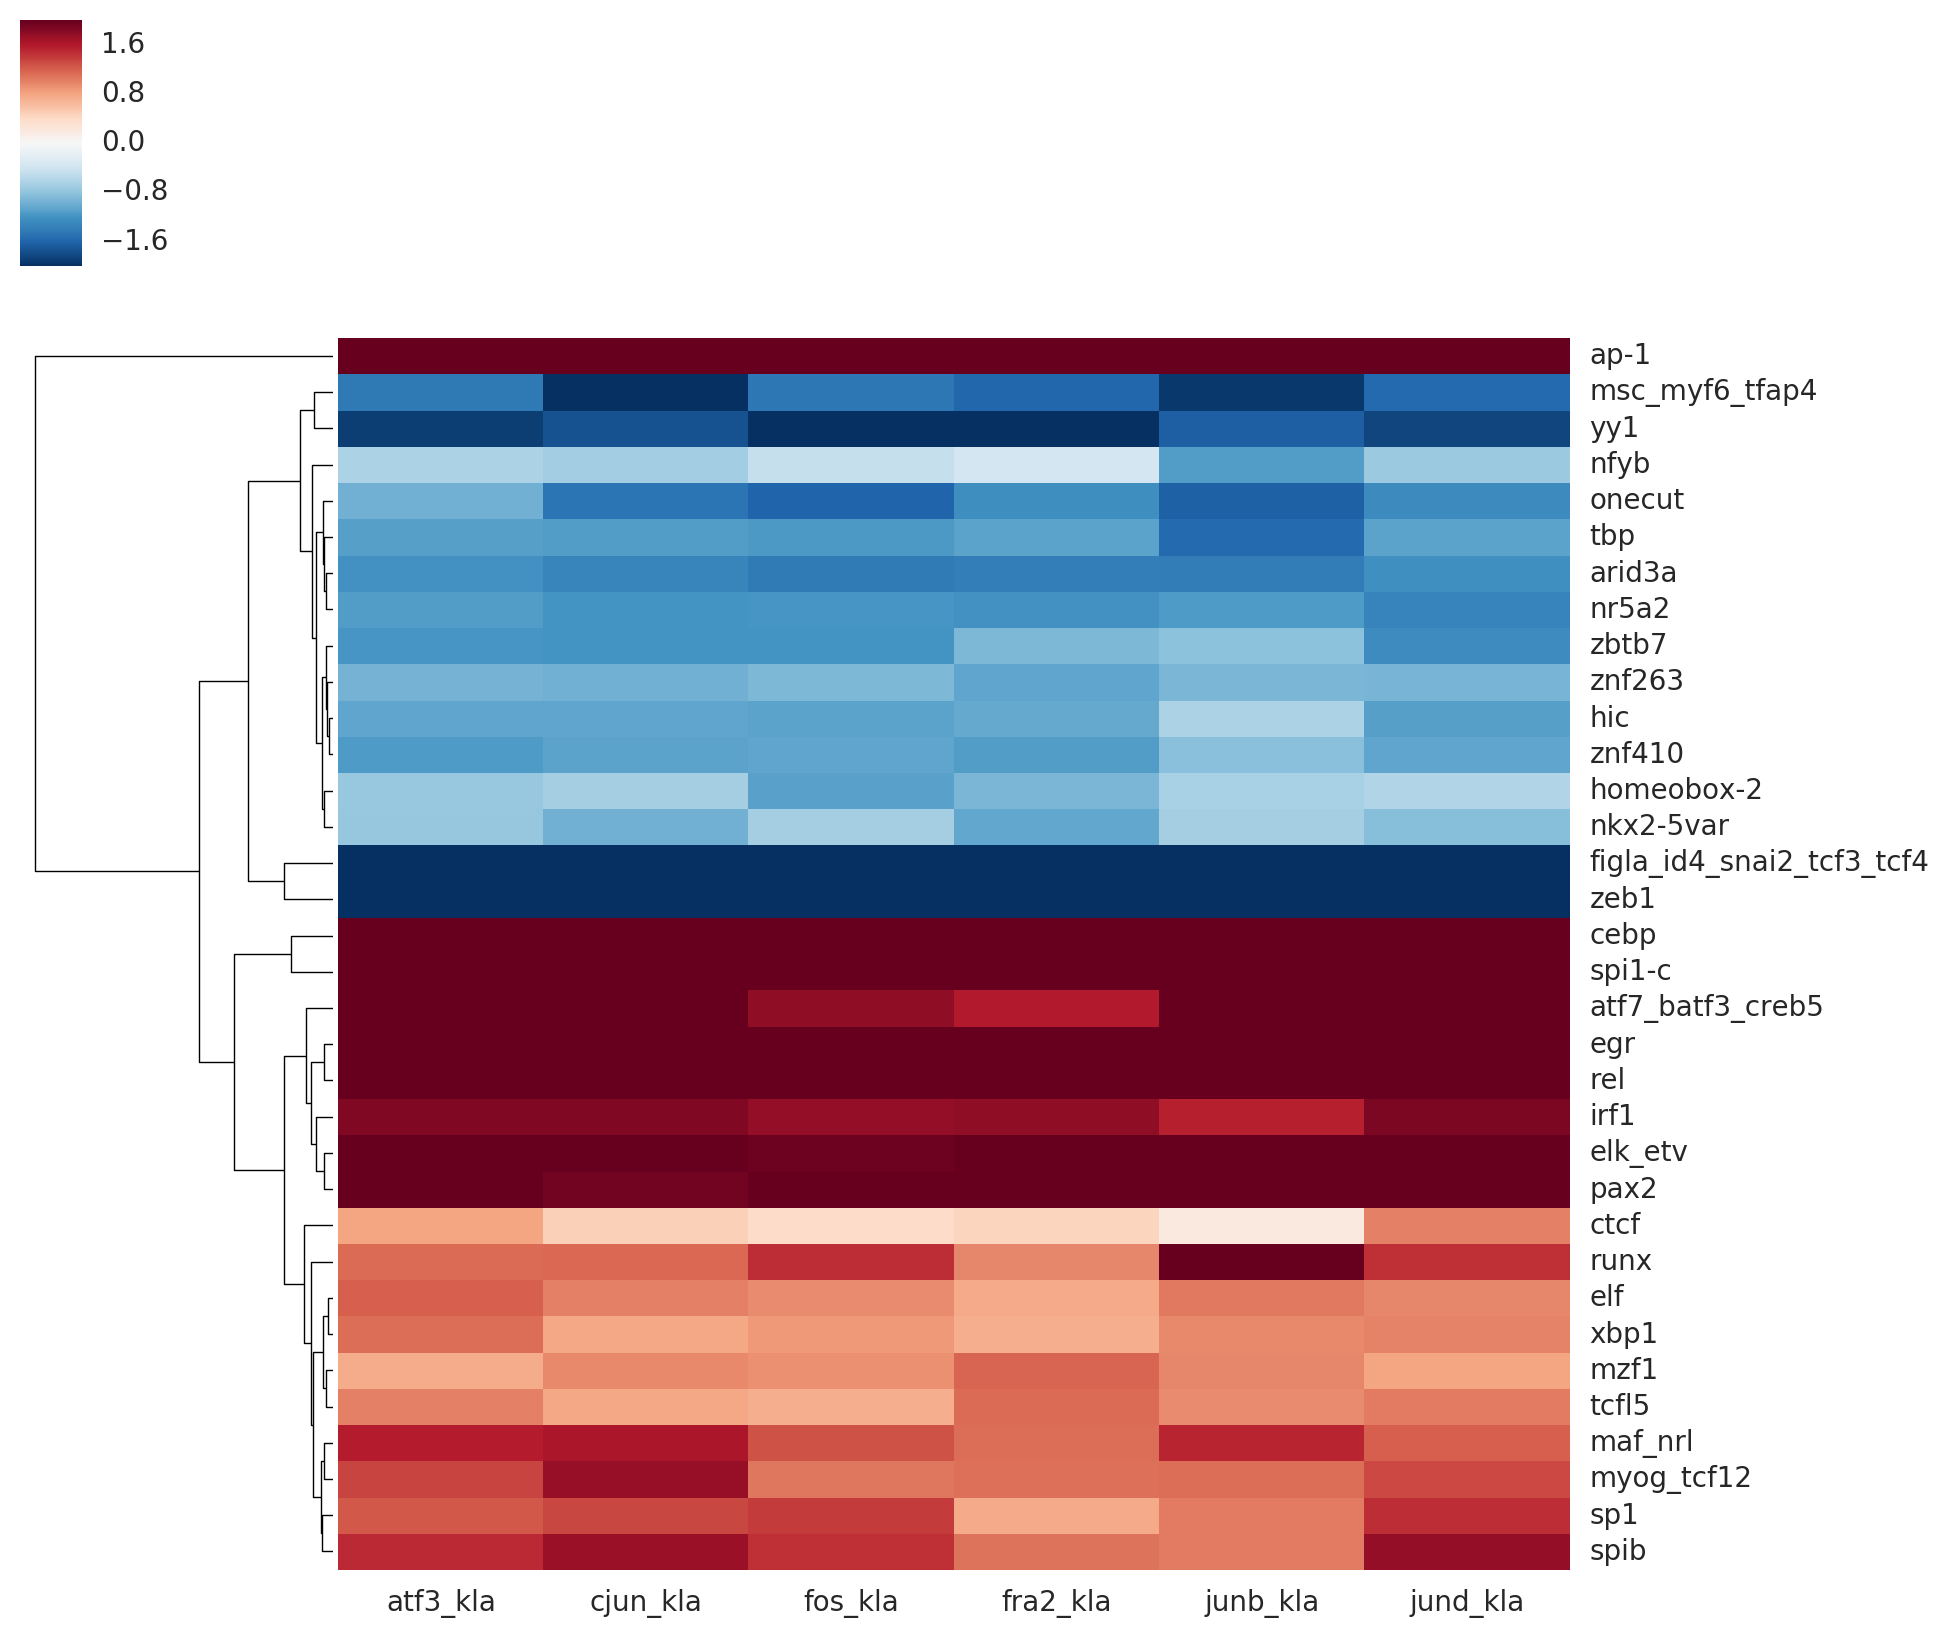

In [233]:
weight_threshold = 1.0
data = zscore_coeff_affinity_kla_frame[
    (zscore_coeff_affinity_kla_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_kla_frame.min(axis=1) < -1* weight_threshold)
]
cg = sns.clustermap(data, 
                    vmin = -2,
                    vmax=2,
                    col_cluster = False,
                    yticklabels=True)

plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=0);


(0, 34)

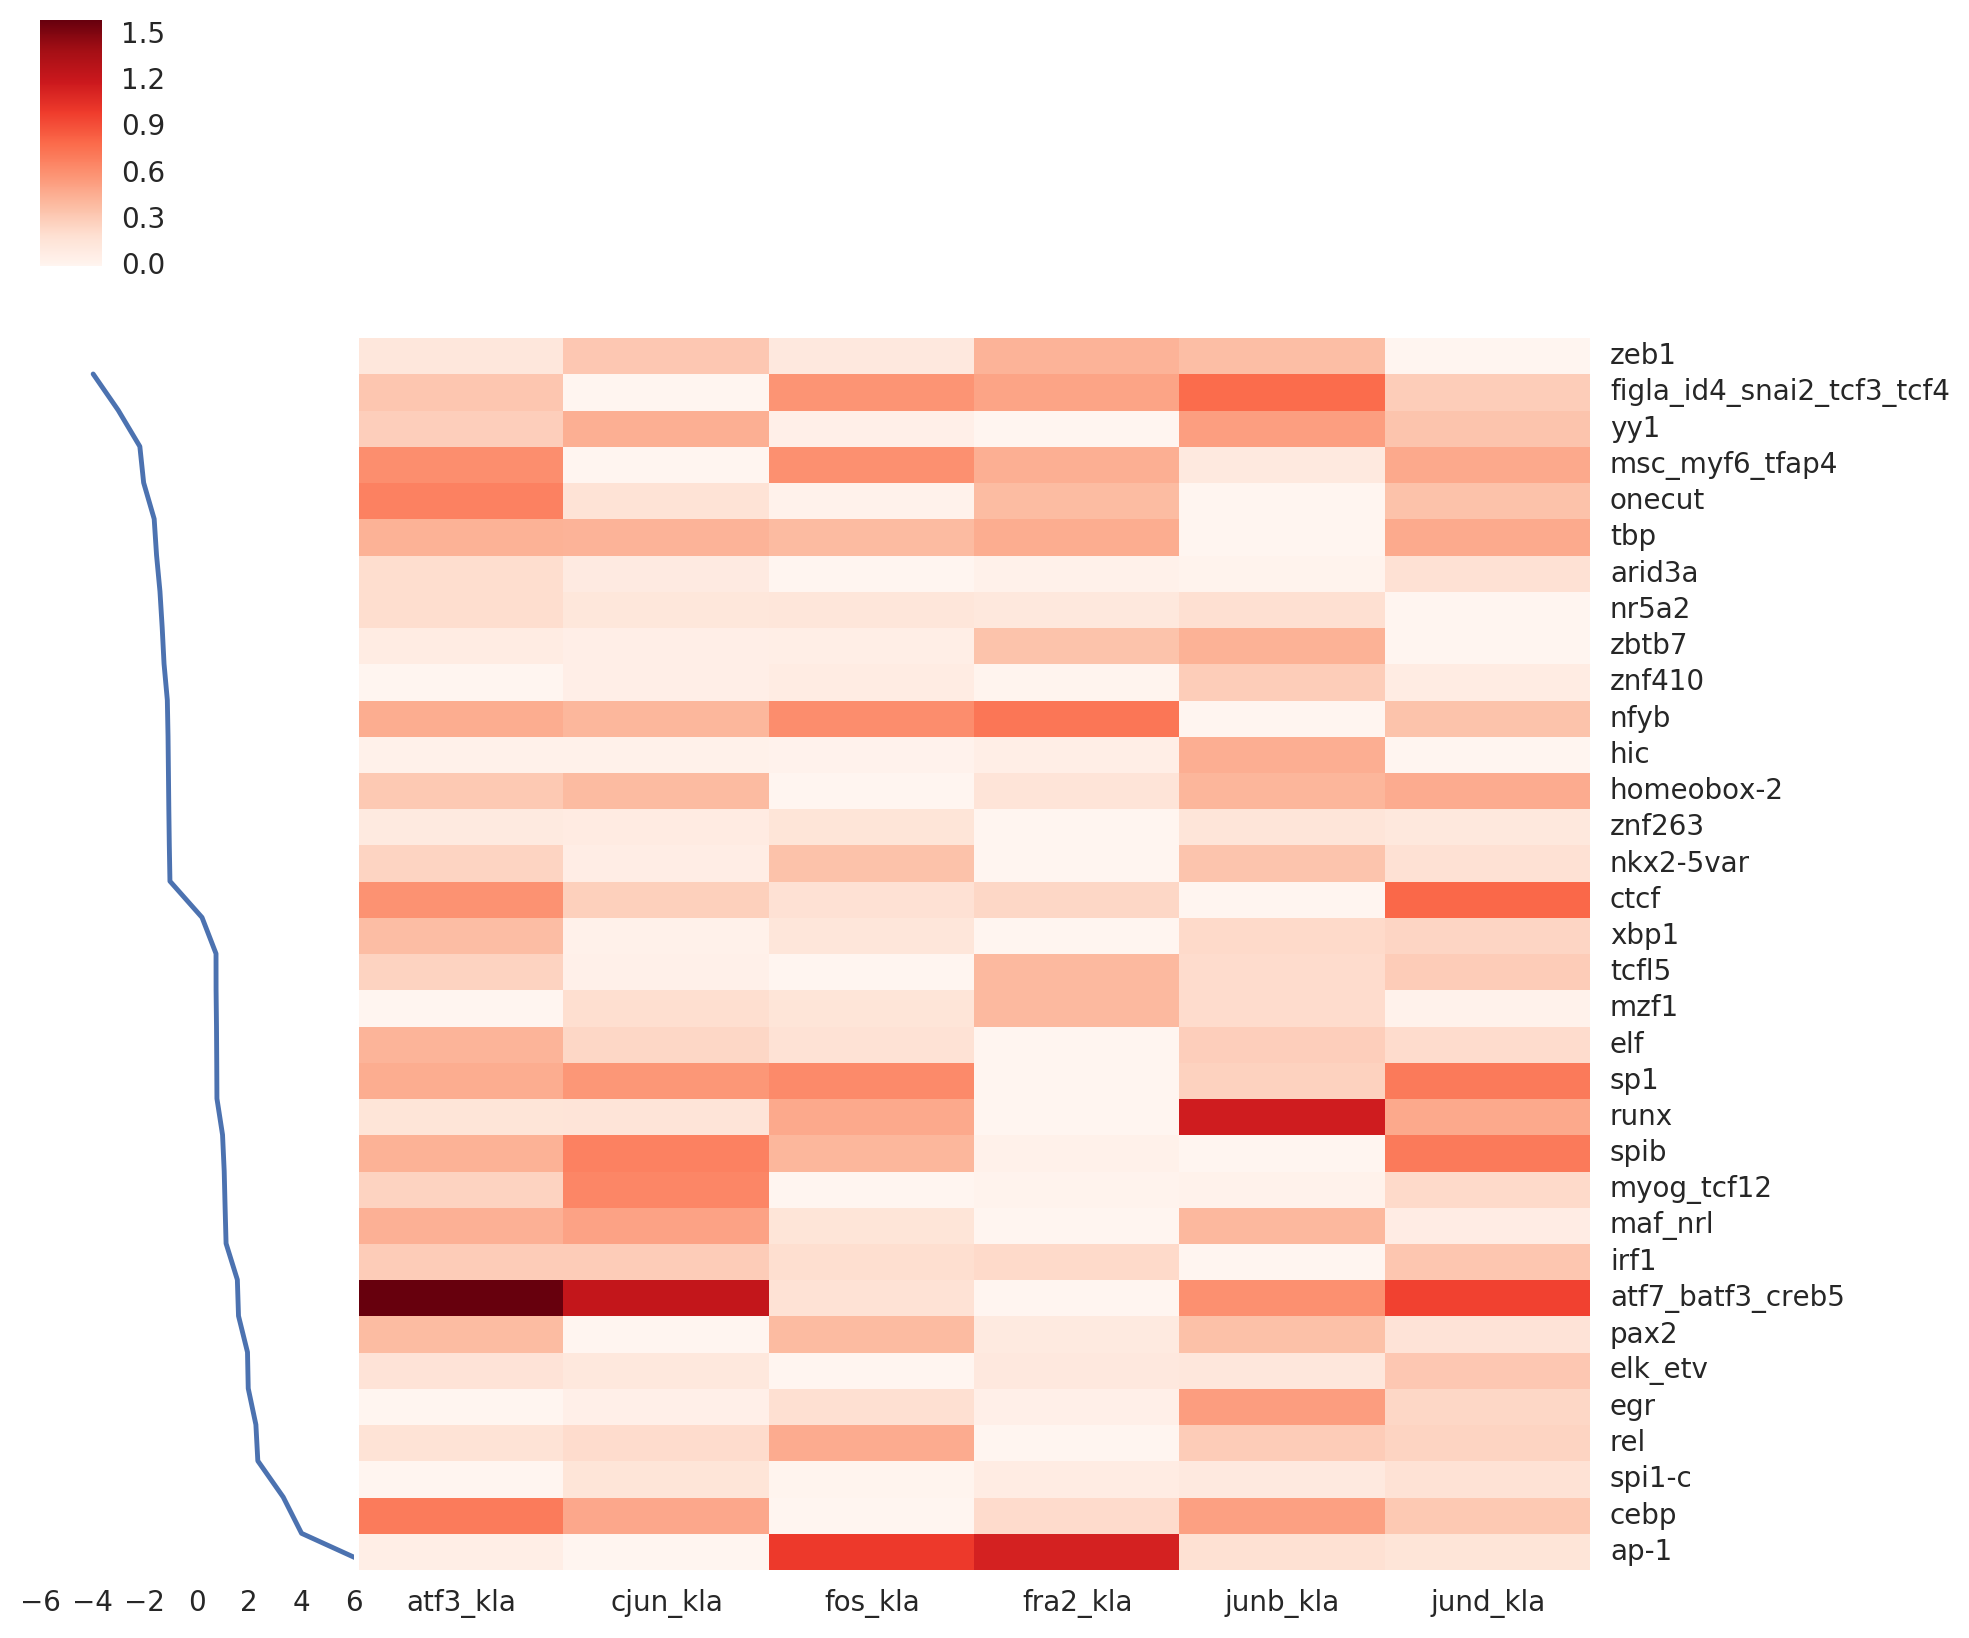

In [231]:
weight_threshold = 1.0
data = zscore_coeff_affinity_kla_frame[
    (zscore_coeff_affinity_kla_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_kla_frame.min(axis=1) < -1* weight_threshold)
]
# data = zscore_coeff_combined_kla_frame[
#     (zscore_coeff_combined_kla_frame.max(axis=1) > 1* weight_threshold) |
#     (zscore_coeff_combined_kla_frame.min(axis=1) < -1* weight_threshold)
# ]
mins = data.min(axis=1)

differences = data[[]]
for col in data.columns:
    differences[col] = data[col].values - mins.values
mins.sort()
sorted_differences = differences.ix[mins.index.values,:]
cg = sns.clustermap(sorted_differences,
                    col_cluster=False,
                   row_cluster=False,
                   cmap='Reds')
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
cg.ax_row_dendrogram.clear()
cg.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
cg.ax_row_dendrogram.set_yticks([])
cg.ax_row_dendrogram.set_xlim(-6,6)
cg.ax_row_dendrogram.set_ylim(0,len(mins))

In [114]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
ap1_dimers = []
for i in range(len(ap1_members) - 1):
    for j in range(i+1, len(ap1_members)):
        ap1_dimers.append((ap1_members[i], ap1_members[j]))

In [119]:
np.array(list(set(monomer1_indices).intersection(set(monomer2_indices))))

array(['Merged-chr17-87168444-12', 'Merged-chr8-35705699-9',
       'Merged-chr11-115699455-22', ..., 'Merged-chr10-10457200-29',
       'Merged-chr2-32038939-23', 'Merged-chr11-62550057-24'], 
      dtype='<U25')

In [129]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_affinity_coeff_dimer_dict = {}
factor_affinity_roc_dimer_dict = {}
factor_affinity_precision_dimer_dict = {}
factor_affinity_score_dimer_dict = {}
factor_affinity_testLabel_dimer_dict = {}

for treatment in ['kla']:
    for dimer in ap1_dimers:
        monomer1 = dimer[0]
        monomer2 = dimer[1]
        
        monomer1_indices = summary_frame[summary_frame[strain + '_' + monomer1 + '_' + treatment] > 0.0].index.values
        monomer1_background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer1 + '_' + treatment + '-background'].index.values
        
        monomer2_indices = summary_frame[summary_frame[strain + '_' + monomer2 + '_' + treatment] > 0.0].index.values
        monomer2_background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer2 + '_' + treatment + '-background'].index.values
        
        dimer_indices = np.array(list(set(monomer1_indices).intersection(set(monomer2_indices))))
        # select subset of background indices to use
        shuffle(monomer1_background_indices)
        monomer1_background_indices = monomer1_background_indices[:np.ceil(background_ratio*len(dimer_indices)/2)]
        shuffle(monomer2_background_indices)
        monomer2_background_indices = monomer2_background_indices[:np.ceil(background_ratio*len(dimer_indices)/2)]
        
        background_indices = np.concatenate([monomer1_background_indices, monomer2_background_indices])

        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(dimer_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])

        labels = pd.Series(data = [True] * len(dimer_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_affinity_roc_dimer_dict['_'.join(dimer)] = all_affinity_rocs
        factor_affinity_precision_dimer_dict['_'.join(dimer)] = all_affinity_precisions
        factor_affinity_coeff_dimer_dict['_'.join(dimer)] = all_affinity_coefficients
        factor_affinity_score_dimer_dict['_'.join(dimer)] = all_affinity_scores
        factor_affinity_testLabel_dimer_dict['_'.join(dimer)] = all_affinity_testLabels
        
        print('_'.join(dimer) + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

16491 32983
atf3_cjun_kla roc: 0.947948722843 precision: 0.943326176139
21512 43024
atf3_fos_kla roc: 0.947237886097 precision: 0.94339638713
9815 19631
atf3_fra2_kla roc: 0.952824688199 precision: 0.949092719282
12703 25407
atf3_junb_kla roc: 0.951596804136 precision: 0.948322524187
27400 54800
atf3_jund_kla roc: 0.940835005062 precision: 0.935296673318
14247 28495
cjun_fos_kla roc: 0.950563832988 precision: 0.947008087458
7801 15603
cjun_fra2_kla roc: 0.955722498934 precision: 0.95392800994
10013 20027
cjun_junb_kla roc: 0.952771683853 precision: 0.948809670624
16305 32611
cjun_jund_kla roc: 0.947325253779 precision: 0.944065539765
9124 18248
fos_fra2_kla roc: 0.953814866189 precision: 0.950605044019
12094 24188
fos_junb_kla roc: 0.950807528339 precision: 0.947937006634
21067 42135
fos_jund_kla roc: 0.946271366482 precision: 0.941202018443
6743 13487
fra2_junb_kla roc: 0.955736516902 precision: 0.951977574355
9804 19608
fra2_jund_kla roc: 0.95051550579 precision: 0.948182990931
12549

In [130]:
zscore_coeff_affinity_dimer_frame = calculate_zscore_weights(factor_affinity_coeff_dimer_dict,
                                                              all_standardized_score_frame.columns.values)

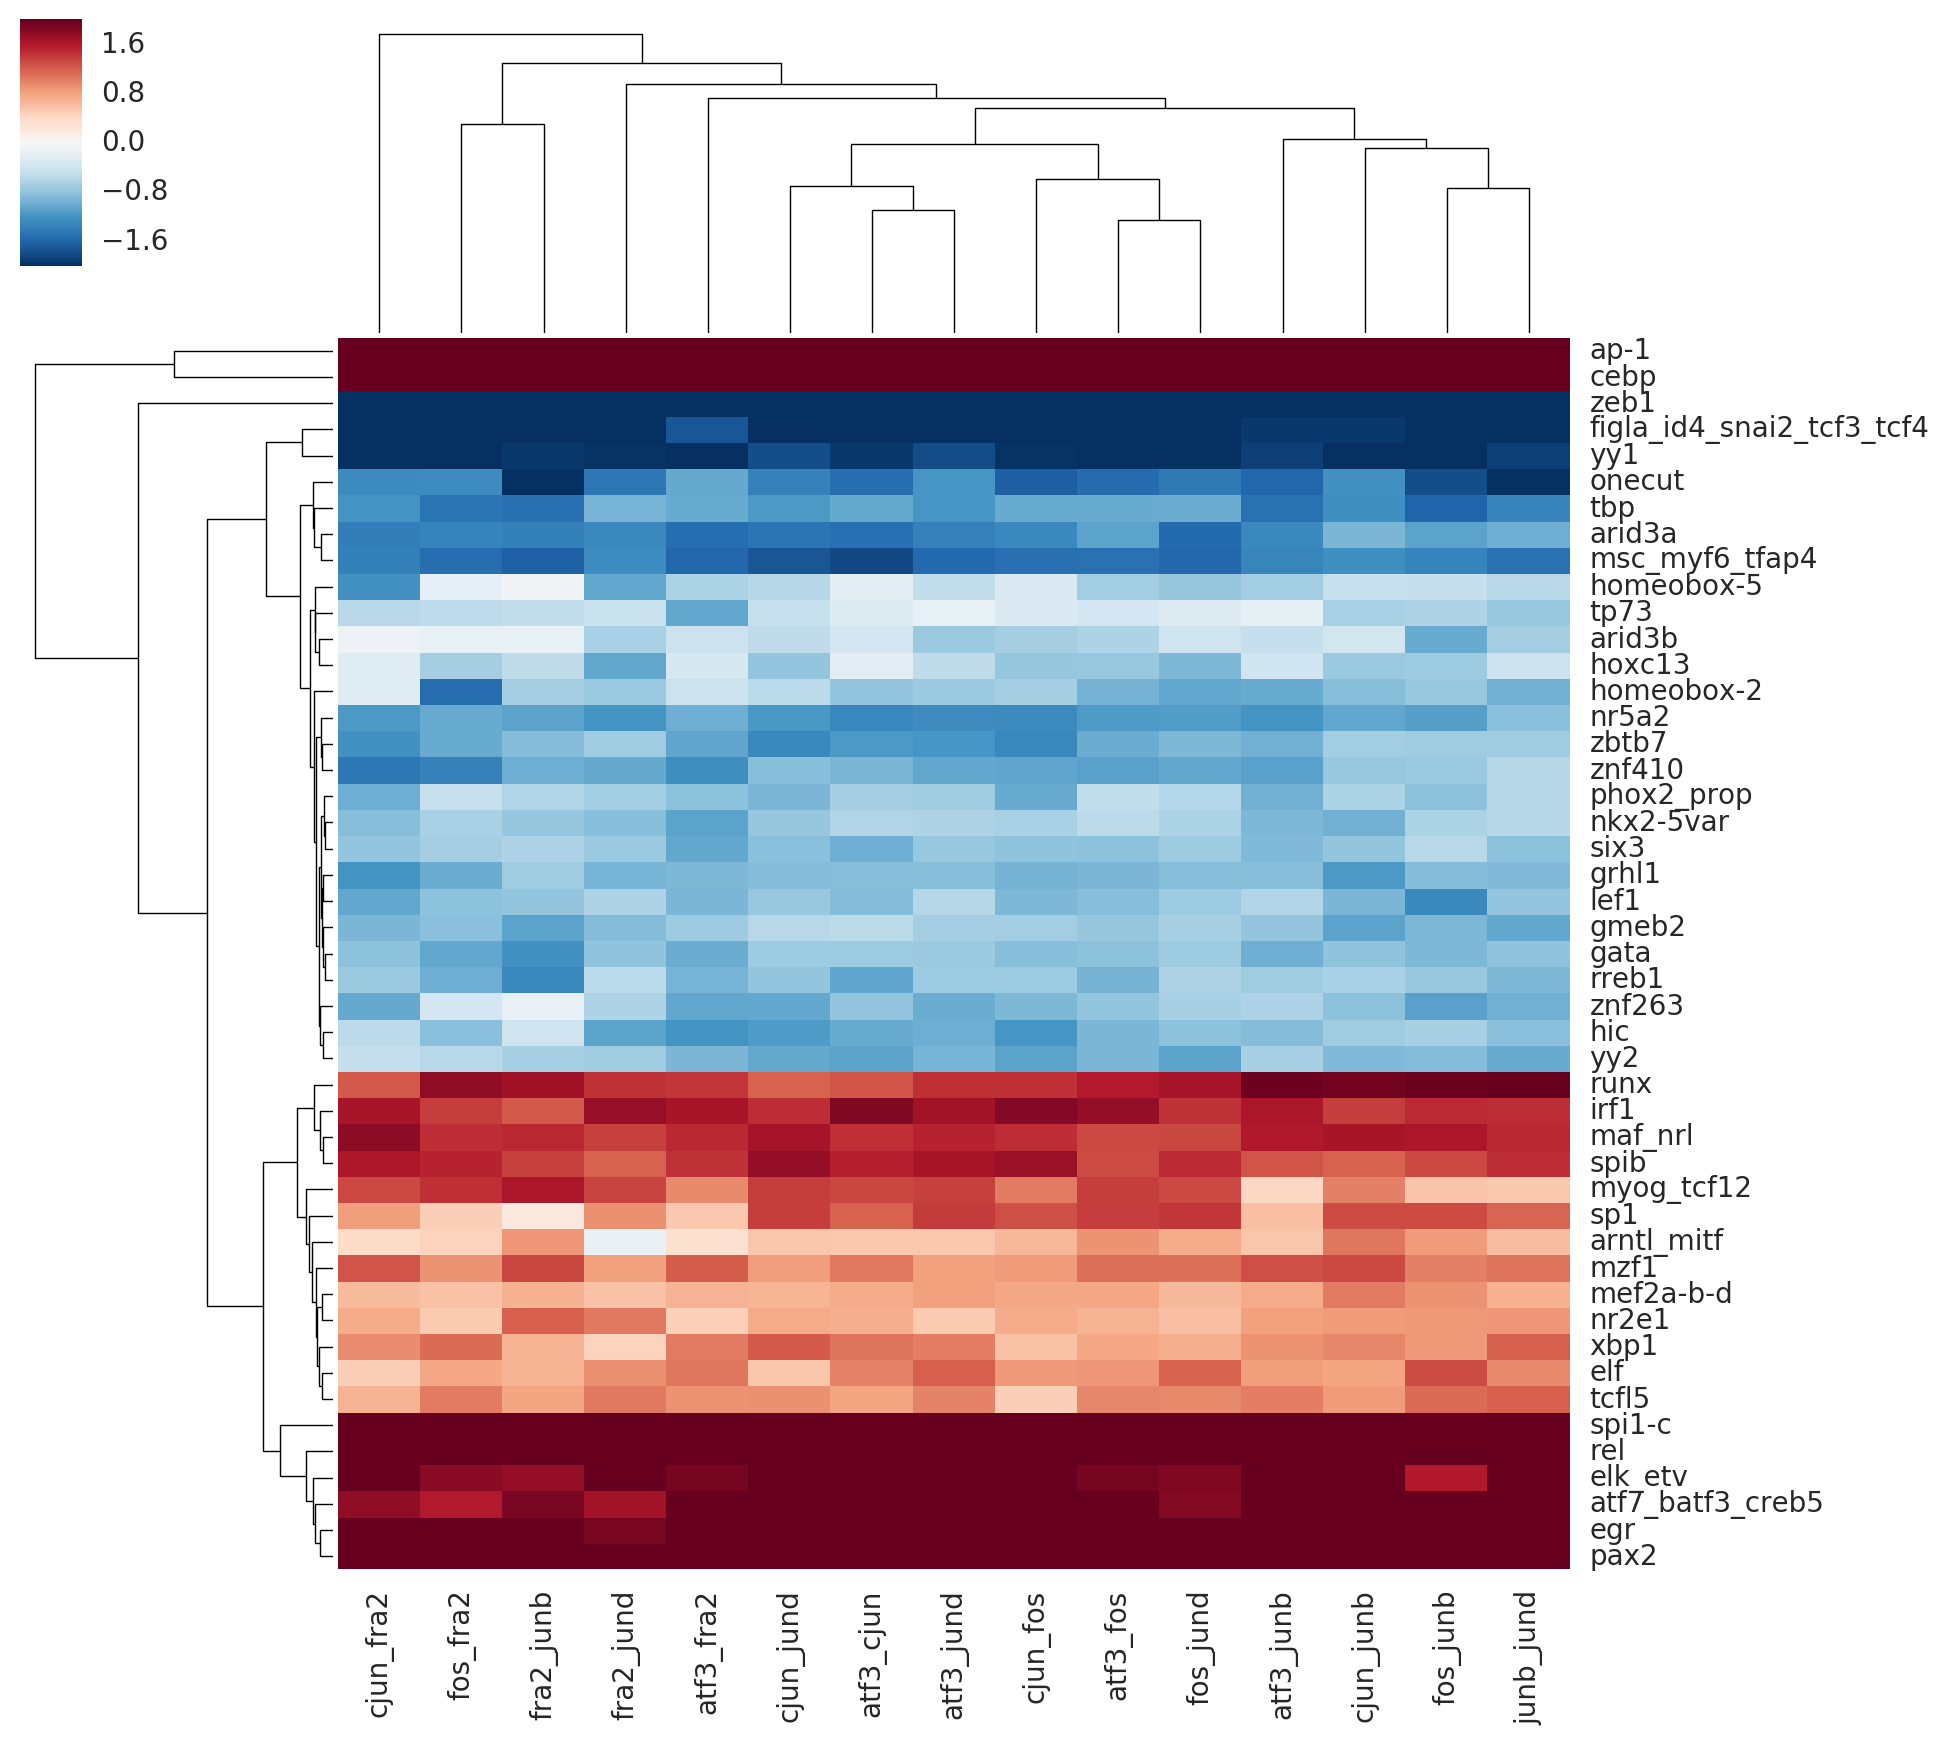

In [136]:
weight_threshold = 1.0
data = zscore_coeff_affinity_dimer_frame[
    (zscore_coeff_affinity_dimer_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_dimer_frame.min(axis=1) < -1* weight_threshold)
]
cg = sns.clustermap(data, 
                    vmin = -2*weight_threshold,
                    vmax = 2*weight_threshold,
                    yticklabels=True)

plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=0);



(0, 47)

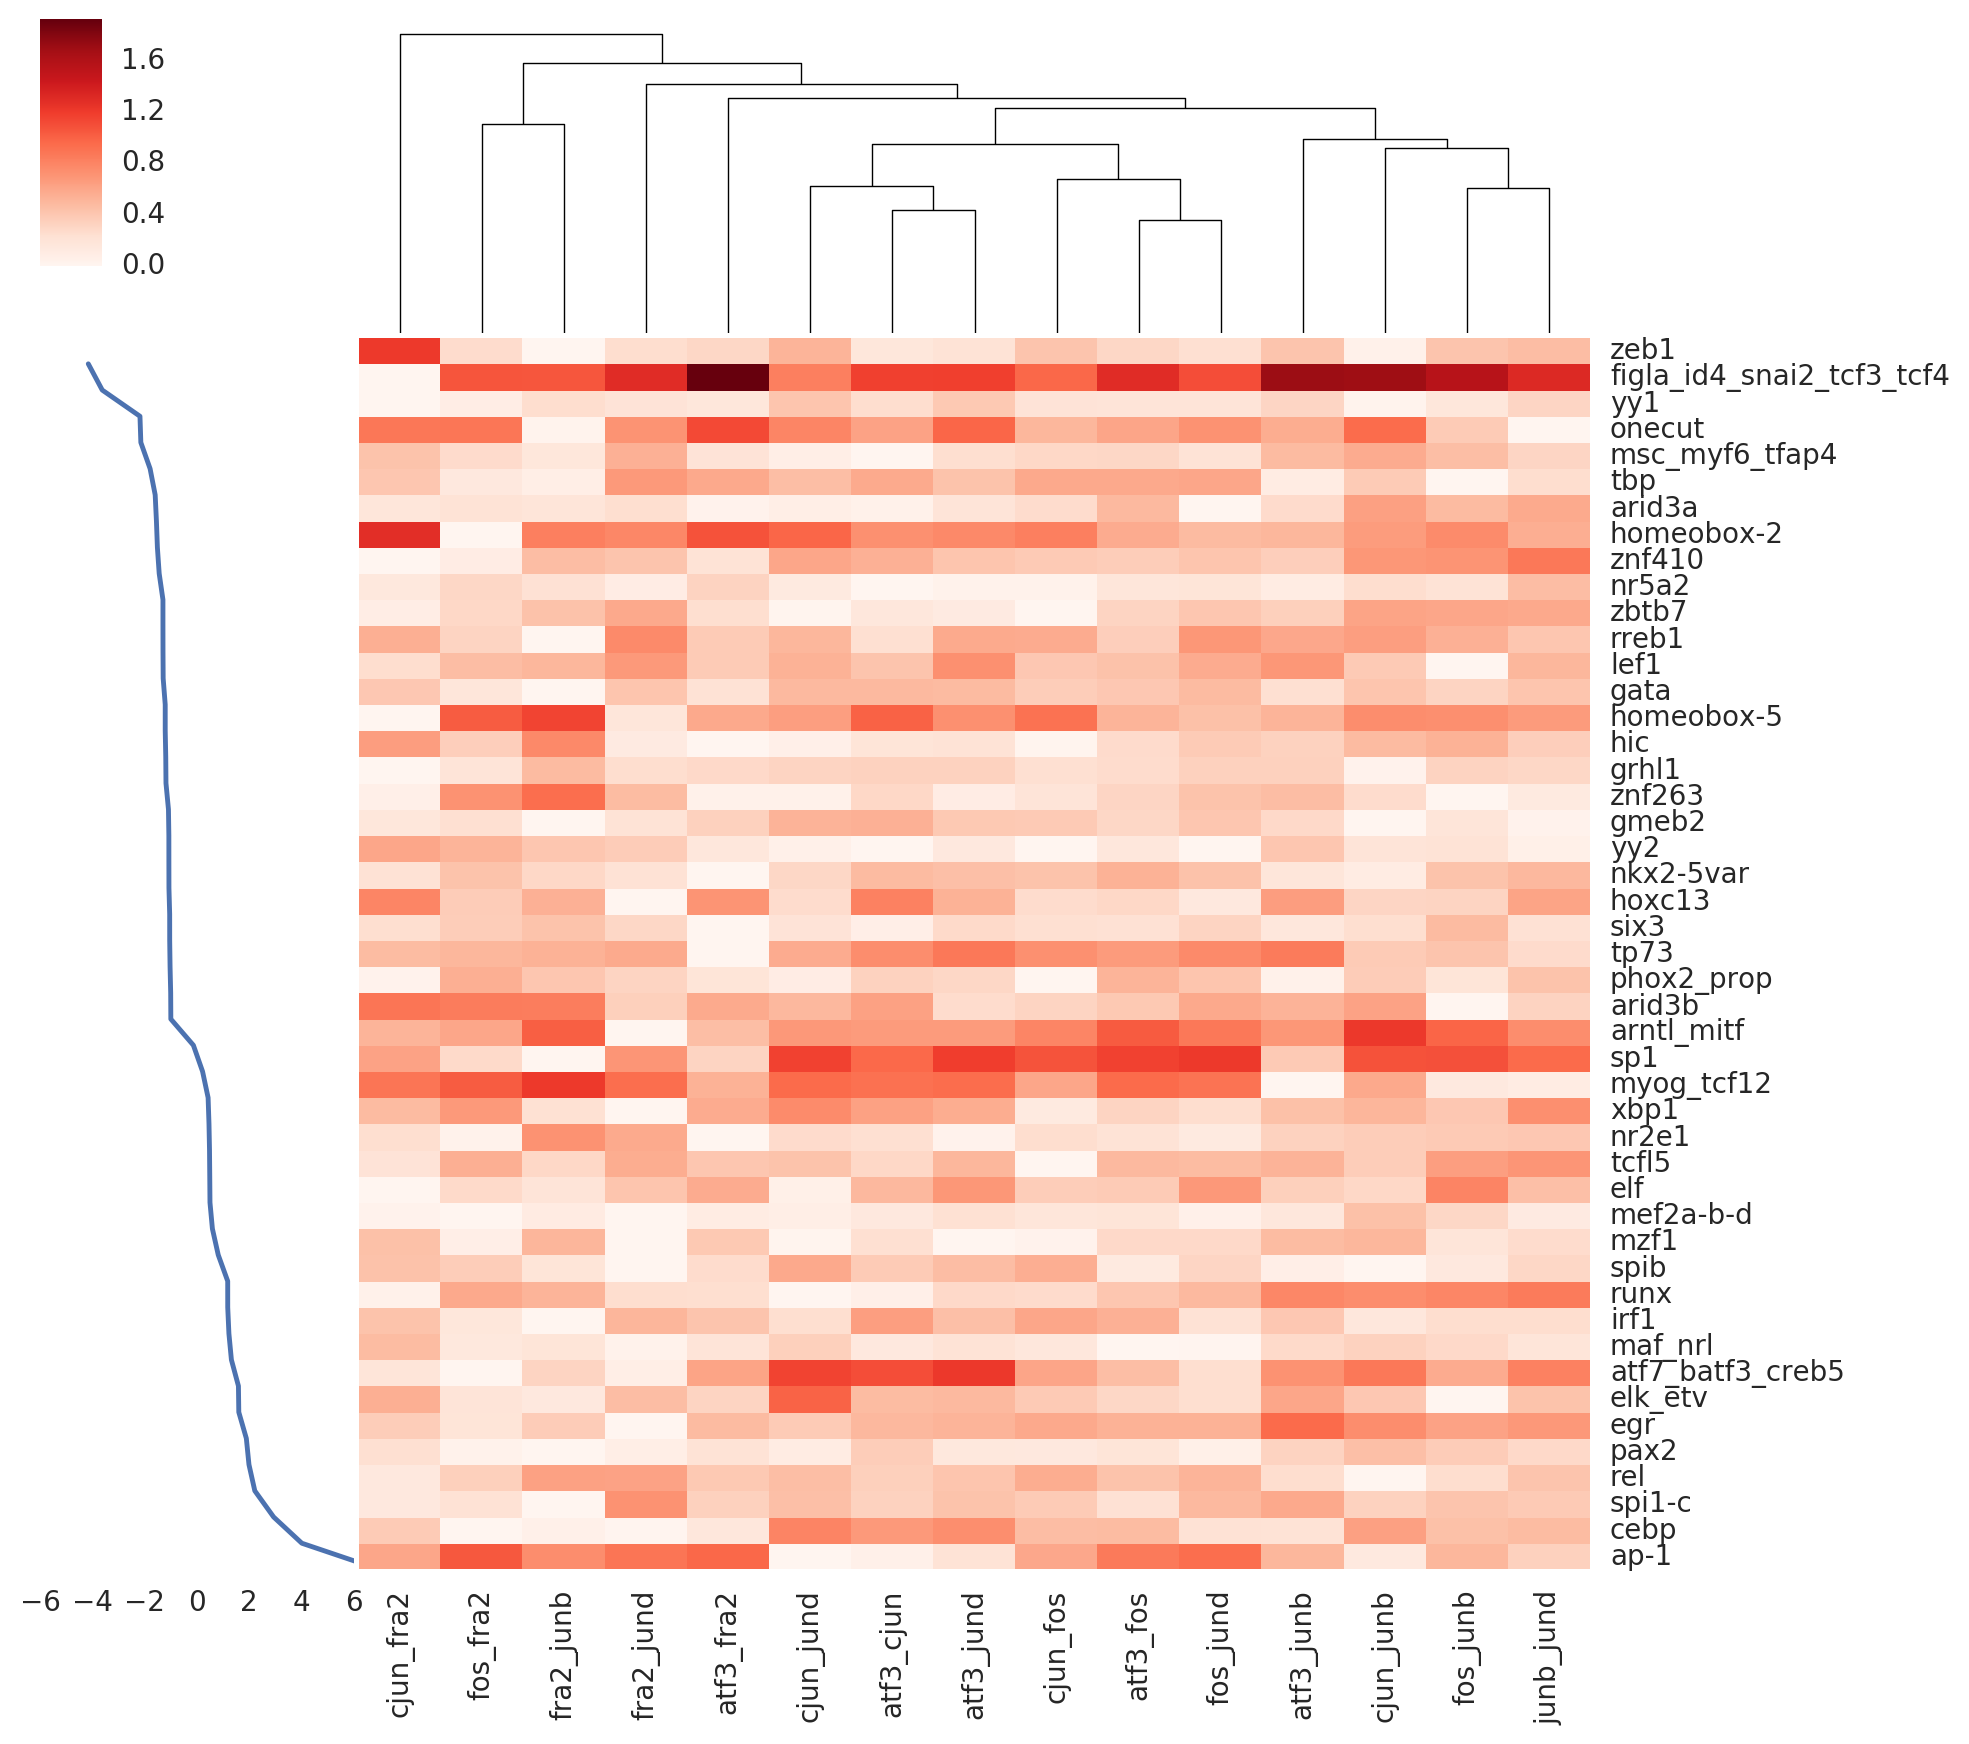

In [234]:
weight_threshold = 1.0
data = zscore_coeff_affinity_dimer_frame[
    (zscore_coeff_affinity_dimer_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_dimer_frame.min(axis=1) < -1* weight_threshold)
]
# data = zscore_coeff_combined_kla_frame[
#     (zscore_coeff_combined_kla_frame.max(axis=1) > 1* weight_threshold) |
#     (zscore_coeff_combined_kla_frame.min(axis=1) < -1* weight_threshold)
# ]
mins = data.min(axis=1)

differences = data[[]]
for col in data.columns:
    differences[col] = data[col].values - mins.values
mins.sort()
sorted_differences = differences.ix[mins.index.values,:]
cg = sns.clustermap(sorted_differences,
                    col_cluster=True,
                   row_cluster=False,
                   cmap='Reds')
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
cg.ax_row_dendrogram.clear()
cg.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
cg.ax_row_dendrogram.set_yticks([])
cg.ax_row_dendrogram.set_xlim(-6,6)
cg.ax_row_dendrogram.set_ylim(0,len(mins))





In [276]:
weight_threshold = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund'] 
for i in range(len(ap1_members) - 1):
    for j in range(i+1, len(ap1_members)):
        monomer1 = ap1_members[i]
        monomer2 = ap1_members[j]
        dimer = monomer1+'_'+monomer2
        combined_model_vals = zscore_coeff_affinity_dimer_frame[dimer]
        monomer1_model_vals = zscore_coeff_affinity_kla_frame[monomer1 + '_kla']
        monomer2_model_vals = zscore_coeff_affinity_kla_frame[monomer2 + '_kla']
        frame = pd.DataFrame({monomer1:monomer1_model_vals,
                              monomer2: monomer2_model_vals,
                              dimer:combined_model_vals},
                             index = zscore_coeff_affinity_dimer_frame.index.values)
        frame = frame[
                (frame.max(axis=1) > 1* weight_threshold) |
                (frame.min(axis=1) < -1* weight_threshold)
                ]
        frame.sort(dimer, inplace=True)

In [264]:
data = pd.concat([zscore_coeff_affinity_kla_frame, zscore_coeff_affinity_dimer_frame], axis=1)
model = sklearn.decomposition.PCA(n_components=2)
reduced_features = model.fit_transform(data.T)
explained_variance_ratios = model.explained_variance_ratio_

([], <a list of 0 Text yticklabel objects>)

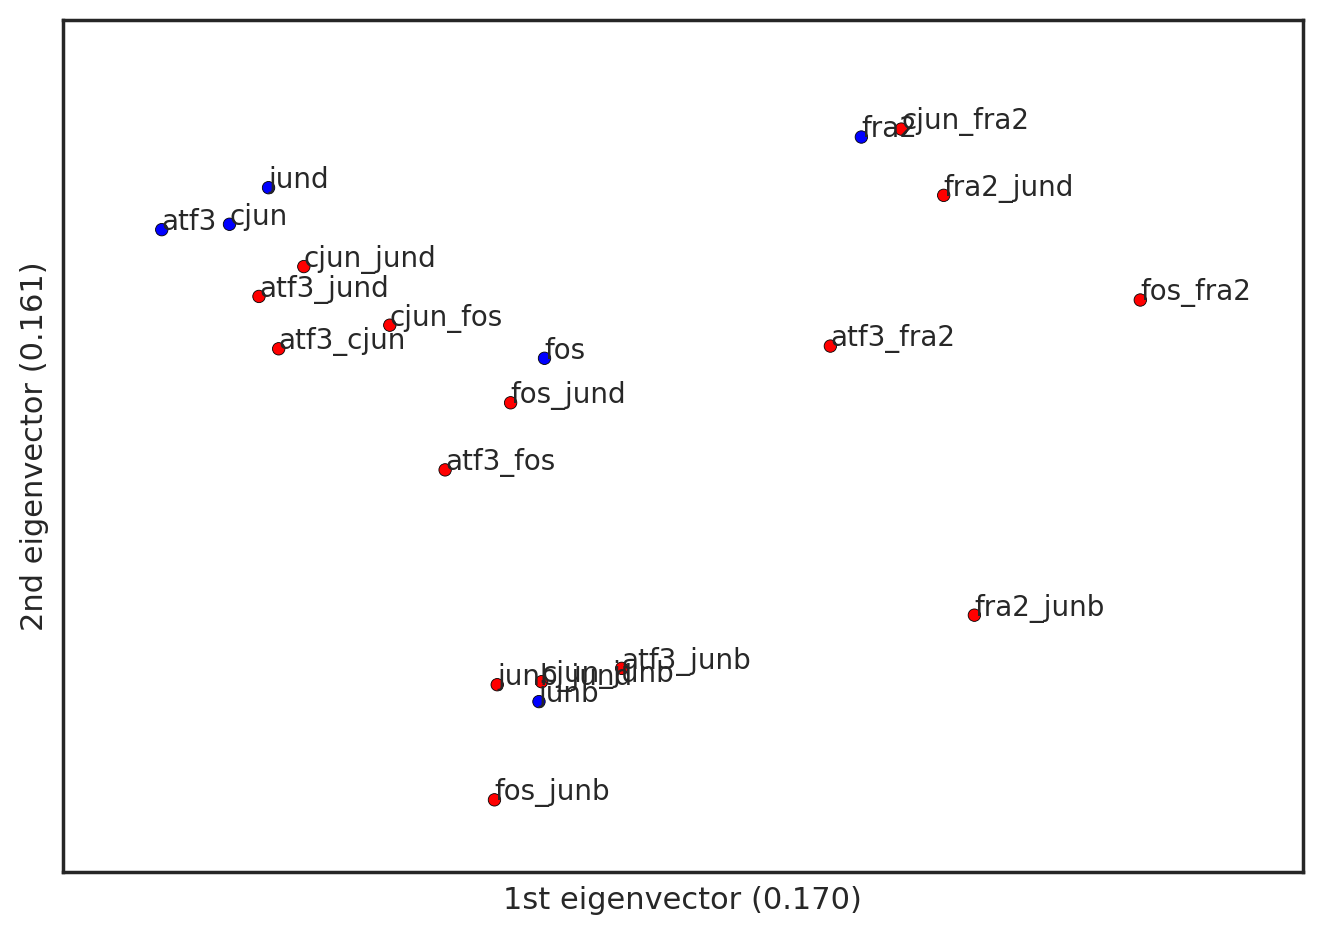

In [265]:
sns.set_style('white')
# f = plt.figure(figsize=(5,5))
labels = [x.replace('_kla','') for x in data.columns.values]
colors = ['red' if '_' in x else 'blue' for x in labels]
# 1st and 2nd principal component
x_vals = reduced_features[:, 0]
y_vals = reduced_features[:, 1]
plt.scatter(x_vals, y_vals, s=20, c=colors)

for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        plt.annotate(labels[i], xy=(x,y) , size=10)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])




# Figure 7 - Strains Based Confirmation

### Run Verena's scripts

In [478]:
# create motif file for use with MARGE
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'
threshold = 0.20 # threshold used for Homer
all_scores = []
outfile = open('all_threshold_'+str(threshold)+'.motif','w')

for mf in os.listdir(motif_dir):
    with open(motif_dir + '/' + mf) as f:
        data = f.readlines()
#     motif_name = data[8].strip().split()[-1]
    motif_name = mf.split('.')[0]
    max_score = 0
    for pwm_line in data[10:-1]:
        tokens = pwm_line.strip().split('\t')
        freqs = [float(x.strip()) for x in tokens]
        max_score += np.log2(np.max(freqs)/0.25)
    outfile.write('\t'.join(['>' + motif_name, motif_name , str(threshold*max_score), '\n']))
    for pwm_line in data[10:-1]:
        outfile.write(pwm_line.strip() + '\n')
    
    all_scores.append(max_score)
outfile.close()

In [87]:
# ! if [ ! -d ./marge_files ]; then mkdir ./marge_files; fi
! if [ ! -d ./marge_output ]; then mkdir ./marge_output; fi

In [88]:
# read in best samples for use with annotation
# for c57bl6 samples
with open ('/home/jtao/analysis/ap1_analysis/best_samples.tsv') as f:
    data = f.readlines()
condition_samples_dict = {}
for line in data:
    tokens = line.strip().split('\t')
    condition = '_'.join(tokens[:3])
    samples = tokens[3:-1]
    condition_samples_dict[condition] = samples
    
# for nod and balbc
with open ('/home/jtao/analysis/ap1_analysis/best_samples_strains.tsv') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split('\t')
    condition = '_'.join(tokens[:3])
    samples = tokens[3:-1]
    condition_samples_dict[condition] = samples

In [89]:
strain_fullStrain_dict ={'balbc':'BALBCJ','c57bl6':'C57BL6J', 'nod':'NODSHILTJ'}

In [90]:
!rm -rf ./marge_files/*

In [91]:
!rm -rf ./marge_output/*

In [99]:
c57bl6_path = '/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/'
strains_path = '/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/'
# create peak files for each dimer
### create peak files for denovo motif
peak_threshold = 50 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun', 'fos', 'fra2','junb', 'jund']
strains = ['balbc','c57bl6']
for strain in strains:
    for treatment in ['veh', 'kla']:
        for i in range(len(factors)):
            factor1 = strain + '_'+factors[i] + '_' + treatment

            if factor1 in summary_frame.columns:
                
                outputPath = './marge_files/' + strain + '_' + factors[i] +'_' +treatment+ '_peaks.tsv'

                current_frame = summary_frame[(summary_frame[factor1]> 0)]

                current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
                current_peak_frame['strand'] = '+'
                columns = current_peak_frame.columns.values
                columns[0]='#PeakID'
                current_peak_frame.columns = columns
                if not os.path.isfile(outputPath):
                    if current_peak_frame.shape[0]  > peak_threshold:
                        current_peak_frame.to_csv(outputPath,
                                                 index=False,
                                                 sep='\t')
# create merged peak files for each pair of strains
for treatment in ['veh', 'kla']:
    for i in range(len(factors)):
        factor1 = factors[i]
        print(factor1)
        for k in range(len(strains)-1):
            strain1 = strains[k]
            for l in range(k+1, len(strains)):
                strain2 = strains[l]
                strain1_path = './marge_files/' + '_'.join([strain1, factor1, treatment, 'peaks.tsv'])
                strain2_path = './marge_files/' + '_'.join([strain2, factor1, treatment, 'peaks.tsv'])

                if os.path.isfile(strain1_path) and os.path.isfile(strain2_path):
                    merged_file_path = './marge_files/' + '_'.join([strain1, strain2, factor1, treatment, 'mergedPeaks.tsv'])
                    if not os.path.isfile(merged_file_path):
                        print('mergePeaks -d given ' + strain1_path + ' ' + strain2_path + '>' + merged_file_path)
                        os.system('mergePeaks -d given ' + strain1_path + ' ' + strain2_path + '>' + merged_file_path)

                    # annotate merged peak files with best tag directories
                    strain1_samples = condition_samples_dict[strain1 + '_' + factor1 + '_'+treatment]
                    strain2_samples = condition_samples_dict[strain2 + '_' + factor1 + '_'+treatment]

                    strain1_samples = [c57bl6_path + x if 'C57' in x else strains_path + x for x in strain1_samples]
                    strain2_samples = [c57bl6_path + x if 'C57' in x else strains_path + x for x in strain2_samples]
                    annotated_file_path = merged_file_path.replace('merged','annotated')
                    if not os.path.isfile(annotated_file_path):
                        print('annotatePeaks.pl '+ merged_file_path + ' mm10 -noann -nogene -d ' + 
                              ' '.join(strain1_samples + strain2_samples) + '>' + annotated_file_path)
                        os.system('annotatePeaks.pl '+ merged_file_path + ' mm10 -noann -nogene -d ' + 
                              ' '.join(strain1_samples + strain2_samples) + '>' + annotated_file_path)
                    strain1_conditions = [strain1 + '_' + x.split('/')[-1].split('_')[3] for x in strain1_samples]
                    strain2_conditions = [strain2 + '_' + x.split('/')[-1].split('_')[3] for x in strain2_samples]


                    # average tag counts from tag directories
                    averaged_file_path = annotated_file_path.replace(strain1, 'avg_'+strain1)
                    if not os.path.isfile(averaged_file_path):
                        print('/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ' +
                                 annotated_file_path + ' ' + ' '.join(strain1_conditions + strain2_conditions))
                        os.system('/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ' +
                                 annotated_file_path + ' ' + ' '.join(strain1_conditions + strain2_conditions))

                    # call mutation analysis script
                    print('/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl '+
                          '-TF ' + './all_threshold_0.25.motif '
                          ' -genome mm10 -ind ' + strain_fullStrain_dict[strain1] + ', ' + strain_fullStrain_dict[strain2] +
                          ' -file ' + averaged_file_path + ' -output ./marge_output/' + '_'.join([strain1, strain2, factor1, treatment]) +
                          ' -plots ./marge_output/plot_' + '_'.join([strain1, strain2, factor1,  treatment])  + ' &')

#                     os.system('/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl '+
#                           '-TF ' + './all_threshold_0.25.motif '
#                           ' -genome mm10 -ind ' + strain_fullStrain_dict[strain1] + ', ' + strain_fullStrain_dict[strain2] +
#                           ' -file ' + averaged_file_path + ' -output ./marge_output/' + '_'.join([strain1, strain2, factor1, treatment]) +
#                           ' -plots ./marge_output/plot_' + '_'.join([strain1, strain2, factor1,  treatment]))

      



balbc_atf3_veh
balbc_cjun_veh
balbc_fos_veh
balbc_junb_veh
balbc_jund_veh
balbc_atf3_kla
balbc_cjun_kla
balbc_fos_kla
balbc_junb_kla
balbc_jund_kla
c57bl6_atf3_veh
c57bl6_cjun_veh
c57bl6_fos_veh
c57bl6_fra2_veh
c57bl6_junb_veh
c57bl6_jund_veh
c57bl6_atf3_kla
c57bl6_cjun_kla
c57bl6_fos_kla
c57bl6_fra2_kla
c57bl6_junb_kla
c57bl6_jund_kla


In [100]:
# combine marge results
if os.path.isfile('./matrix_summary_heatmap.R'):
    os.remove('./matrix_summary_heatmap.R')
marge_out_dir = './marge_output/'
file_list = [marge_out_dir+x for x in os.listdir(marge_out_dir) if '_with_motif.R' in x]

command = '/home/vlink/mouse_strains/marge/analysis/generate_heatmap.pl -files '
file_list_string = ', '.join(file_list)
command = command + file_list_string 

print(command)
os.system(command)

/home/vlink/mouse_strains/marge/analysis/generate_heatmap.pl -files ./marge_output/plot_balbc_c57bl6_fos_veh_with_motif.R, ./marge_output/plot_balbc_c57bl6_cjun_kla_with_motif.R, ./marge_output/plot_balbc_c57bl6_cjun_veh_with_motif.R, ./marge_output/plot_balbc_c57bl6_junb_kla_with_motif.R, ./marge_output/plot_balbc_c57bl6_atf3_veh_with_motif.R, ./marge_output/plot_balbc_c57bl6_jund_kla_with_motif.R, ./marge_output/plot_balbc_c57bl6_fos_kla_with_motif.R, ./marge_output/plot_balbc_c57bl6_atf3_kla_with_motif.R, ./marge_output/plot_balbc_c57bl6_jund_veh_with_motif.R


0

In [101]:
# read in MARGE results
margeOutput_frame = pd.read_csv('./matrix_summary_heatmap.R', sep='\t')

margeOutput_frame.index = margeOutput_frame['TF'].values
del margeOutput_frame['TF']

margeOutput_frame.columns = ['_'.join(x.split('/')[-1].split('_')[3:5]) for x in margeOutput_frame.columns.values]

margeOutput_veh_frame = margeOutput_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
margeOutput_kla_frame = margeOutput_frame[['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']]

In [111]:
margeOutput_frame.ix['nr2f1']

fos_veh     1.000000
cjun_kla    0.358790
cjun_veh    0.122427
junb_kla    1.000000
atf3_veh    1.000000
jund_kla    0.922729
fos_kla     0.302503
atf3_kla    1.000000
jund_veh    0.550638
Name: nr2f1, dtype: float64

In [107]:
weight_threshold = 0.7
data = zscore_coeff_affinity_veh_frame[
    (zscore_coeff_affinity_veh_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_veh_frame.min(axis=1) < -1* weight_threshold)
]
top_veh_motifs = data.index.values

In [108]:
top_veh_motifs

array(['ap-1', 'arid3a', 'arid3b', 'arntl_mitf', 'atf7_batf3_creb5',
       'bhlhe23', 'cebp', 'ctcf', 'dbp_hlf_tef', 'duxa', 'egr', 'elf',
       'elk_etv', 'ewsr1-fli1', 'figla_id4_snai2_tcf3_tcf4', 'gata', 'gcm',
       'grhl1', 'hic', 'hnf4g', 'homeobox-2', 'homeobox-5', 'hoxa9',
       'hoxc13', 'insm1', 'irf1', 'maf_nrl', 'mafg', 'mef2a-b-d',
       'msc_myf6_tfap4', 'myog_tcf12', 'nfyb', 'nkx2-5var', 'nr2e1',
       'nr2f1', 'nr5a2', 'onecut', 'pax2', 'pbx1', 'phox2_prop',
       'pou2-3-5', 'pou6f2', 'rreb1', 'runx', 'six3', 'sox5_sox9_sry',
       'sp1', 'sp4', 'spi1-c', 'spib', 'spz1', 'tbp', 'tcfl5', 'tead',
       'thap1', 'usf', 'xbp1', 'yy1', 'zbtb7', 'zeb1', 'znf263', 'znf410',
       'znf740'], dtype=object)

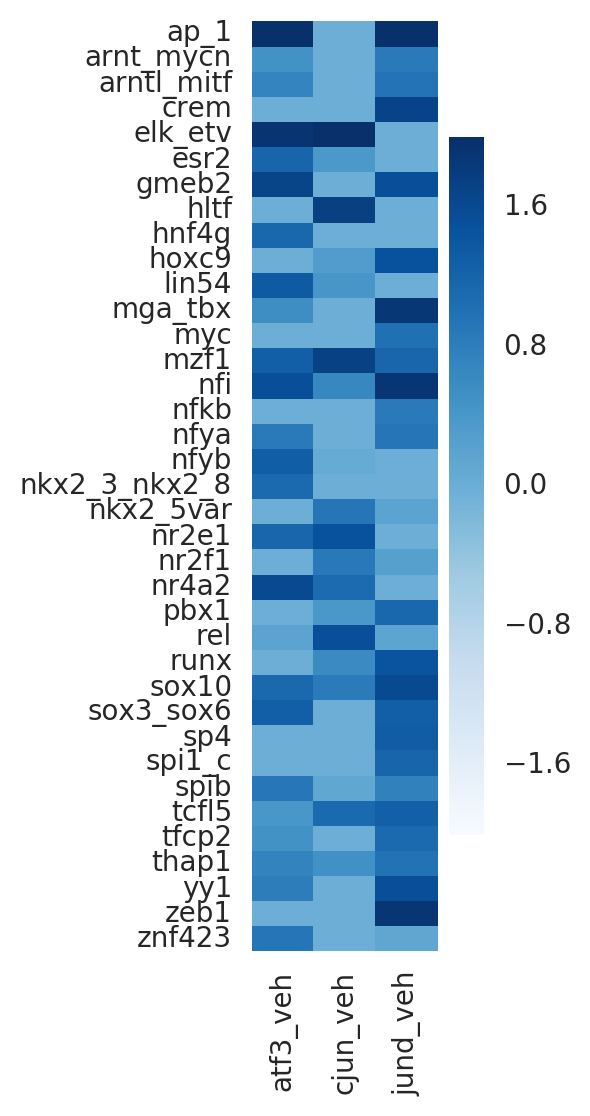

In [112]:
data = margeOutput_veh_frame[margeOutput_veh_frame.min(axis=1) < 0.13]
log_data = -1 * np.log10(data+0.01)
plt.figure(figsize=(1.5,6))
cg = sns.heatmap(log_data, cmap = 'Blues')
plt.setp(cg.yaxis.get_majorticklabels(), fontsize=10, rotation=0);


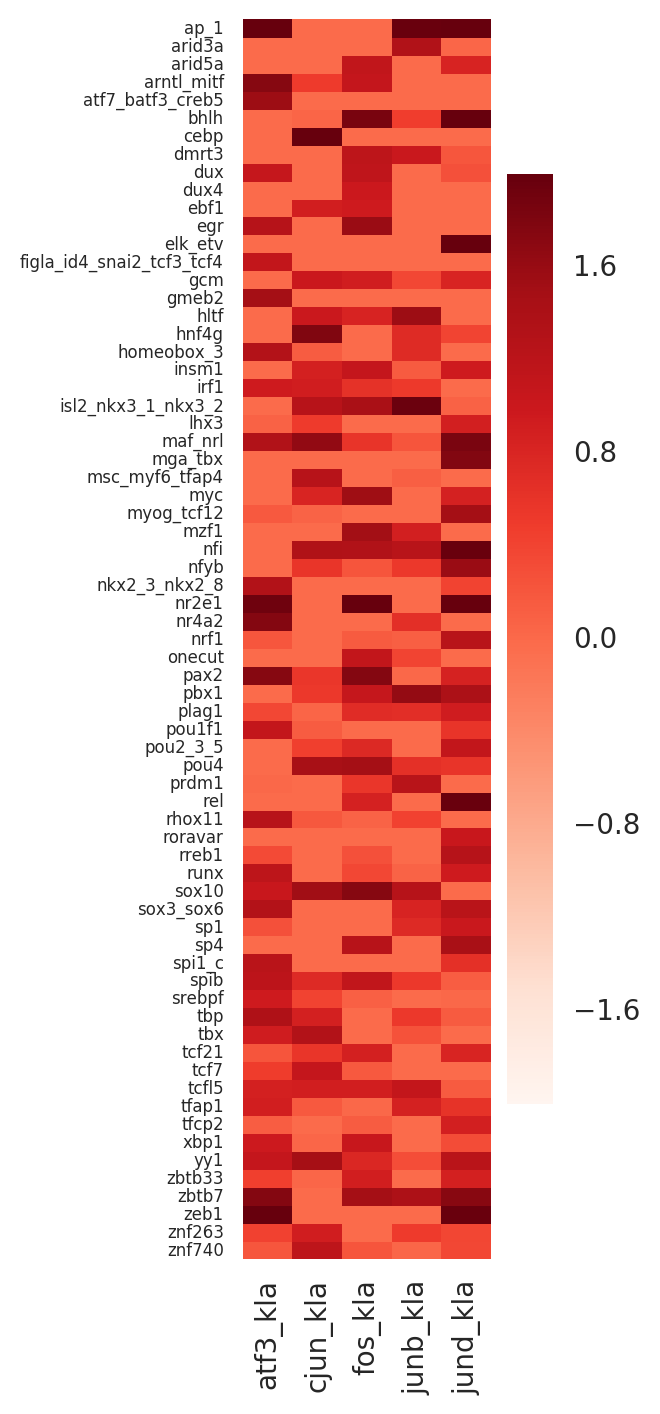

In [113]:
data = margeOutput_kla_frame[margeOutput_kla_frame.min(axis=1) < 0.12]
log_data = -1 * np.log10(data+0.01)
plt.figure(figsize=(2,8))
cg = sns.heatmap(log_data, cmap = 'Reds')
plt.setp(cg.yaxis.get_majorticklabels(), fontsize=6, rotation=0);



## Calculate DeltaSVM Style Scores

In [ ]:
!annotatePeaks.pl ./merged_peaks_filtered_resized.tsv mm10 -size given -d ./tag_directories_ap1/*/ ./tag_directories_strains/*/ > merged_strains_annotated_peaks_ap1.tsv

In [545]:
differences_frame = motif_score_frame.ix[:,3:] - motif_score_balb_frame.ix[:,3:]

In [563]:
results = calculate_mean_weights(factor_affinity_coeff_dict,
                          factor_countCoeff_dict,
                          factor_coeff_dict,
                          all_standardized_score_frame.columns.values)
mean_coeff_affinity_frame = results[0]
mean_coeff_count_frame = results[1]
mean_coeff_combined_frame= results[2]

mean_coeff_affinity_veh_frame = mean_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
mean_coeff_affinity_kla_frame = mean_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']]

mean_coeff_combined_veh_frame = mean_coeff_combined_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
mean_coeff_combined_kla_frame = mean_coeff_combined_frame[['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']]

In [593]:
veh_factor_treatments = ['atf3_veh', 'cjun_veh', 'jund_veh']
kla_factor_treatments = ['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']
strain1 = 'c57bl6'
strain2 = 'balbc'

selected_motifs = differences_frame.columns.values

for factor_treatment in veh_factor_treatments + kla_factor_treatments:
        strain1_indices = summary_frame[summary_frame[strain1+ '_' + factor_treatment] > 0].index.values
        strain2_indices = summary_frame[summary_frame[strain2+ '_' + factor_treatment] > 0].index.values
        factor_treatment_indices = sorted(set(strain1_indices).union(set(strain2_indices)))
        current_differences = differences_frame.ix[factor_treatment_indices,selected_motifs]
        current_weights = mean_coeff_affinity_frame[factor_treatment]
        
        products = current_weights * current_differences
        scores = products.sum(axis=1)

# Figure 7 - PPARg Venn Diagrams

In [430]:
!ls peak_files_validation/

c57bl6-ppargko_atf3_veh_peaks.tsv  c57bl6-ppargko_jund_veh_peaks.tsv
c57bl6-ppargko_cjun_veh_peaks.tsv  c57bl6_pparg_veh_peaks.tsv


In [432]:
%%capture
! mergePeaks -d given -venn validation_venn.txt ./peak_files/c57bl6_atf3_veh_peaks.tsv ./peak_files/c57bl6_cjun_veh_peaks.tsv ./peak_files/c57bl6_jund_veh_peaks.tsv ./peak_files_validation/* > merged_validation_peaks.tsv



In [433]:
! makeSummaryFile.py ./merged_validation_peaks.tsv ./group_validation_summary.tsv ./peak_files/c57bl6_atf3_veh_peaks.tsv ./peak_files/c57bl6_cjun_veh_peaks.tsv ./peak_files/c57bl6_jund_veh_peaks.tsv ./peak_files_validation/* 

Finished reading merged peak file...
Integrating scores for c57bl6_atf3_veh
Integrating scores for c57bl6_cjun_veh
Integrating scores for c57bl6_jund_veh
Integrating scores for c57bl6-ppargko_atf3_veh
Integrating scores for c57bl6-ppargko_cjun_veh
Integrating scores for c57bl6-ppargko_jund_veh
Integrating scores for c57bl6_pparg_veh


In [ ]:
%%capture
! mergePeaks -d given -venn venn.txt ./resized_peak_files/* > ./merged_peaks.tsv

! makeSummaryFile.py ./merged_peaks_filtered_resized.tsv ./group_summary.tsv ./resized_peak_files/*

In [646]:
# read in peak data data
summary_validation_frame = pd.read_csv('./group_validation_summary.tsv' , sep='\t')
summary_validation_frame = summary_validation_frame.fillna('0')
for col in summary_validation_frame.columns[5:]:
    floatValues = []
    for val in summary_validation_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_validation_frame[col] = floatValues
summary_validation_frame.index = summary_validation_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_validation_frame = summary_validation_frame[~summary_validation_frame['chr'].str.contains('random')]
summary_validation_frame = summary_validation_frame[~summary_validation_frame['chr'].str.contains('Un')]

In [682]:
summary_validation_frame.sort('c57bl6-ppargko_cjun_veh', ascending=False)[['chr', 'start', 'end', 'c57bl6-ppargko_cjun_veh']]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


chr      start        end  c57bl6-ppargko_cjun_veh
Merged-chr7-80830574-7     chr7   80830424   80830749                     60.0
Merged-chr17-48356022-7   chr17   48355885   48356144                     59.0
Merged-chr1-166788151-7    chr1  166788015  166788279                     58.0
Merged-chr1-87181027-7     chr1   87180882   87181191                     55.0
Merged-chr6-52825724-7     chr6   52825478   52825887                     55.0
Merged-chr15-81845829-7   chr15   81845696   81845960                     54.0
Merged-chr10-8870615-7    chr10    8870449    8870757                     53.0
Merged-chr1-125454691-7    chr1  125454536  125454822                     52.0
Merged-chr4-150076308-7    chr4  150076142  150076470                     51.0
Merged-chr2-167649487-7    chr2  167649355  167649658                     50.0
Merged-chr14-30593335-7   chr14   30593204   30593479                     50.0
Merged-chr16-25061851-7   chr16   25061734   25061964                     50.0
Merged-chr2-52955284-7     chr2   52955129   52955435                     50.0
Merged-chr10-117721631-7  chr10  117721499  117721779                     49.0
Merged-chr15-59759824-7   chr15   59759709   59759943                     49.0
Merged-chr9-99182336-7     chr9   99182118   99182533                     49.0
Merged-chr8-18619291-6     chr8   18619168   18619419                     49.0
Merged-chr2-119267093-7    chr2  119266955  119267226                     49.0
Merged-chr7-126941326-7    chr7  126941177  126941490                     49.0
Merged-chr8-117074767-7    chr8  117074648  117074897                     49.0
Merged-chr10-111127650-7  chr10  111127513  111127798                     48.0
Merged-chr10-127596848-7  chr10  127596685  127597071                     48.0
Merged-chr6-91713040-7     chr6   91712907   91713171                     48.0
Merged-chr3-95650736-7     chr3   95650590   95650910                     48.0
Merged-chr9-57233980-7     chr9   57233847   57234139                     48.0
Merged-chr4-88214077-7     chr4   88213904   88214283                     48.0
Merged-chr11-120353842-7  chr11  120353708  120353964                     48.0
Merged-chr15-59648576-7   chr15   59648458   59648696                     47.0
Merged-chr2-71644217-7     chr2   71644066   71644344                     47.0
Merged-chr1-135594168-6    chr1  135594010  135594360                     47.0
...                         ...        ...        ...                      ...
Merged-chr17-51139623-1   chr17   51139523   51139723                      0.0
Merged-chr17-56009173-1   chr17   56009073   56009273                      0.0
Merged-chr17-56175562-1   chr17   56175462   56175662                      0.0
Merged-chr17-56304482-1   chr17   56304382   56304582                      0.0
Merged-chr17-50530213-1   chr17   50530113   50530313                      0.0
Merged-chr6-34713408-1     chr6   34713308   34713508                      0.0
Merged-chr6-145341464-1    chr6  145341364  145341564                      0.0
Merged-chr9-96718567-1     chr9   96718467   96718667                      0.0
Merged-chr6-145762198-1    chr6  145762098  145762298                      0.0
Merged-chr6-146759215-1    chr6  146759115  146759315                      0.0
Merged-chr6-4054613-1      chr6    4054513    4054713                      0.0
Merged-chr6-5298445-1      chr6    5298345    5298545                      0.0
Merged-chr6-6578700-1      chr6    6578600    6578800                      0.0
Merged-chr17-48558082-1   chr17   48557982   48558182                      0.0
Merged-chr17-48632522-1   chr17   48632422   48632622                      0.0
Merged-chr17-48963917-1   chr17   48963817   48964017                      0.0
Merged-chr10-95323532-1   chr10   95323432   95323632                      0.0
Merged-chr10-95442446-1   chr10   95442346   95442546                      0.0
Merged-chr10-96150929-1   chr10   96150829   96151029                      0.0

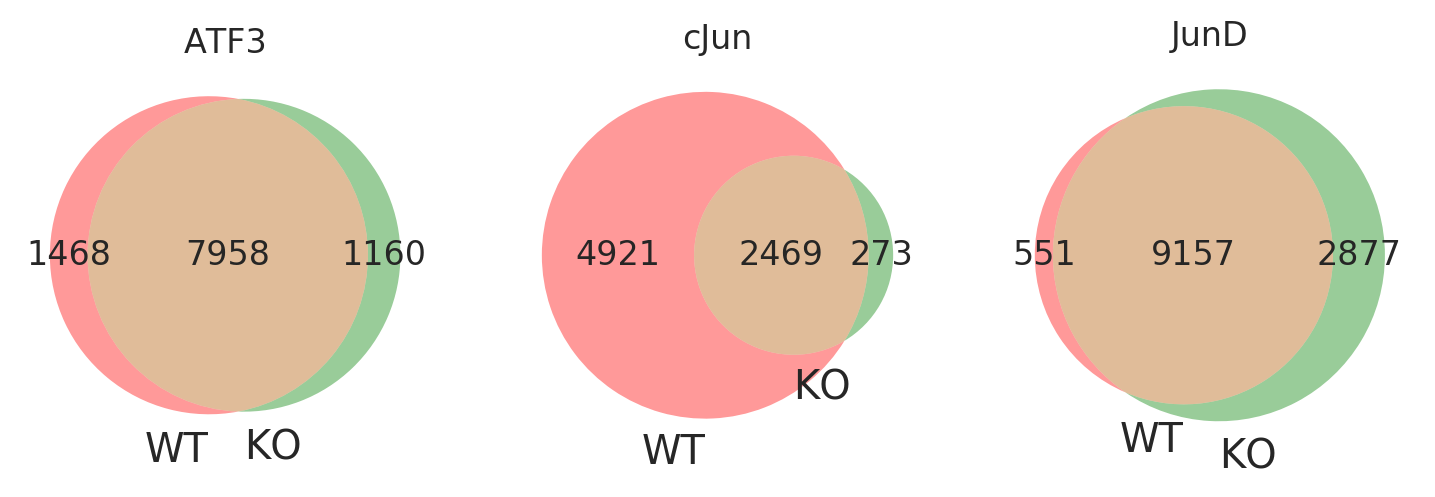

In [647]:
ppar_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_pparg_veh'] > 0].index.values)

atf3_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_atf3_veh'] > 0].index.values)
atf3_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0].index.values)

cjun_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_cjun_veh'] > 0].index.values)
cjun_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0].index.values)

jund_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_jund_veh'] > 0].index.values)
jund_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0].index.values)

fig, ax = plt.subplots(1,3, figsize=(9,3))
plt.subplot(1,3,1)
matplotlib_venn.venn2([ppar_indices.intersection(atf3_wt_indices),
                       ppar_indices.intersection(atf3_ko_indices)],
                      set_labels = ['WT', 'KO'])
plt.title('ATF3')

plt.subplot(1,3,2)
matplotlib_venn.venn2([ppar_indices.intersection(cjun_wt_indices),
                       ppar_indices.intersection(cjun_ko_indices)],
                     set_labels = ['WT', 'KO'])
plt.title('cJun')
plt.subplot(1,3,3)
matplotlib_venn.venn2([ppar_indices.intersection(jund_wt_indices),
                       ppar_indices.intersection(jund_ko_indices)],
                     set_labels = ['WT', 'KO'])
plt.title('JunD')

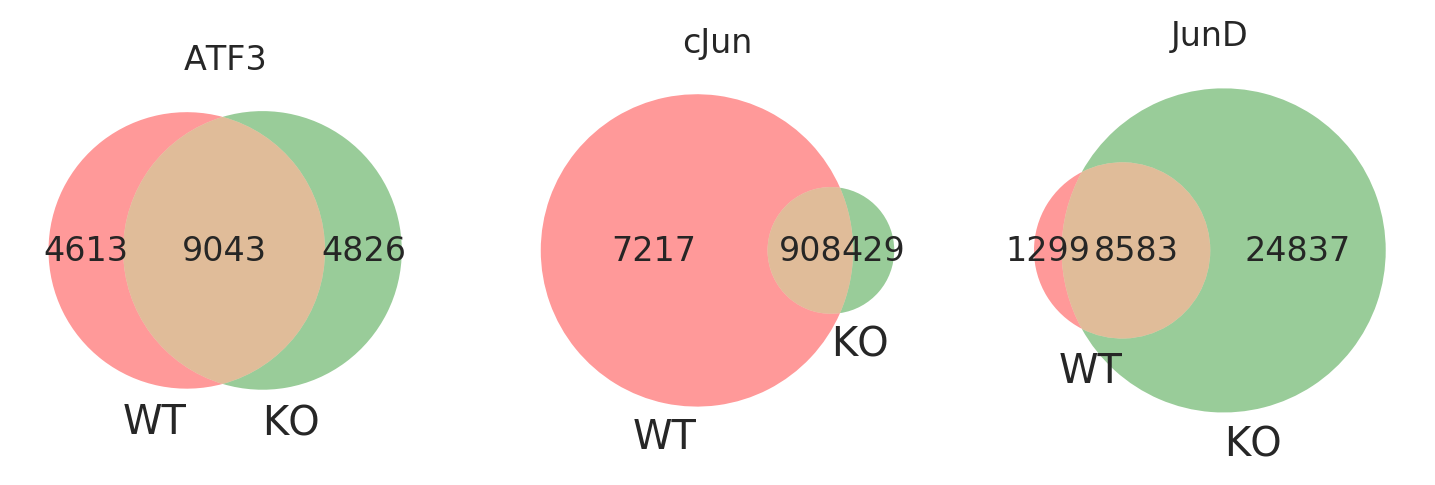

In [648]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
plt.subplot(1,3,1)
matplotlib_venn.venn2([atf3_wt_indices - ppar_indices,
                       atf3_ko_indices - ppar_indices],
                      set_labels = ['WT', 'KO'])
plt.title('ATF3')

plt.subplot(1,3,2)
matplotlib_venn.venn2([cjun_wt_indices - ppar_indices,
                       cjun_ko_indices - ppar_indices],
                     set_labels = ['WT', 'KO'])
plt.title('cJun')
plt.subplot(1,3,3)
matplotlib_venn.venn2([jund_wt_indices - ppar_indices,
                       jund_ko_indices - ppar_indices],
                     set_labels = ['WT', 'KO'])
plt.title('JunD')

In [39]:
! analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_*/ > rpkm_ppargko.tsv



	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_Thiomac_RNA_Veh_UT_TKS_15-04-06/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_Thiomac_RNA_Veh_UT_TKS_15-06-02/
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26/
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_Thiom

In [59]:
# read in rpkm values
rpkm_pparko_frame = pd.read_csv('./rpkm_ppargko.tsv', sep='\t')

rpkm_pparko_frame.index = [x.split('|')[0].upper() for x in rpkm_pparko_frame['Annotation/Divergence']]
rpkm_pparko_frame = rpkm_pparko_frame.ix[:,8:]
rpkm_pparko_frame.columns = [x.split('/')[-2].split('_')[0] for x in rpkm_pparko_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_pparko_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Genotype'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

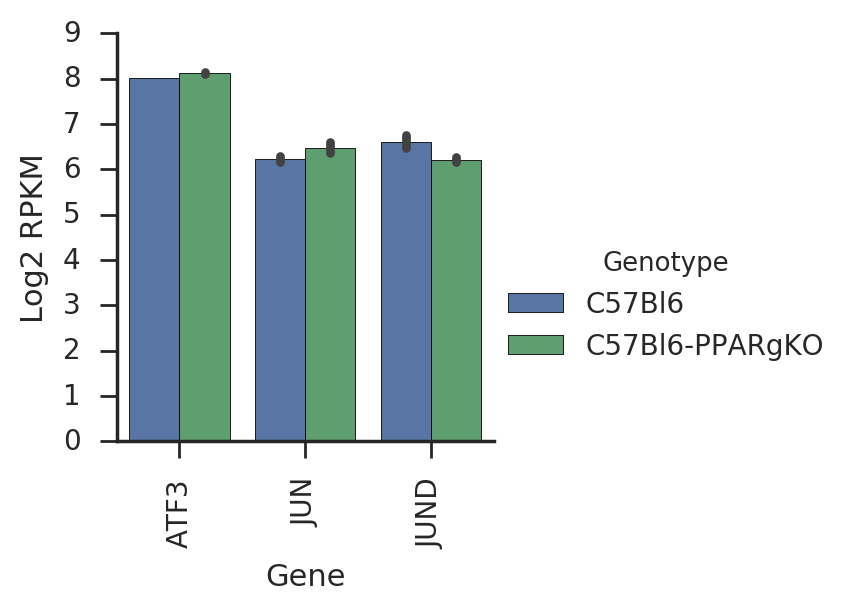

In [70]:
gene_list = ['ATF3', 'JUN' , 'JUND',
#              'PPARG',
#              'NR1H2',
#              'RXRA',
#              'RXRB',
#              'GCGR',
#              'ESR1'
             ]

plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Genotype', kind='bar', 
                   order = gene_list,
#                    hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=3)

plt.xticks(rotation=90)



(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

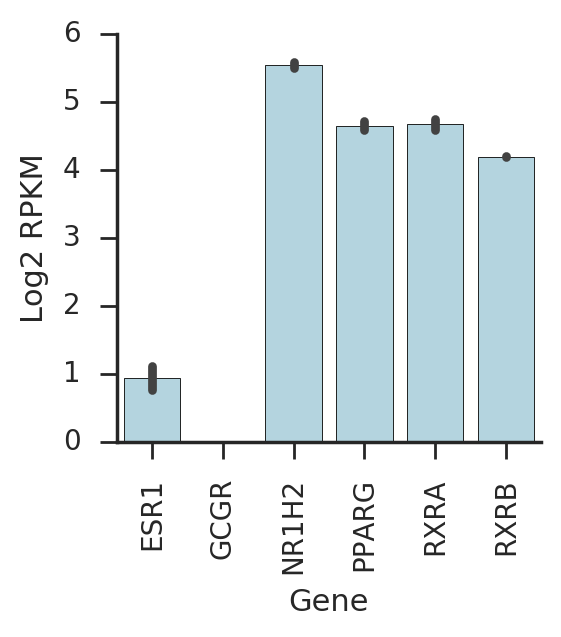

In [80]:
gene_list = ['PPARG',
             'NR1H2',
             'RXRA',
             'RXRB',
             'GCGR',
             'ESR1']

plottingFrame = rpkm_plotting_frame[(rpkm_plotting_frame['Gene'].isin(gene_list)) & 
                                    (rpkm_plotting_frame['Genotype'] == 'C57Bl6-PPARgKO')]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', kind='bar', 
                   order = sorted(gene_list),
#                    hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=3,
                  color='lightblue')

plt.xticks(rotation=90)



### Motif Weight Callout

In [237]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'
background_ratio = 1.0
for treatment in ['veh']:
    for monomer in ['atf3', 'cjun', 'jund']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
#         background_indices = motif_score_background_frame.index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

#         target_affinity_features = all_normed_score_frame[all_normed_score_frame.index.isin(target_indices)]
#         background_affinity_features = all_normed_score_frame[all_normed_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        count_features = all_standardized_count_frame
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_ensemble_classifier(affinity_features, 
                                            count_features, 
                                            labels,
                                            numIterations = 50,
                                            test_size = test_size,
                                            )
        
        # unpack result tuples
        all_rocs = results[0]
        all_affinity_rocs = results[1]
        all_count_rocs = results[2]
        all_precisions = results[3]
        all_affinity_precisions = results[4]
        all_count_precisions = results[5]
        all_coefficients = results[6]
        all_affinity_coefficients = results[7]
        all_count_coefficients = results[8]
        
        factor_roc_dict[monomer + '_' + treatment] = all_rocs
        factor_affinity_roc_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_count_roc_dict[monomer + '_' + treatment] = all_count_rocs
       
        factor_precision_dict[monomer + '_' + treatment] = all_precisions
        factor_affinity_precision_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_count_precision_dict[monomer + '_' + treatment] = all_count_precisions
    
        factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
        factor_affinity_coeff_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_countCoeff_dict[monomer + '_' + treatment] = all_count_coefficients
        
        
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_rocs), np.mean(all_affinity_rocs), np.mean(all_count_rocs),
              'precision:', np.mean(all_precisions), np.mean(all_affinity_precisions), np.mean(all_count_precisions)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


23136 46272
atf3_veh roc: 0.95109317564 0.942200879453 0.883523751223 precision: 0.948192664386 0.938473528635 0.879128932784
15538 31076
cjun_veh roc: 0.949159313808 0.941310276306 0.879318761634 precision: 0.9474471445 0.938819711675 0.876547952575
19624 39248
jund_veh roc: 0.95161616187 0.944220524727 0.879240190614 precision: 0.949245986442 0.940715765226 0.877013018739


In [238]:
results = calculate_zscore_weights(factor_affinity_coeff_dict,
                          factor_countCoeff_dict,
                          factor_coeff_dict,
                          all_standardized_score_frame.columns.values)
zscore_coeff_affinity_frame = results[0]
zscore_coeff_count_frame = results[1]
zscore_coeff_combined_frame= results[2]

zscore_coeff_affinity_veh_frame = zscore_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
zscore_coeff_affinity_kla_frame = zscore_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']]

zscore_coeff_combined_veh_frame = zscore_coeff_combined_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
zscore_coeff_combined_kla_frame = zscore_coeff_combined_frame[['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']]



In [239]:
zscore_coeff_affinity_veh_frame.ix['nr2f1']

atf3_veh    0.330809
cjun_veh    0.773335
jund_veh    0.503023
Name: nr2f1, dtype: float64

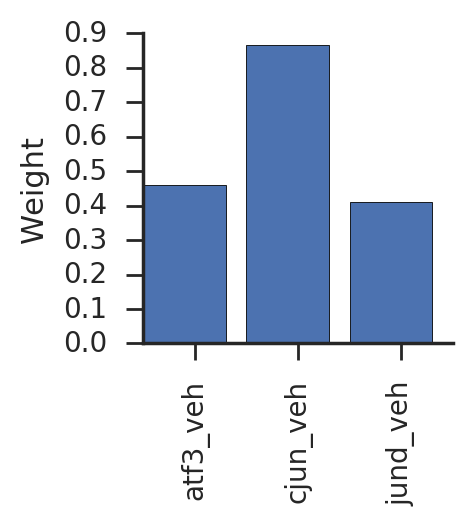

In [261]:
plt.figure(figsize=(2,2))
with sns.axes_style('ticks'):
    plt.bar(range(3),zscore_coeff_affinity_veh_frame.ix['nr2f1'].values)
    sns.despine()
    plt.xticks(np.arange(0.5,3.5,1), ['atf3_veh', 'cjun_veh', 'jund_veh'], rotation=90)
    plt.ylabel('Weight')

### GRO-seq fold change plot for AP-1 dimers

In [ ]:
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    


for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [ ]:
# get peak IDS for peaks

reads = []
factors = []
treatments = []
fold_changes = []
for treatment in ['Veh','KLA', 'Both']:
    for fp in factorPairs:
        factor_auc_dict = {}
        factor1 = fp[0] + '_' + treatment.lower()
        factor2 = fp[1] + '_' + treatment.lower()
        
        if treatment == 'Veh':
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('veh','kla')] == 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('veh','kla')] == 0)].index.values)
        elif treatment == 'KLA':
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('kla','veh')] == 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('kla','veh')] == 0)].index.values)


        else:
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1.replace('both','veh')] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('both','kla')] > 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2.replace('both','veh')] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('both','kla')] > 0)].index.values)

            
        indices = indices1.intersection(indices2)
        if not treatment == 'Both':
            gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
                [['Gro_'+ treatment +' +', 'Gro_'+treatment+ ' -']].sum(axis=1)
        else:
            gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
                [['Gro_Veh +', 'Gro_Veh -', 'Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        veh_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
            [['Gro_Veh +', 'Gro_Veh -']].sum(axis=1)
        kla_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
            [['Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        
        factors = factors + [' '.join(fp).replace('c57bl6_','')] * len(gro_reads)
        treatments = treatments + [treatment] * len(gro_reads)
        reads = reads + list(gro_reads)
        fold_changes = fold_changes + list((kla_reads + 0.1)/(veh_reads + 0.1))




In [ ]:
# # get peak IDS for peaks

# reads = []
# factors = []
# treatments = []
# fold_changes = []
# for treatment in ['Veh','KLA', 'Both']:
#     for monomer in ap1_members:       
#         if treatment == 'Veh':
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_veh'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_kla'] == 0)].index.values)
#         elif treatment == 'KLA':
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_kla'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_veh'] == 0)].index.values)

#         else:
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_veh'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_kla'] > 0)].index.values)
#         if not treatment == 'Both':
#             gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#                 [['Gro_'+ treatment +' +', 'Gro_'+treatment+ ' -']].sum(axis=1)
#         else:
#             gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#                 [['Gro_Veh +', 'Gro_Veh -', 'Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
#         veh_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#             [['Gro_Veh +', 'Gro_Veh -']].sum(axis=1)
#         kla_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#             [['Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        
#         factors = factors + [monomer] * len(gro_reads)
#         treatments = treatments + [treatment] * len(gro_reads)
#         reads = reads + list(gro_reads)
#         fold_changes = fold_changes + list((kla_reads + 0.01)/(veh_reads + 0.01))





In [ ]:
gro_frame = pd.DataFrame({'Dimer':factors,
                          'Treatment':treatments,
                          'GRO-seq Tags':reads,
                          'Log2 GRO-seq Tags': np.log2(np.array(reads)+1),
                          'Fold Change':fold_changes,
                          'Log2 Fold Change': np.log2(np.array(fold_changes))
                          })

gro_frame['Treatment'] = ['Lost After Treatment' if x == 'Veh' else 'Unchanged' if x=='Both' else 'Gained After Treatment' for x in gro_frame['Treatment'].values]

In [ ]:
with sns.axes_style('ticks'):
    sns.factorplot( data = gro_frame,
                x='Dimer',
                y= 'Log2 Fold Change',
                hue='Treatment',
                size=4,
                ci=100)
    plt.xticks(rotation=90)
    plt.savefig('./figures/figure_08_e.pdf',bbox_inches='tight')

In [484]:
negative_sequence_dict = {x:_id_sequence_dict[x] for x in negative_features.index.values}

pickle.dump(positive_sequence_dict, open('/gpfs/data01/glasslab/home/jtao/analysis/tensorflow_analysis/positive_sequences.pickle', 'wb'))

pickle.dump(negative_sequence_dict, open('/gpfs/data01/glasslab/home/jtao/analysis/tensorflow_analysis/negative_sequences.pickle', 'wb'))

negative_sequence_dict = pickle.load(open('/gpfs/data01/glasslab/home/jtao/analysis/tensorflow_analysis/negative_sequences.pickle', 'rb'))

summary_background_frame = pd.read_csv('./backgrou')

## Ensemble Classifier

In [439]:
# def train_ensemble_classifier(affinity_features,
#                               count_features, 
#                               labels,
#                               numIterations = 5,
#                               test_size = 0.5,
#                              ):
#     '''
    
#     '''
#     all_rocs = []
#     all_affinity_rocs = []
#     all_count_rocs = []

#     all_precisions = []
#     all_affinity_precisions = []
#     all_count_precisions = []
    
#     all_coefficients = []
#     all_affinity_coefficients = []
#     all_count_coefficients = []

#     for i in range(numIterations):  

#         # split data into training and test sets
#         training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
#             affinity_features, labels, test_size = test_size)
#         training_count_features = count_features[count_features.index.isin(training_affinity_features.index.values)]
#         test_count_features = count_features[count_features.index.isin(test_affinity_features.index.values)]
#         #  Train affinity classifier
#         affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1, tol=1e-8)
#         affinity_classifier.fit(training_affinity_features, training_labels)

#         # Train count classifier
#         count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1, tol=1e-8)
#         count_classifier.fit(training_count_features, training_labels)

#         # train combined classifier
#         training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
#         training_count_scores = count_classifier.decision_function(training_count_features)
#         training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
#                                          'Count':training_count_scores})
#         combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1, tol=1e-8)
#         combined_classifier.fit(training_combined_features, training_labels)

#         # retrieve test probabilities
#         test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
#         test_count_scores = count_classifier.decision_function(test_count_features)
#         test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
#                                                    'Count':test_count_scores})

#         # score predictions
#         affinity_probas = affinity_classifier.predict_proba(test_affinity_features)
#         current_affinity_rocs = sklearn.metrics.roc_auc_score(test_labels, affinity_probas[:, 1], average = None)
#         current_affinity_precision = sklearn.metrics.average_precision_score(test_labels, affinity_probas[:, 1], average = None)
        
#         count_probas = count_classifier.predict_proba(test_count_features)
#         current_count_rocs = sklearn.metrics.roc_auc_score(test_labels, count_probas[:, 1], average = None)
#         current_count_precision = sklearn.metrics.average_precision_score(test_labels, count_probas[:, 1], average = None)
    
#         probas = combined_classifier.predict_proba(test_combined_features)
#         current_rocs = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
#         current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

#          # retrieve coefficients
#         current_coefficients = combined_classifier.coef_.flatten()
#         current_affinity_coefficients = affinity_classifier.coef_.flatten()
#         current_count_coefficients = count_classifier.coef_.flatten()
        
#         all_rocs.append(current_rocs)
#         all_affinity_rocs.append(current_affinity_rocs)
#         all_count_rocs.append(current_count_rocs)

#         all_precisions.append(current_precision)
#         all_affinity_precisions.append(current_affinity_precision)
#         all_count_precisions.append(current_count_precision)

#         all_coefficients.append(current_coefficients)
#         all_affinity_coefficients.append(current_affinity_coefficients)
#         all_count_coefficients.append(current_count_coefficients)  
        
#     results = (all_rocs, 
#                all_affinity_rocs, 
#                all_count_rocs, 
#                all_precisions, 
#                all_affinity_precisions, 
#                all_count_precisions,
#                all_coefficients,
#                all_affinity_coefficients,
#                all_count_coefficients)
#     return results




In [440]:
# def calculate_mean_weights(affinity_weights_dict, 
#                     count_weights_dict,
#                     ensemble_weights_dict,
#                     sorted_motif_names):
#     '''
#     takes the output weights of train_ensemble_classifier and calculates a combined weight for each motif
#     ensemble_weights[0] = affinity_classifier_weight
#     ensemble_weights[1] = count_classifier_weight
#     combined weight = affinity_classifier_weight * affinity_weight + count_classifier_weight * count_weight
#     returns zscore normalized affinity_weights_dict, count_weights_dict, and combined weights in data frame form
#     '''
    
#     factor_coeff_affinity_dict = {}
#     factor_coeff_count_dict = {}
#     factor_coeff_combined_dict = {}

#     # calculates the mean of each of the weights
#     for factor_treatment in affinity_weights_dict.keys():
#         current_affinity_weights = affinity_weights_dict[factor_treatment]
#         mean_affinity_weights = np.mean(current_affinity_weights, axis=0)
        
#         current_count_weights = count_weights_dict[factor_treatment]
#         mean_count_weights = np.mean(current_count_weights, axis=0)
        
#         current_ensemble_weights = ensemble_weights_dict[factor_treatment]
#         mean_ensemble_weights = np.mean(current_ensemble_weights, axis=0)
        
#         # combine weights
#         affinity_classifier_weight = mean_ensemble_weights[0] 
#         count_classifier_weight = mean_ensemble_weights[1] 
#         combined_weights = (affinity_classifier_weight * mean_affinity_weights) + (count_classifier_weight * mean_count_weights)
        
#         factor_coeff_affinity_dict[factor_treatment] = mean_affinity_weights
#         factor_coeff_count_dict[factor_treatment] = mean_count_weights
#         factor_coeff_combined_dict[factor_treatment] = combined_weights
    
#     coeff_affinity_frame = pd.DataFrame(factor_coeff_affinity_dict)
#     coeff_count_frame = pd.DataFrame(factor_coeff_count_dict)
#     coeff_combined_frame = pd.DataFrame(factor_coeff_combined_dict)
    
#     coeff_affinity_frame.index = sorted_motif_names
#     coeff_count_frame.index = sorted_motif_names
#     coeff_combined_frame.index = sorted_motif_names
    
#     return coeff_affinity_frame, coeff_count_frame, coeff_combined_frame

In [441]:
# def calculate_zscore_weights(affinity_weights_dict, 
#                     count_weights_dict,
#                     ensemble_weights_dict,
#                     sorted_motif_names):
#     '''
#     takes the output weights of train_ensemble_classifier and calculates a combined weight for each motif
#     ensemble_weights[0] = affinity_classifier_weight
#     ensemble_weights[1] = count_classifier_weight
#     combined weight = affinity_classifier_weight * affinity_weight + count_classifier_weight * count_weight
#     returns zscore normalized affinity_weights_dict, count_weights_dict, and combined weights in data frame form
#     '''
    
#     factor_zscore_coeff_affinity_dict = {}
#     factor_zscore_coeff_count_dict = {}
#     factor_zscore_coeff_combined_dict = {}

#     # calculates the mean of each of the weights
#     for factor_treatment in affinity_weights_dict.keys():
#         current_affinity_weights = affinity_weights_dict[factor_treatment]
#         mean_affinity_weights = np.mean(current_affinity_weights, axis=0)
        
#         current_count_weights = count_weights_dict[factor_treatment]
#         mean_count_weights = np.mean(current_count_weights, axis=0)
        
#         current_ensemble_weights = ensemble_weights_dict[factor_treatment]
#         mean_ensemble_weights = np.mean(current_ensemble_weights, axis=0)
        
#         # zscore normalize the weights
#         zscore_affinity_weights = scipy.stats.zscore(mean_affinity_weights)
#         zscore_count_weights = scipy.stats.zscore(mean_count_weights)
        
#         # combine weights
#         affinity_classifier_weight = mean_ensemble_weights[0] 
#         count_classifier_weight = mean_ensemble_weights[1] 
#         combined_weights = (affinity_classifier_weight * zscore_affinity_weights) + (count_classifier_weight * zscore_count_weights)
#         zscore_combined_weights = scipy.stats.zscore(combined_weights)
        
#         factor_zscore_coeff_affinity_dict[factor_treatment] = zscore_affinity_weights
#         factor_zscore_coeff_count_dict[factor_treatment] = zscore_count_weights
#         factor_zscore_coeff_combined_dict[factor_treatment] = zscore_combined_weights
    
#     zscore_coeff_affinity_frame = pd.DataFrame(factor_zscore_coeff_affinity_dict)
#     zscore_coeff_count_frame = pd.DataFrame(factor_zscore_coeff_count_dict)
#     zscore_coeff_combined_frame = pd.DataFrame(factor_zscore_coeff_combined_dict)
    
#     zscore_coeff_affinity_frame.index = sorted_motif_names
#     zscore_coeff_count_frame.index = sorted_motif_names
#     zscore_coeff_combined_frame.index = sorted_motif_names
    
#     return zscore_coeff_affinity_frame, zscore_coeff_count_frame, zscore_coeff_combined_frame

In [21]:
# # for monomers using motif counts and best motif score 
# strain = 'c57bl6'

# factor_coeff_dict = {}
# factor_affinity_coeff_dict = {}
# factor_countCoeff_dict = {}

# factor_roc_dict = {}
# factor_affinity_roc_dict = {}
# factor_count_roc_dict = {}

# factor_precision_dict = {}
# factor_affinity_precision_dict = {}
# factor_count_precision_dict = {}

# for treatment in ['veh', 'kla']:
#     for monomer in ap1_members:
#         target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
#         background_indices = motif_score_background_frame[
#             motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
# #         background_indices = motif_score_background_frame.index.values
#         # select subset of background indices to use
#         shuffle(background_indices)
#         background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
#         target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
#         background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

# #         target_affinity_features = all_normed_score_frame[all_normed_score_frame.index.isin(target_indices)]
# #         background_affinity_features = all_normed_score_frame[all_normed_score_frame.index.isin(background_indices)]

#         # merge target and background features together 
#         affinity_features = pd.concat([target_affinity_features, background_affinity_features])
#         count_features = all_standardized_count_frame
#         labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
#                            index = affinity_features.index.values)
#         print(np.sum(labels), len(labels))
                
#         results = train_classifier(affinity_features, 
#                                             count_features, 
#                                             labels,
#                                             numIterations = 5,
#                                             test_size = test_size,
#                                             )
        
#         # unpack result tuples
#         all_rocs = results[0]
#         all_affinity_rocs = results[1]
#         all_count_rocs = results[2]
#         all_precisions = results[3]
#         all_affinity_precisions = results[4]
#         all_count_precisions = results[5]
#         all_coefficients = results[6]
#         all_affinity_coefficients = results[7]
#         all_count_coefficients = results[8]
        
#         factor_roc_dict[monomer + '_' + treatment] = all_rocs
#         factor_affinity_roc_dict[monomer + '_' + treatment] = all_affinity_rocs
#         factor_count_roc_dict[monomer + '_' + treatment] = all_count_rocs
       
#         factor_precision_dict[monomer + '_' + treatment] = all_precisions
#         factor_affinity_precision_dict[monomer + '_' + treatment] = all_affinity_precisions
#         factor_count_precision_dict[monomer + '_' + treatment] = all_count_precisions
    
#         factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
#         factor_affinity_coeff_dict[monomer + '_' + treatment] = all_affinity_coefficients
#         factor_countCoeff_dict[monomer + '_' + treatment] = all_count_coefficients
        
        
#         print(monomer + '_' + treatment,
#               'roc:', np.mean(all_rocs), np.mean(all_affinity_rocs), np.mean(all_count_rocs),
#               'precision:', np.mean(all_precisions), np.mean(all_affinity_precisions), np.mean(all_count_precisions)
#              )

In [ ]:
# results = calculate_zscore_weights(factor_affinity_coeff_dict,
#                           factor_countCoeff_dict,
#                           factor_coeff_dict,
#                           all_standardized_score_frame.columns.values)
# zscore_coeff_affinity_frame = results[0]
# zscore_coeff_count_frame = results[1]
# zscore_coeff_combined_frame= results[2]

# zscore_coeff_affinity_veh_frame = zscore_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
# zscore_coeff_affinity_kla_frame = zscore_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']]

# zscore_coeff_combined_veh_frame = zscore_coeff_combined_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
# zscore_coeff_combined_kla_frame = zscore_coeff_combined_frame[['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']]